In [1]:
import numpy as np
import cooler
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from utils import apply_convolutions
import glob
import re
import regex
from sklearn.metrics import precision_score, recall_score, f1_score
from functools import partial
from scipy.sparse import coo_matrix

In [2]:
sampled_files = glob.glob('conn_correct/*.npy')

In [3]:
names_list = [regex.match(r'conn_correct/(.*)\.npym\.npy',  s).group(1) for s in sampled_files]

In [4]:
names_list

['sc19',
 'A8',
 'sc1',
 'B26',
 'B31',
 'B19',
 'sc24',
 'A5',
 'A2',
 'sc16',
 'A3',
 'B3',
 'sc23',
 'B6',
 'B15',
 'sc21',
 'sc29',
 'A6',
 'A9',
 'B16']

In [5]:
len(names_list)

20

In [6]:
def display_matrix(m):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    im = ax.matshow(m, cmap='hot')
    #fig.colorbar(im)
    fig.show()
    plt.show()

In [7]:
def trans_comp(arr, coo=None, n=1):
    
    if coo is None:
        coo = coo_matrix(arr)
    dok = coo.todok()
    first = {}

    for i in dok.keys():
        try:
            first[i[0]].append(i[1])
        except:
            first[i[0]] = []
            first[i[0]].append(i[1])
    
    news = []


    f_c = first.copy()

    new = 0

    for i in first.keys():
        for j in first[i]:
            for v in first[j]:
                if v != i:
                    news.append((i, v, 1))
#                     news.append((i, v, min(dok[(i, j)], dok[(j, v)])))
                    new += 1
    news = np.array(news)
    if n > 1:
        return trans_comp(arr, coo_matrix((news[:, 2], (news[:,0], news[:,1])), shape=arr.shape), n-1)
    else:
        return coo_matrix((news[:, 2], (news[:,0], news[:,1])), shape=arr.shape).toarray()

def remove_diag(arr, width=3):
    tmp = arr.copy()
    for i in range(arr.shape[0]):
        for j in range(width):
            if i+j < arr.shape[0]:
                tmp[i, i+j] = 0
            if i - j >= 0:
                tmp[i, i-j] = 0
    return tmp


def random_walk(A, rp):
    ngene, _ = A.shape
    A = A - np.diag(np.diag(A))
    A = A + np.diag(np.sum(A, axis=0) == 0)
    P = np.divide(A, np.sum(A, axis = 0))
    Q = np.eye(ngene)
    I = np.eye(ngene)
    for i in range(30):
        Q_new = (1 - rp) * I + rp * np.dot(Q, P)
        delta = np.linalg.norm(Q - Q_new)
        Q = Q_new.copy()
        if delta < 1e-6:
            break
    return Q


options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.5,
}
# nx.draw(nx.Graph(arr2[500:, 500:]), **options)
# nx.draw(nx.Graph(arr_rw[500:, 500:]), **options)
# nx.draw(nx.Graph(arr_trans[500:, 500:]), **options)

In [8]:
def compare_files(f_name):
    print(f_name)
    
    c = cooler.Cooler('dm3/COOL/{}.10.cool'.format(f_name))
    mtx = np.clip(c.matrix(balance=False,sparse=False,as_pixels=False).fetch('chrX'),0, 1)
    display_matrix(mtx)
    sampled_mtx = np.load('conn_correct/{}.npym.npy'.format(f_name)) 
    display_matrix(sampled_mtx)
    
    true_l, pred_l =  apply_convolutions(true_m=mtx,
                       pred_m=sampled_mtx,
                       func = np.max,
                       window = 20, step=20)
    
    window = 20
    step = 20
    dif_matrix = np.zeros_like(mtx)
    
    n_to_delete = 0
    for i in range(0, mtx.shape[0], step):
        for j in range(0, mtx.shape[1],step):
            right_bottom = min(i + window, mtx.shape[0])
            right_top = min(j + window, mtx.shape[1])
            
            slice_real = mtx[i:right_bottom, j:right_top]
            slice_pred = sampled_mtx[i:right_bottom, j:right_top]
            
            sum_predicted = np.sum(slice_pred)
            sum_real = np.sum(slice_real)
            
            diff_val = 0
            
            if (sum_predicted - sum_real) < 0 and sum_predicted == 0:
                diff_val = 5
                n_to_delete += sum_real
            
            dif_matrix[i:right_bottom, j:right_top] = diff_val
            
            
    r = 5
    np.fill_diagonal(dif_matrix, 0)
    for i in range (r):
        np.fill_diagonal(dif_matrix[i:, :], 0) #nth
        np.fill_diagonal(dif_matrix[:, i:], 0)
    
    
    display_matrix(dif_matrix)
    
    
    
    pr_max = precision_score(true_l, pred_l)
    rec_max = recall_score(true_l, pred_l)
    f1_max = f1_score(true_l, pred_l)
    
    mask = np.ones_like(dif_matrix)
    mask[dif_matrix > 0] = 0

    masked_pred = np.multiply(mtx, mask)
    display_matrix(masked_pred)
    print('Removed {} contacts'.format(n_to_delete))
    
    np.save('cleaned_maps/{}_cleaned'.format(f_name), masked_pred)
    
    
    preprocessed_map = remove_diag(mtx)
    
    rw = random_walk(preprocessed_map, 0.5)
    
    print('random walk')
    display_matrix(rw)
    
    np.save('random_walks/{}_random_walk'.format(f_name), rw)
    
    tc = trans_comp(preprocessed_map, n = 3)
    
    print('transitivity')
    display_matrix(tc)
    
    np.save('transitivity/{}_transitivity'.format(f_name), tc)
    
    print('Precision max: {}\nRecall max: {}\nF1 max: {}'.format(pr_max, rec_max, f1_max))

sc19


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


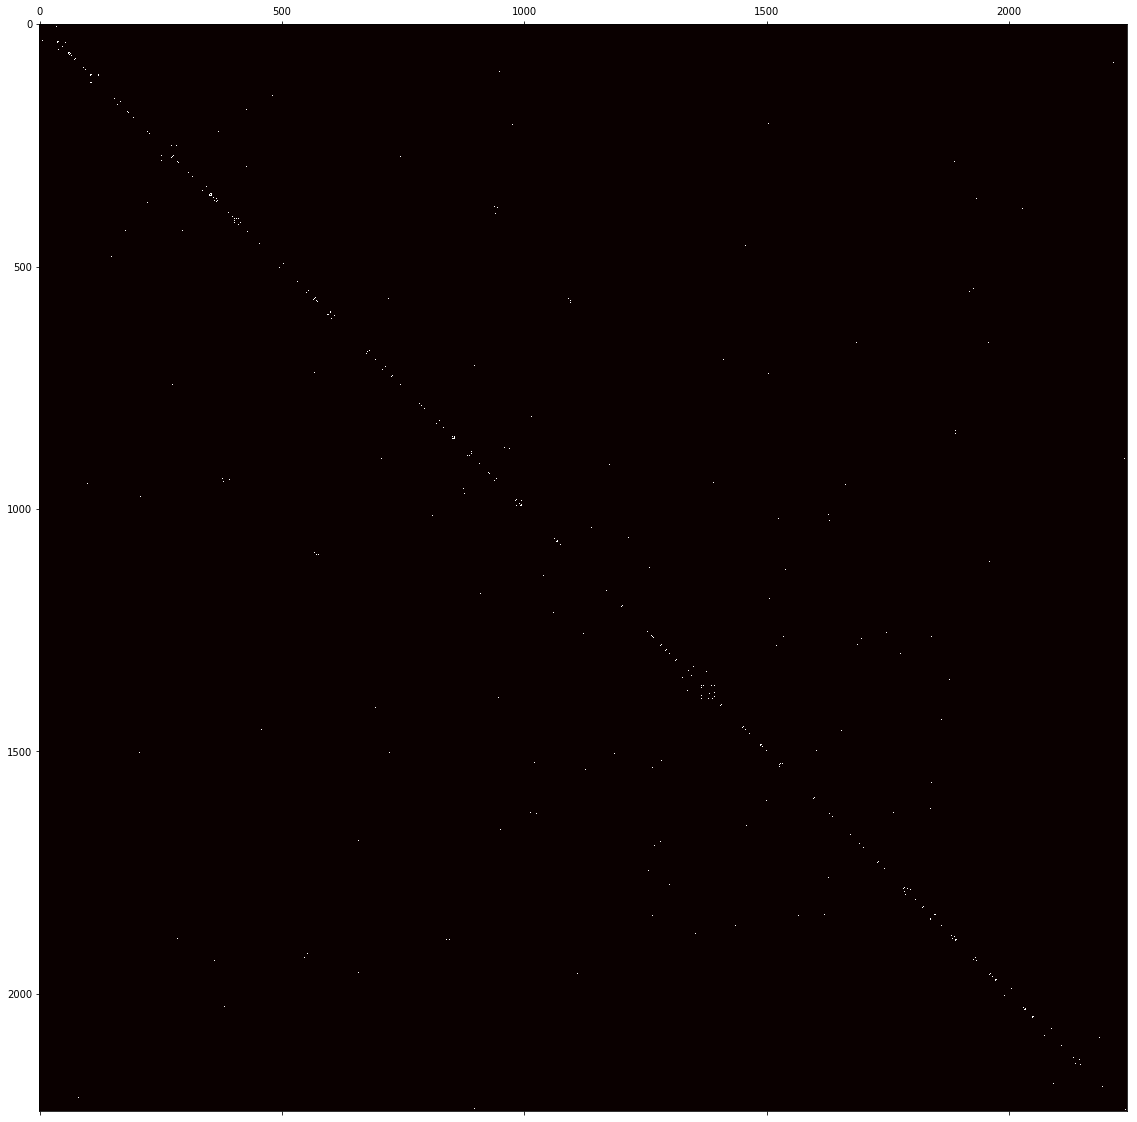

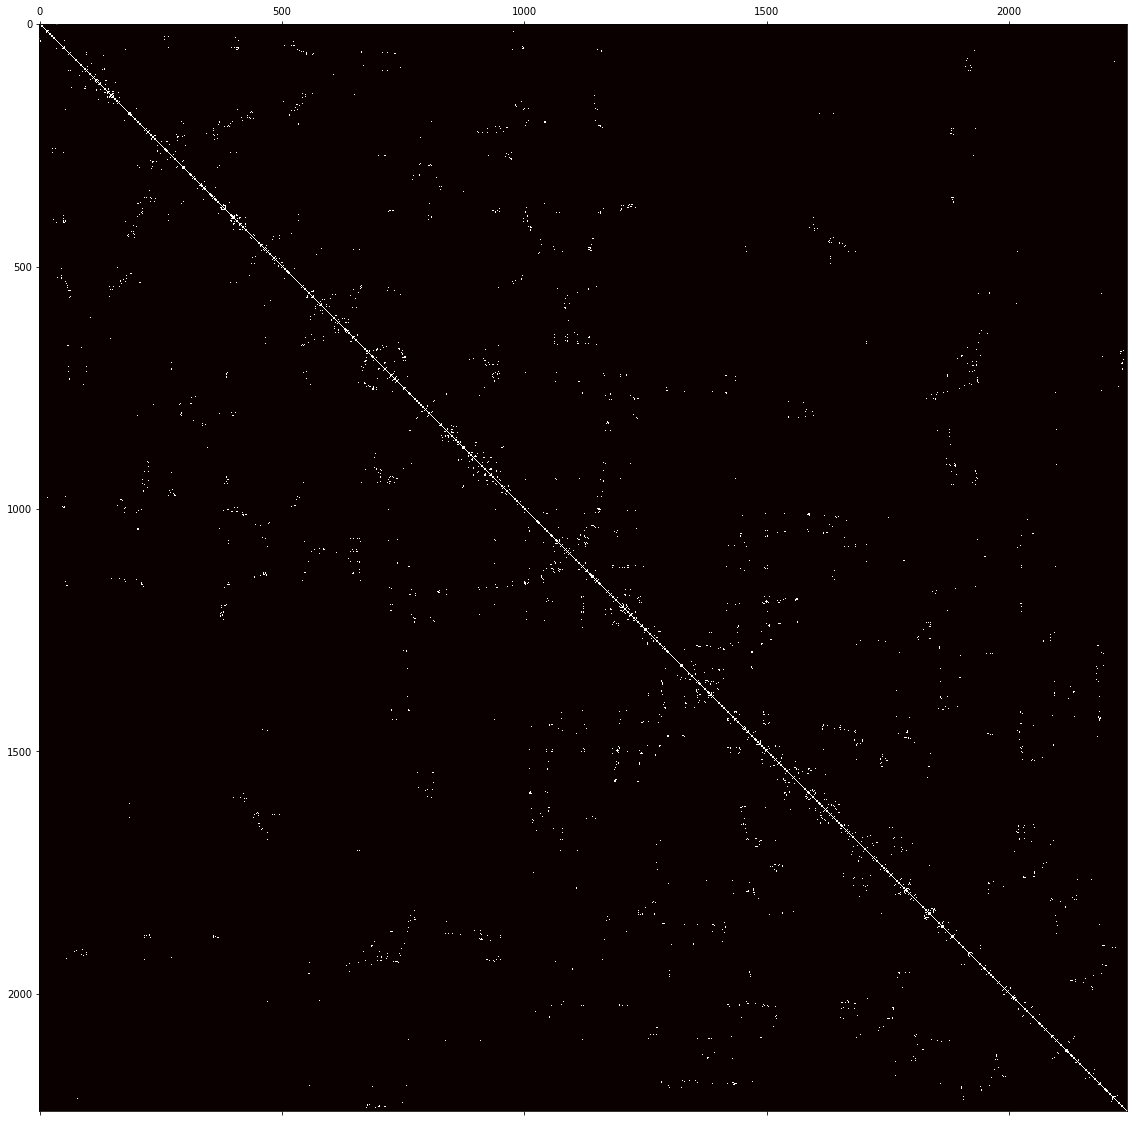

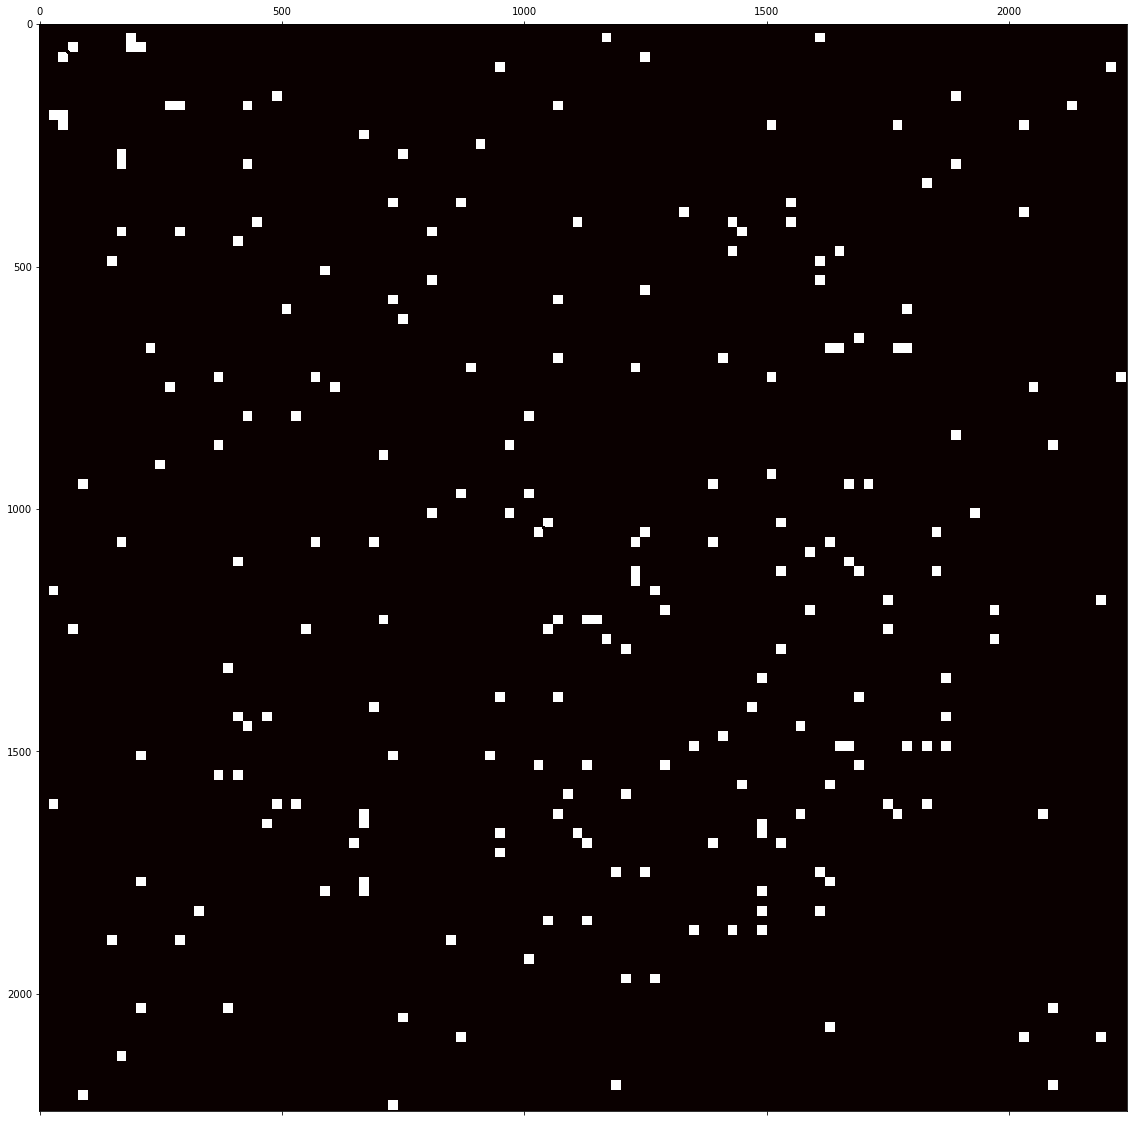

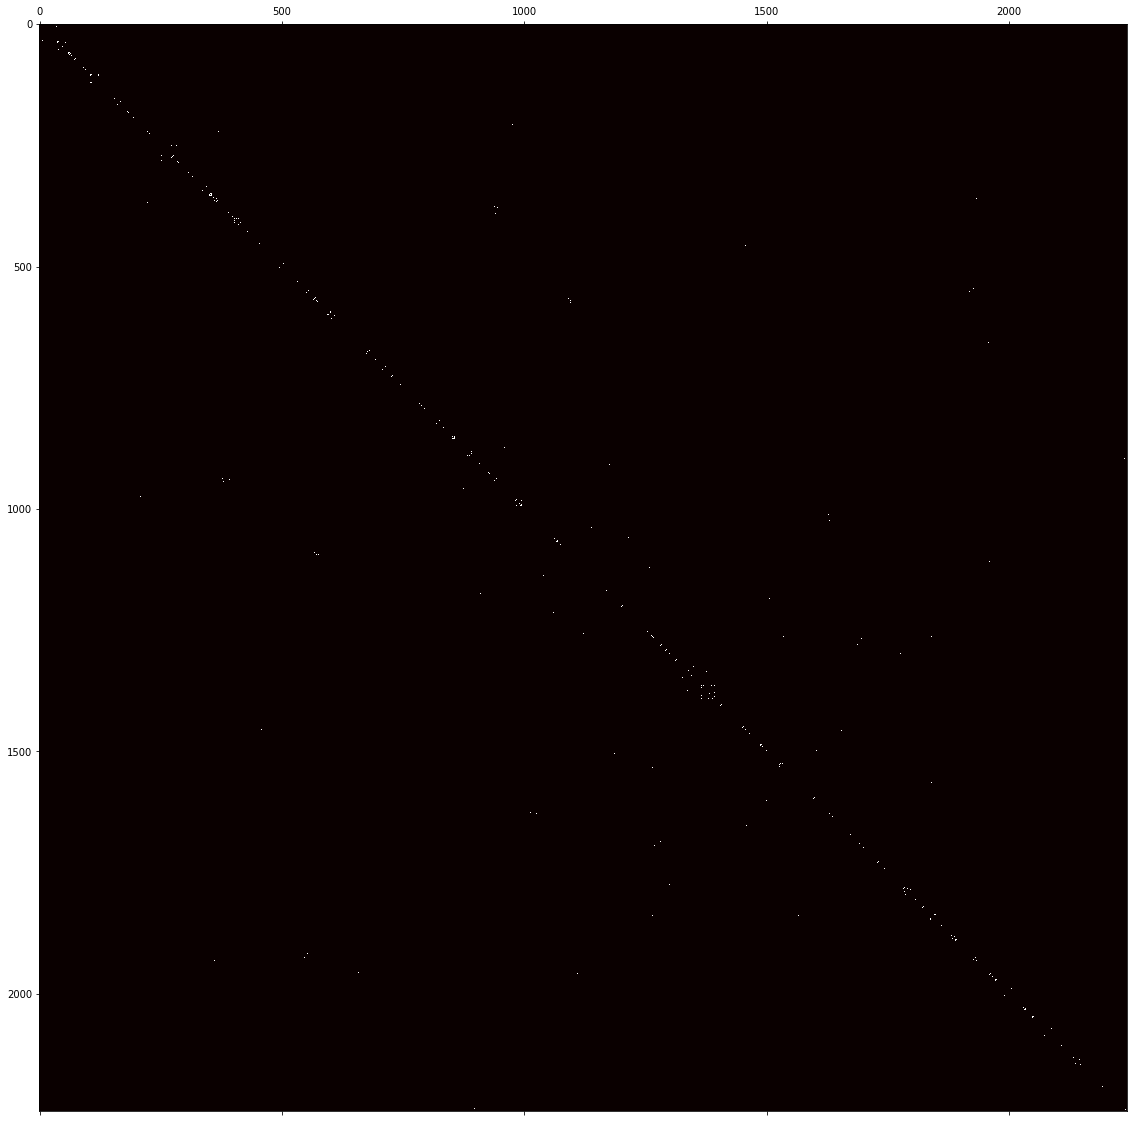

Removed 268 contacts
random walk


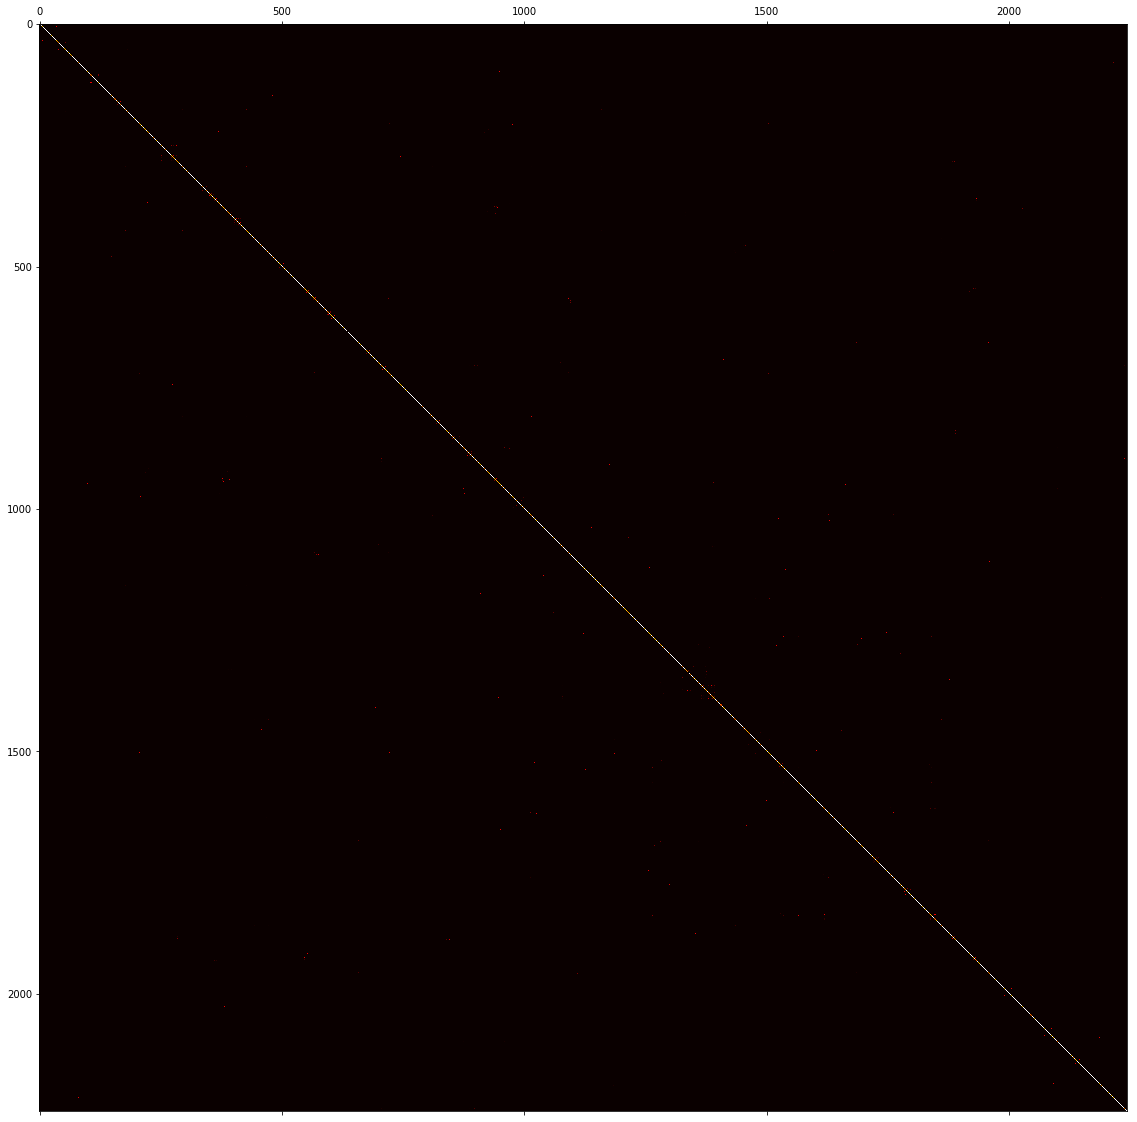

transitivity


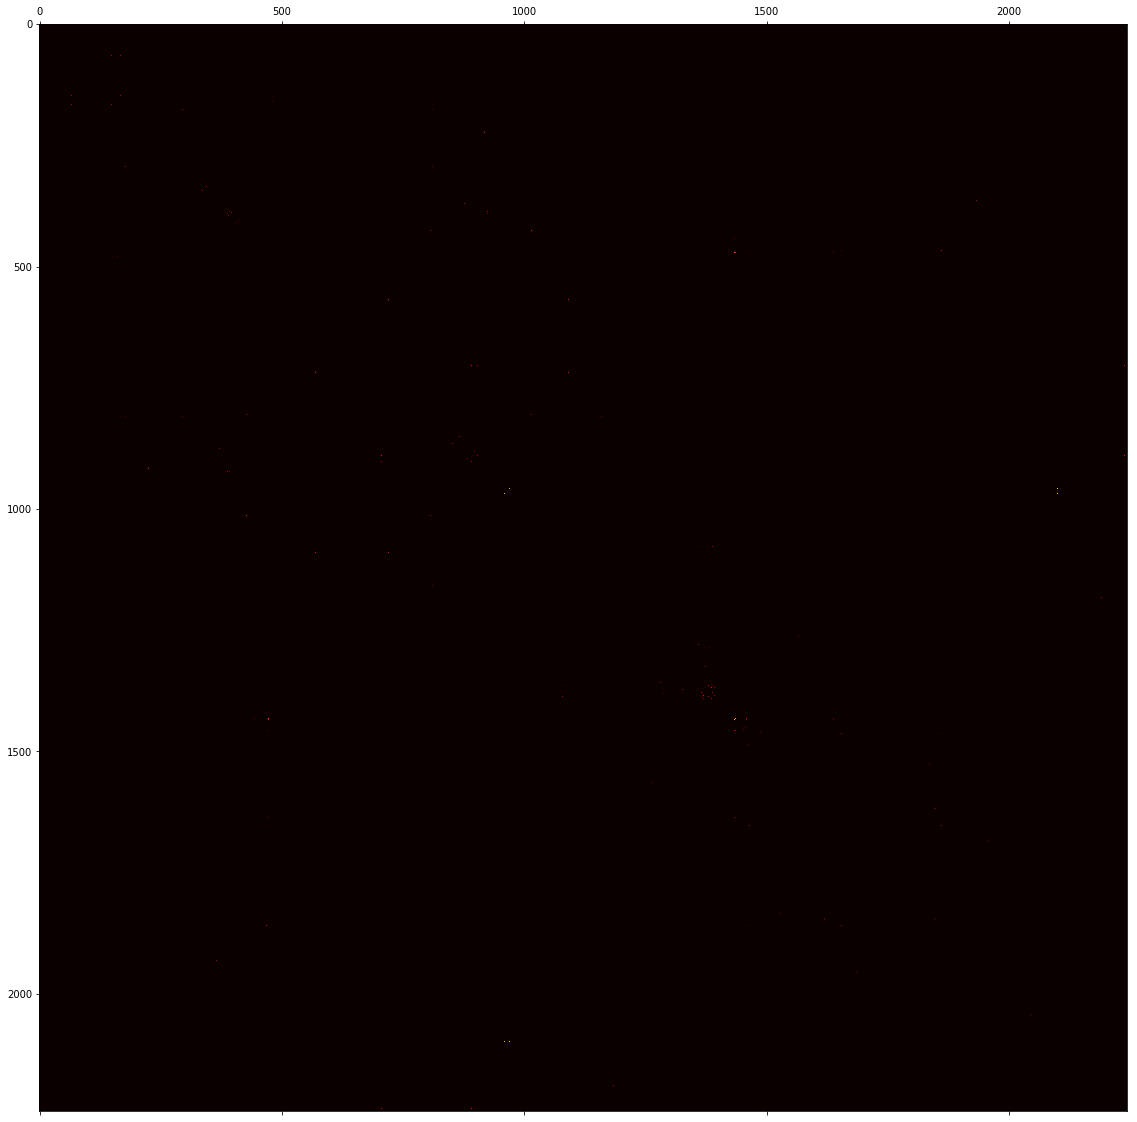

Precision max: 0.17672621921776918
Recall max: 0.6224489795918368
F1 max: 0.2752914629559985
A8


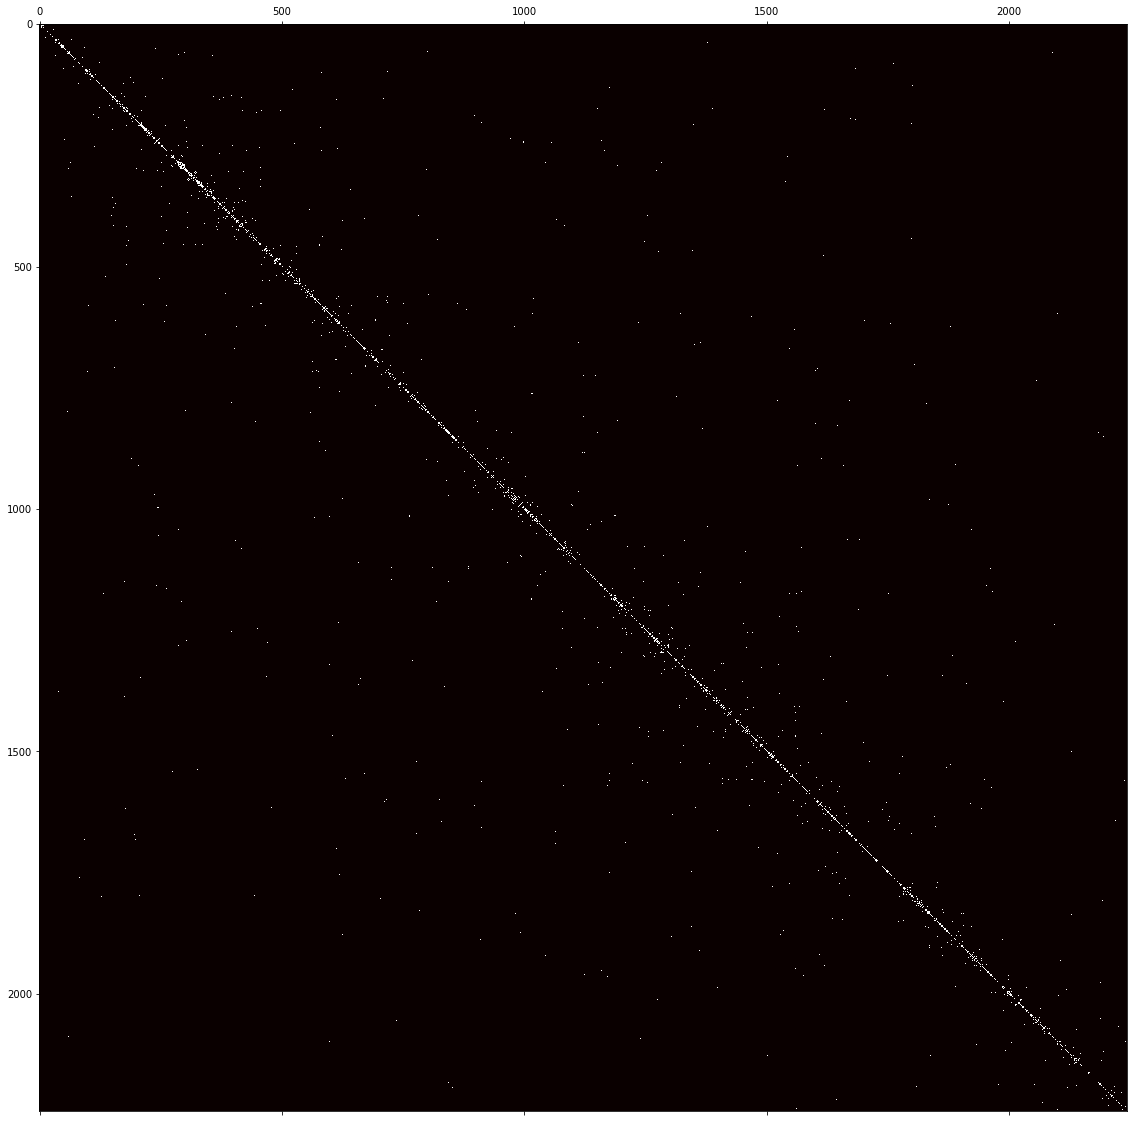

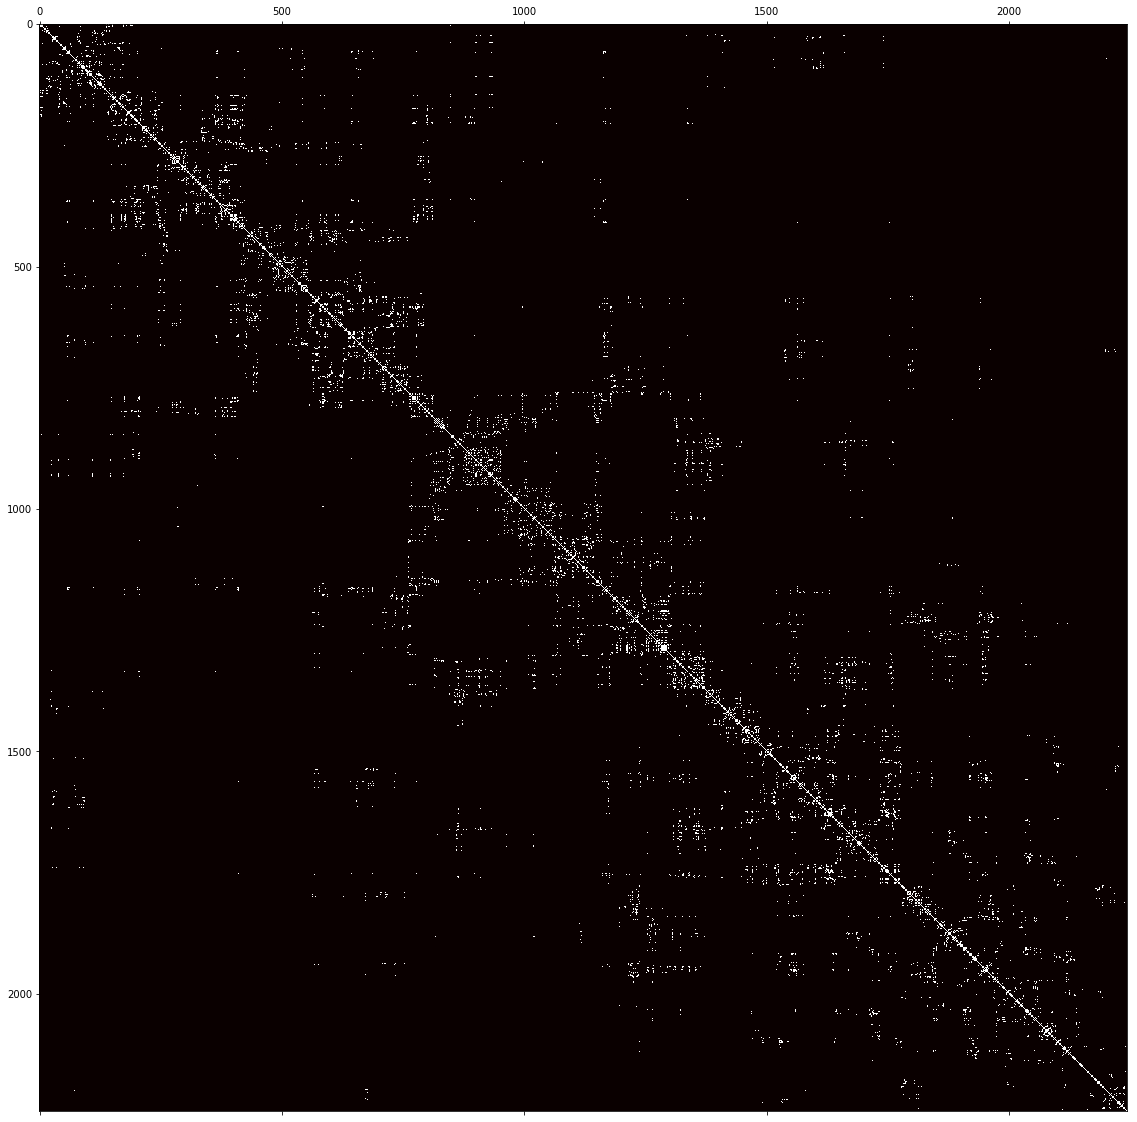

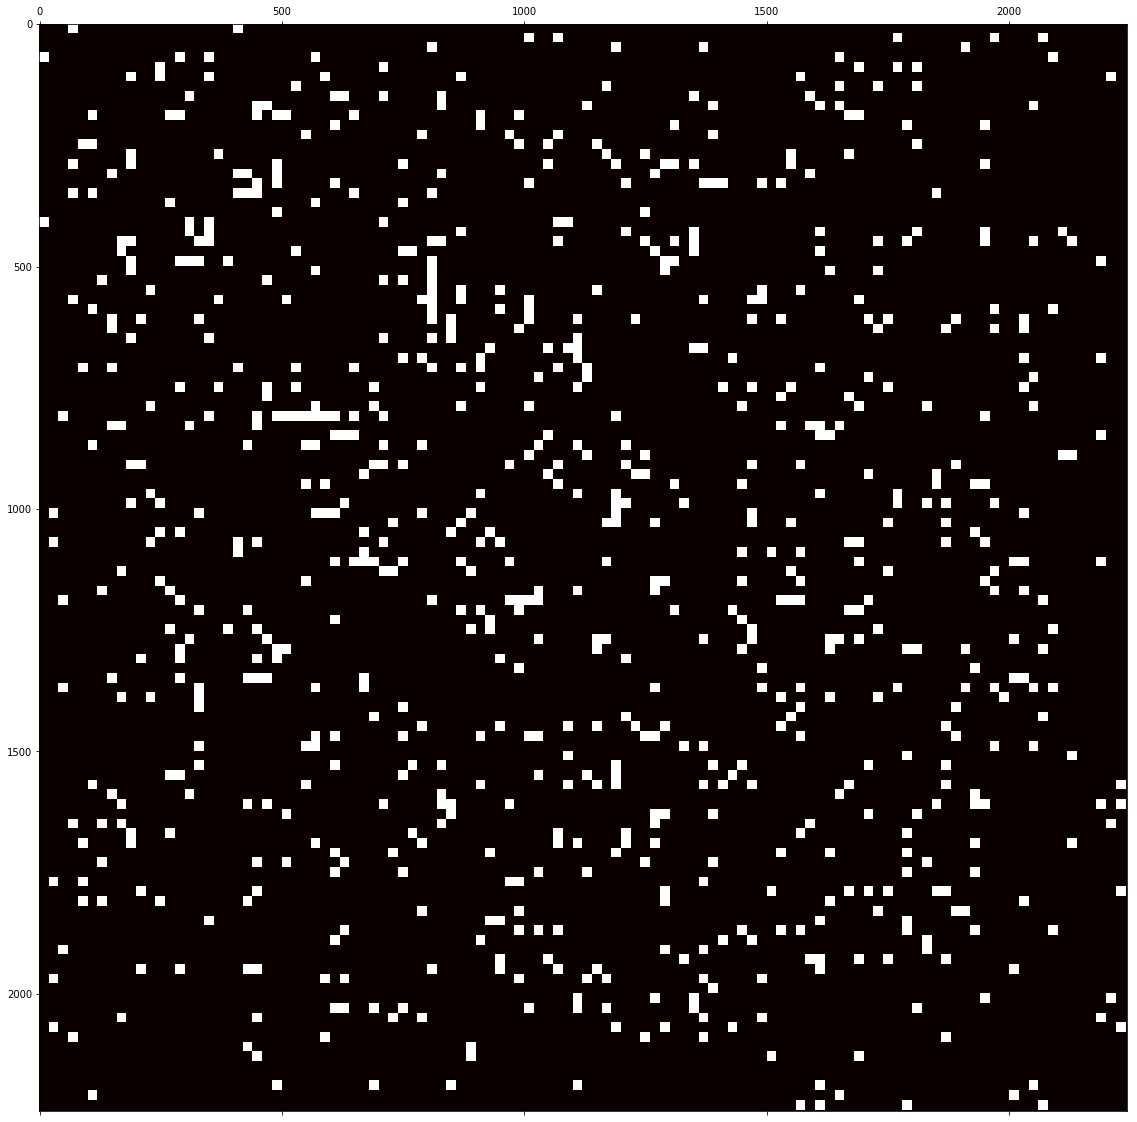

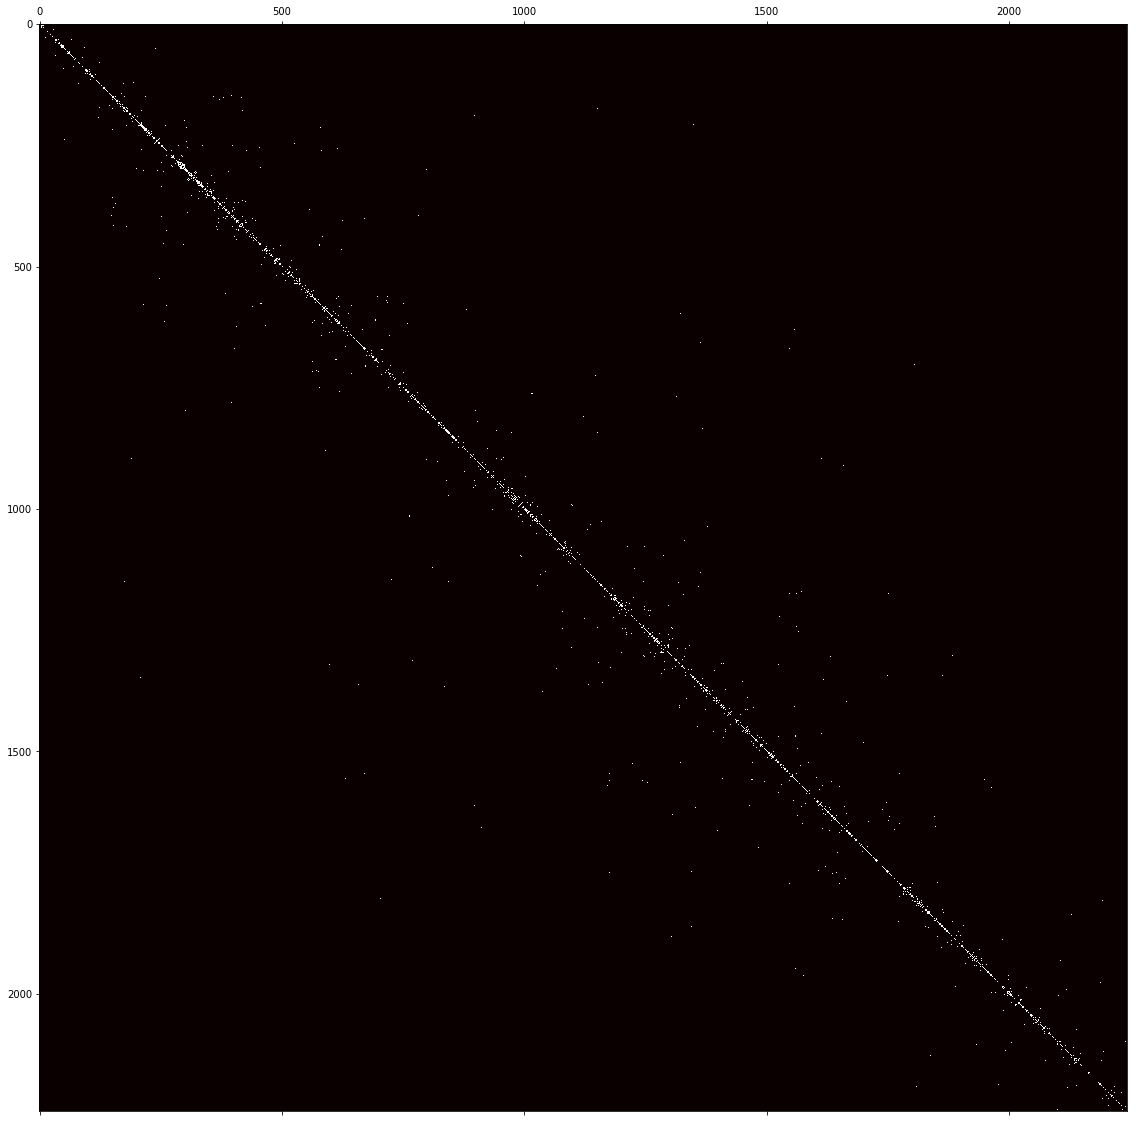

Removed 928 contacts
random walk


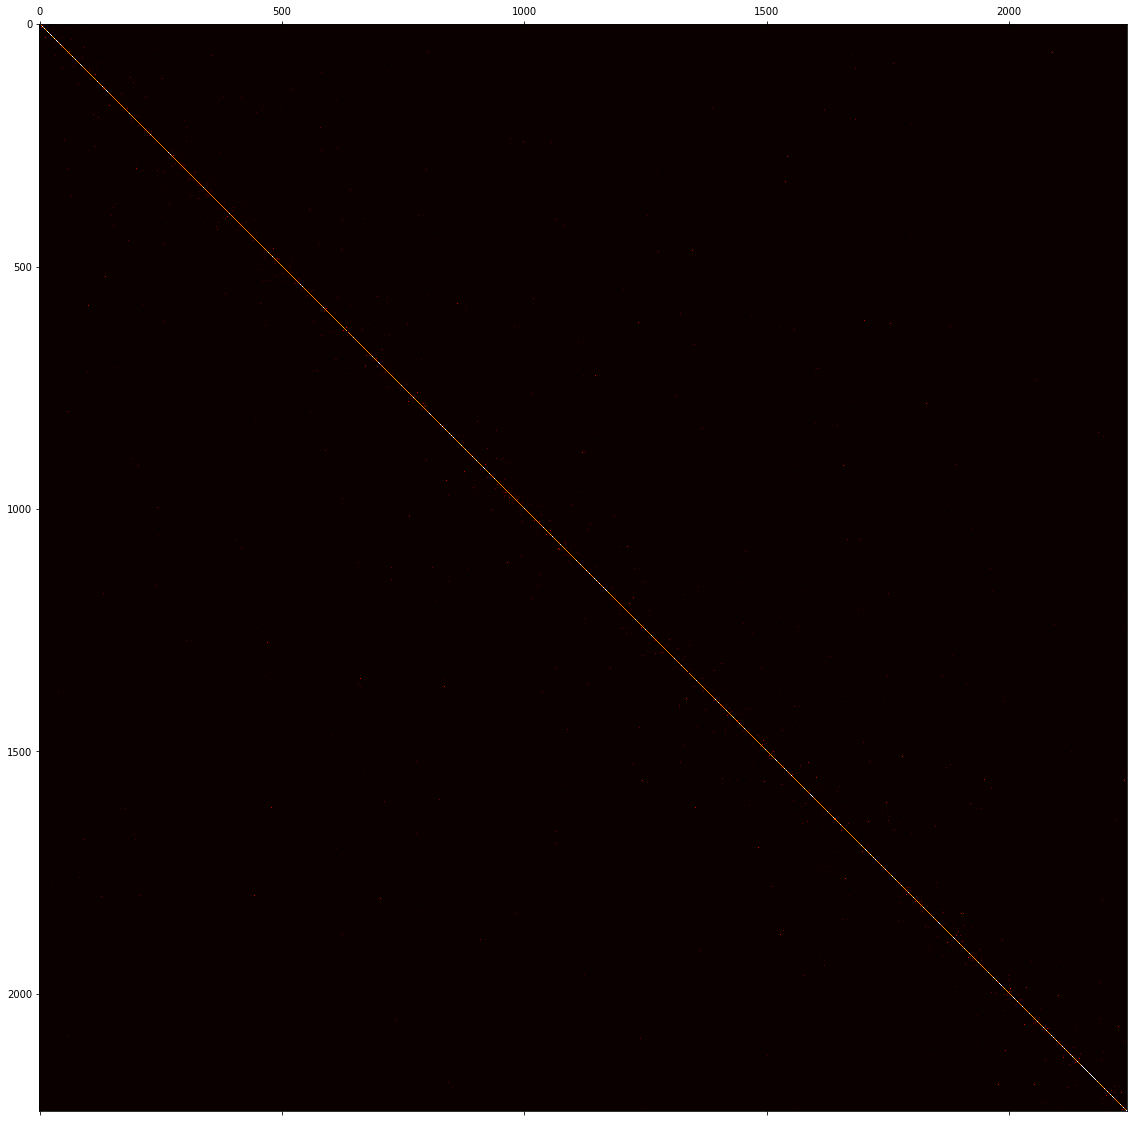

transitivity


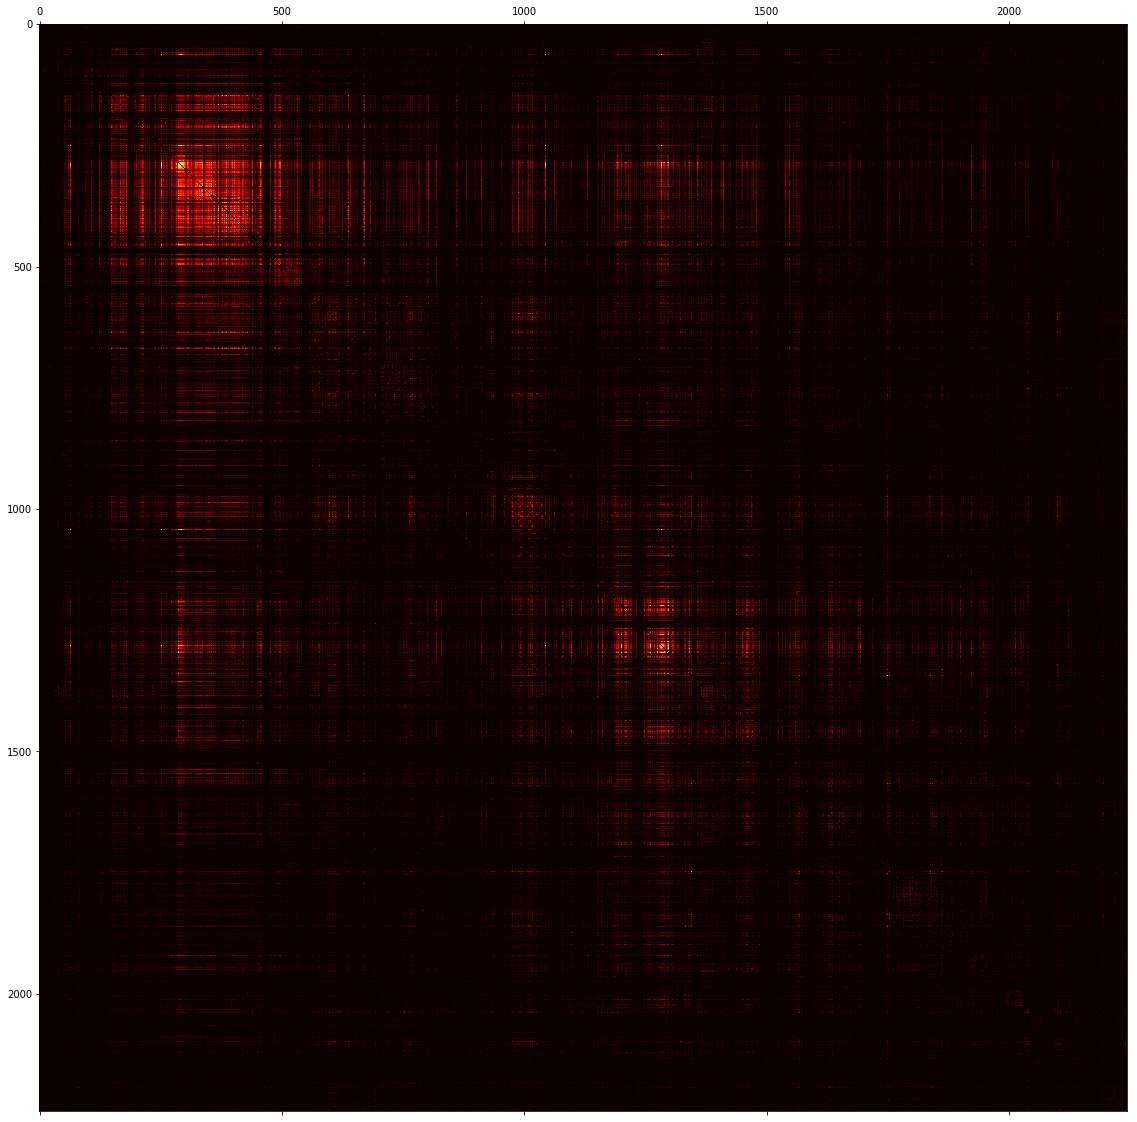

Precision max: 0.3967184295341342
Recall max: 0.6315298507462687
F1 max: 0.4873132985423789
sc1


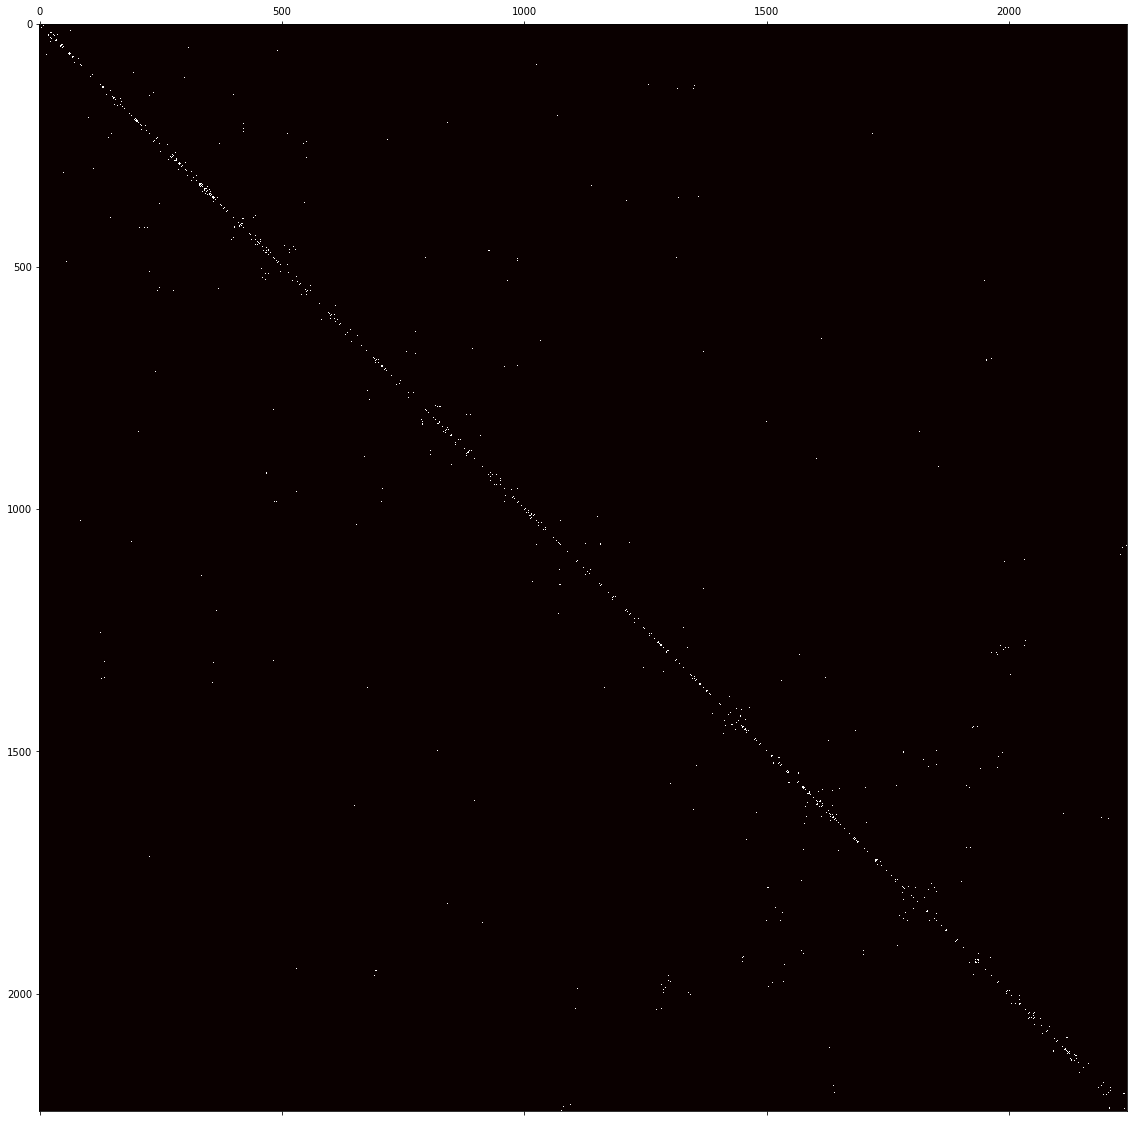

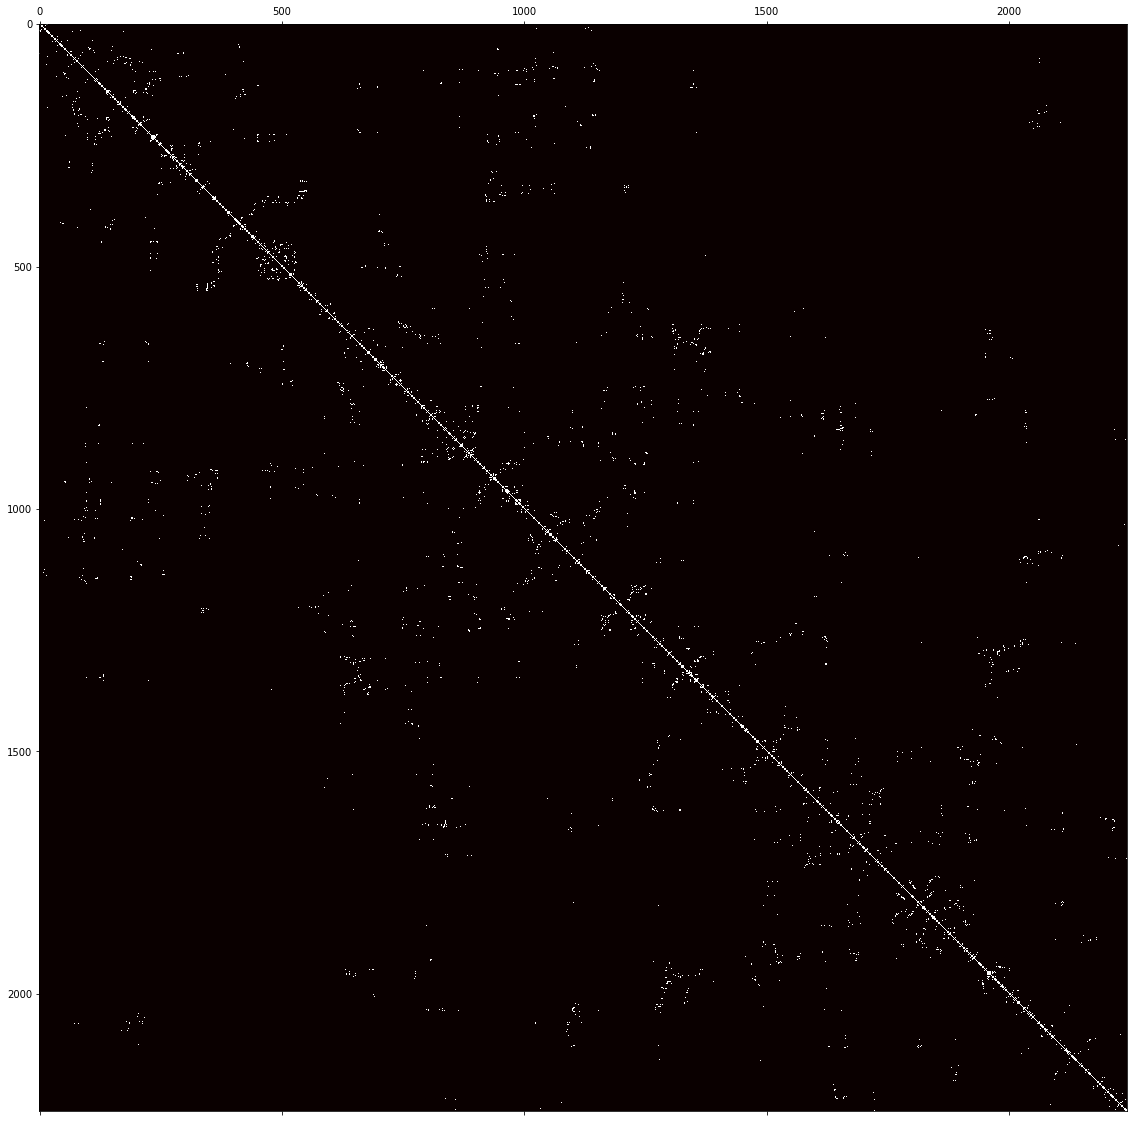

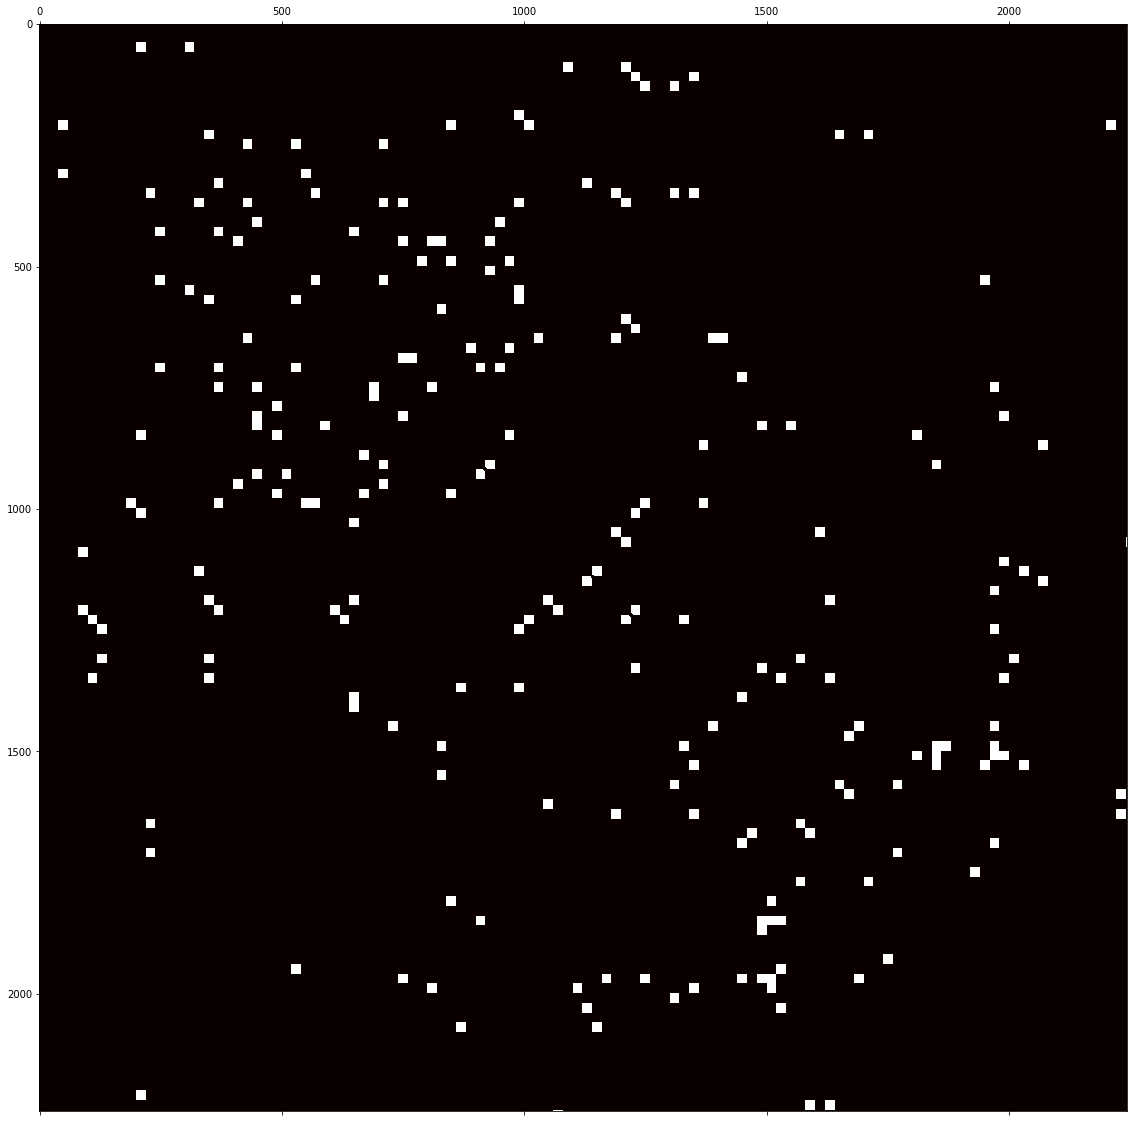

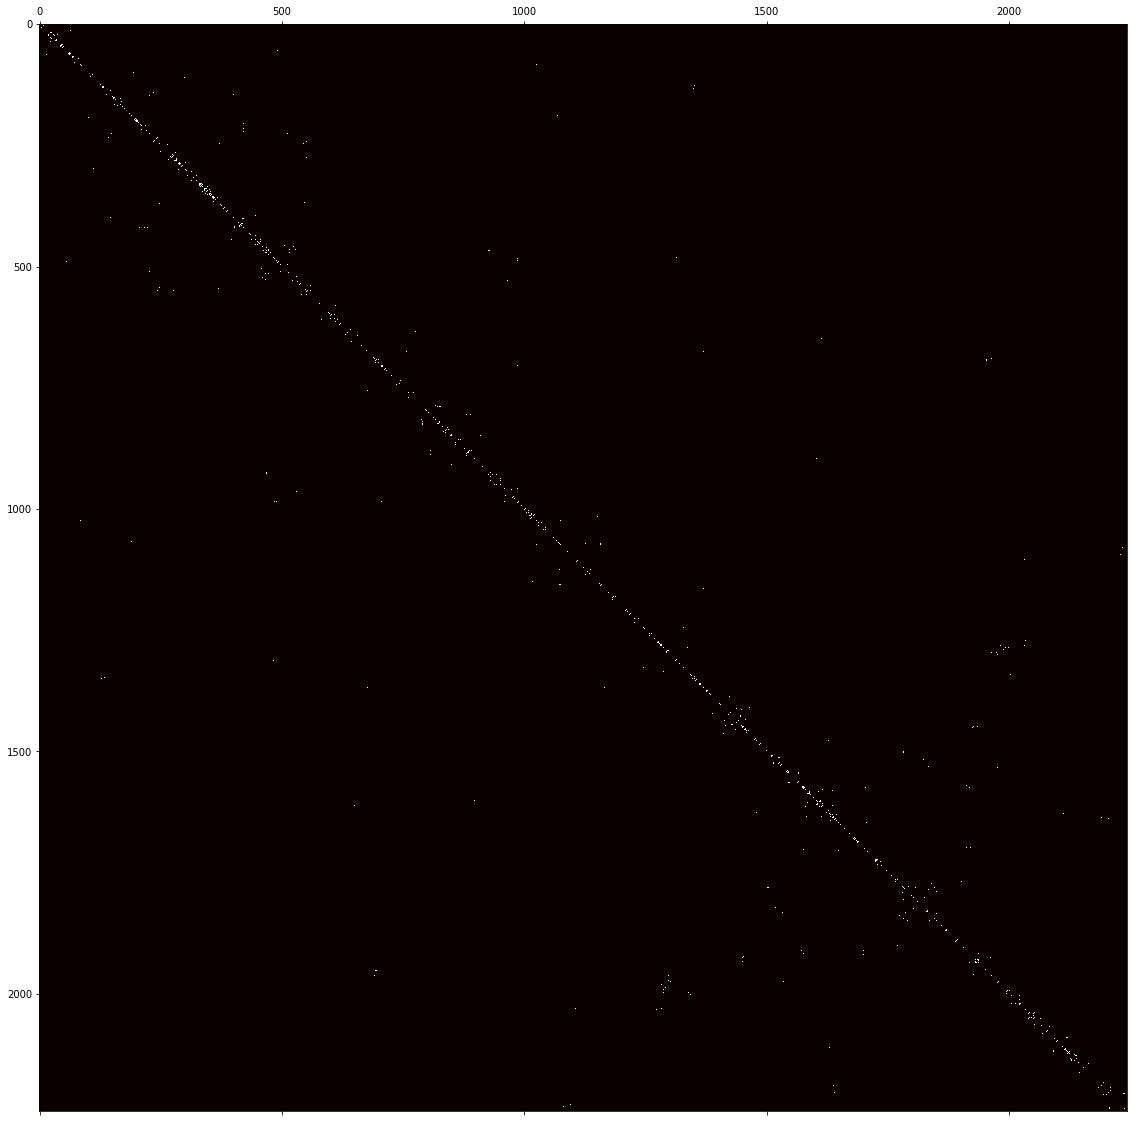

Removed 306 contacts
random walk


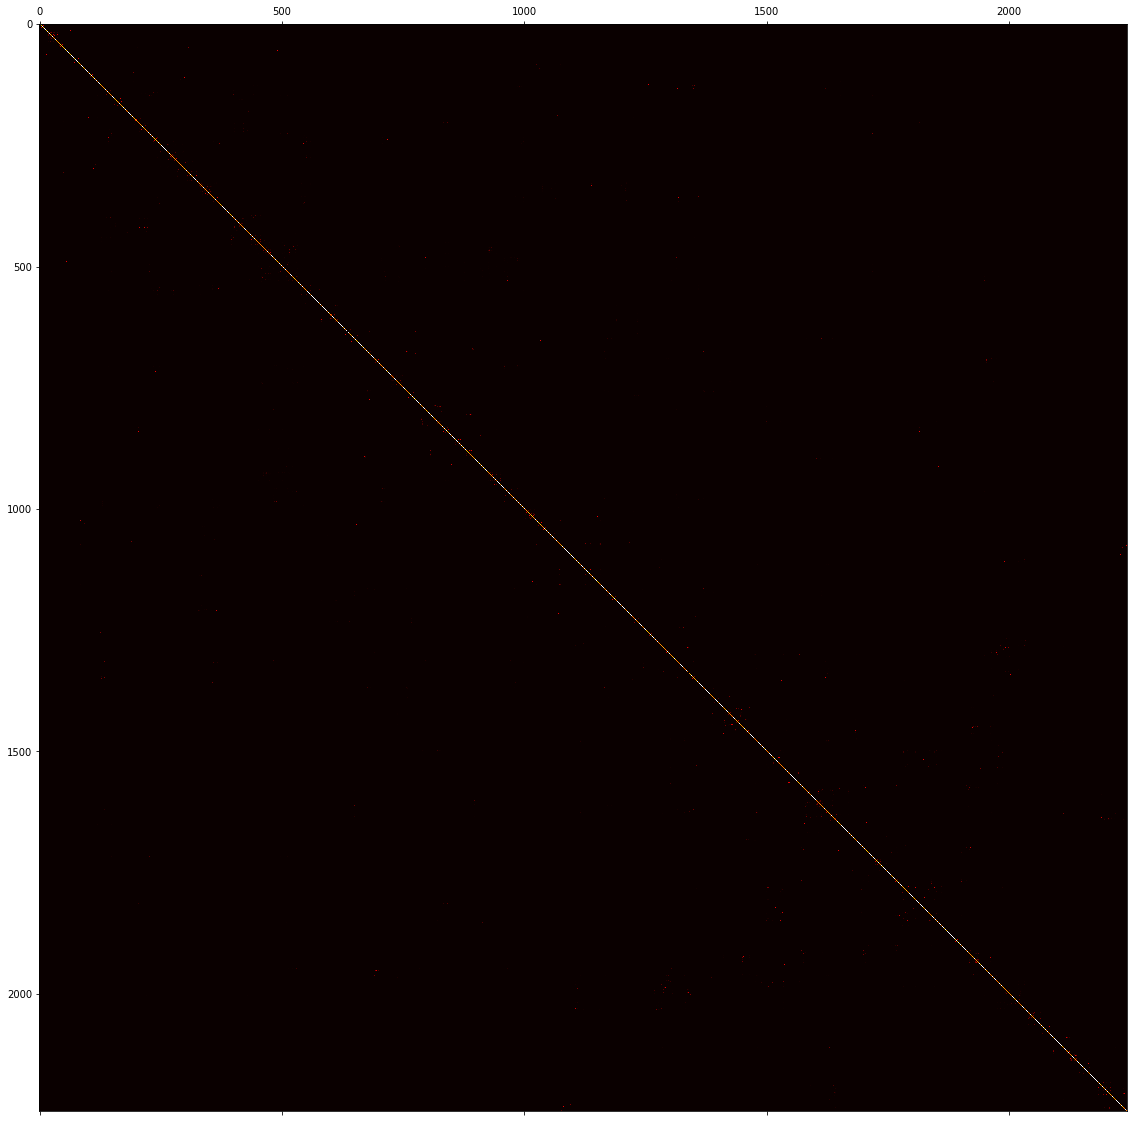

transitivity


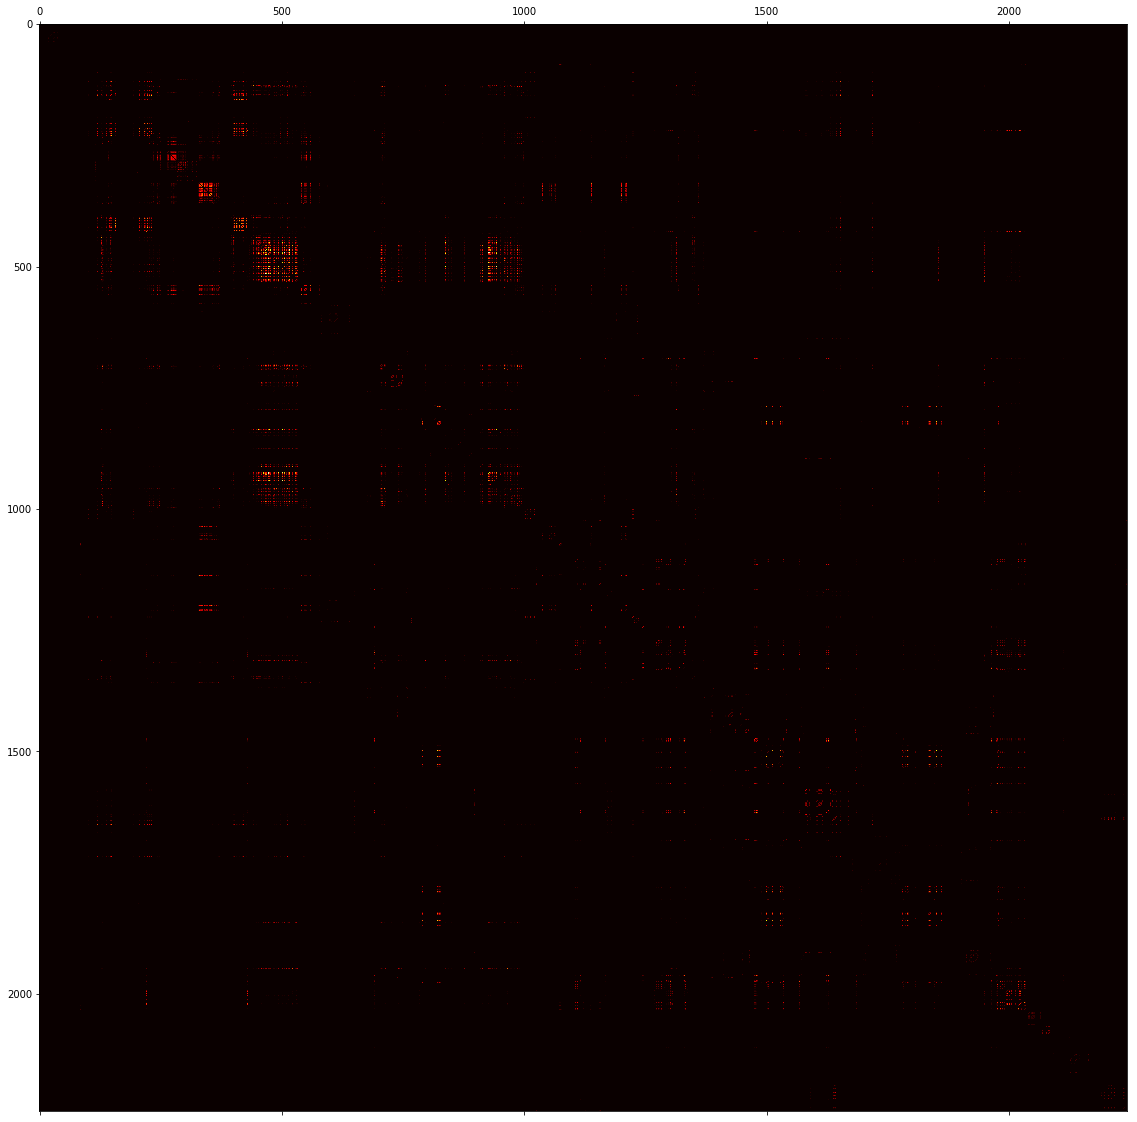

Precision max: 0.33413577274915746
Recall max: 0.7510822510822511
F1 max: 0.46251249583472176
B26


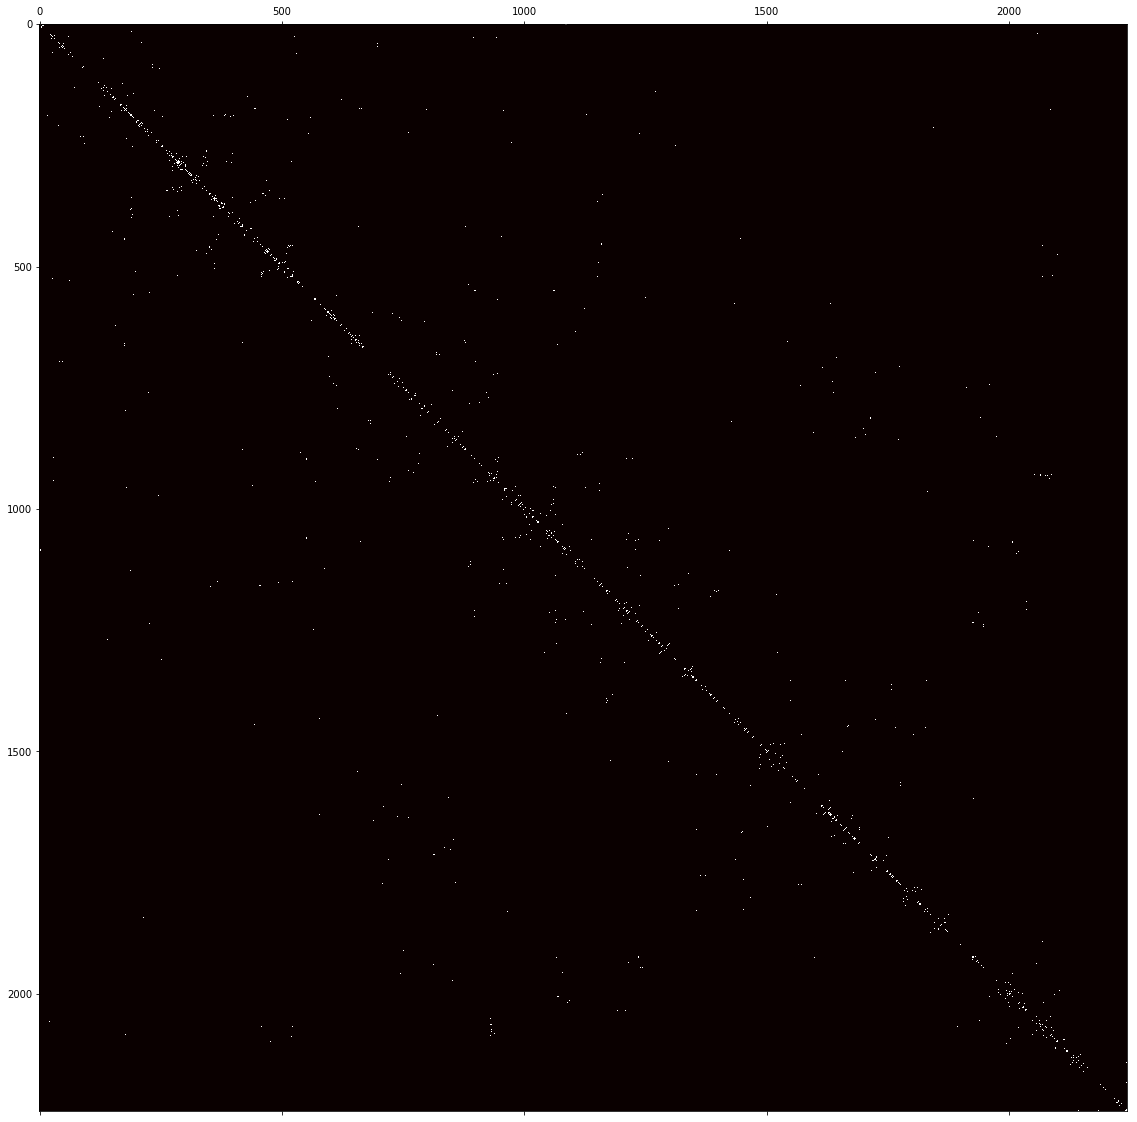

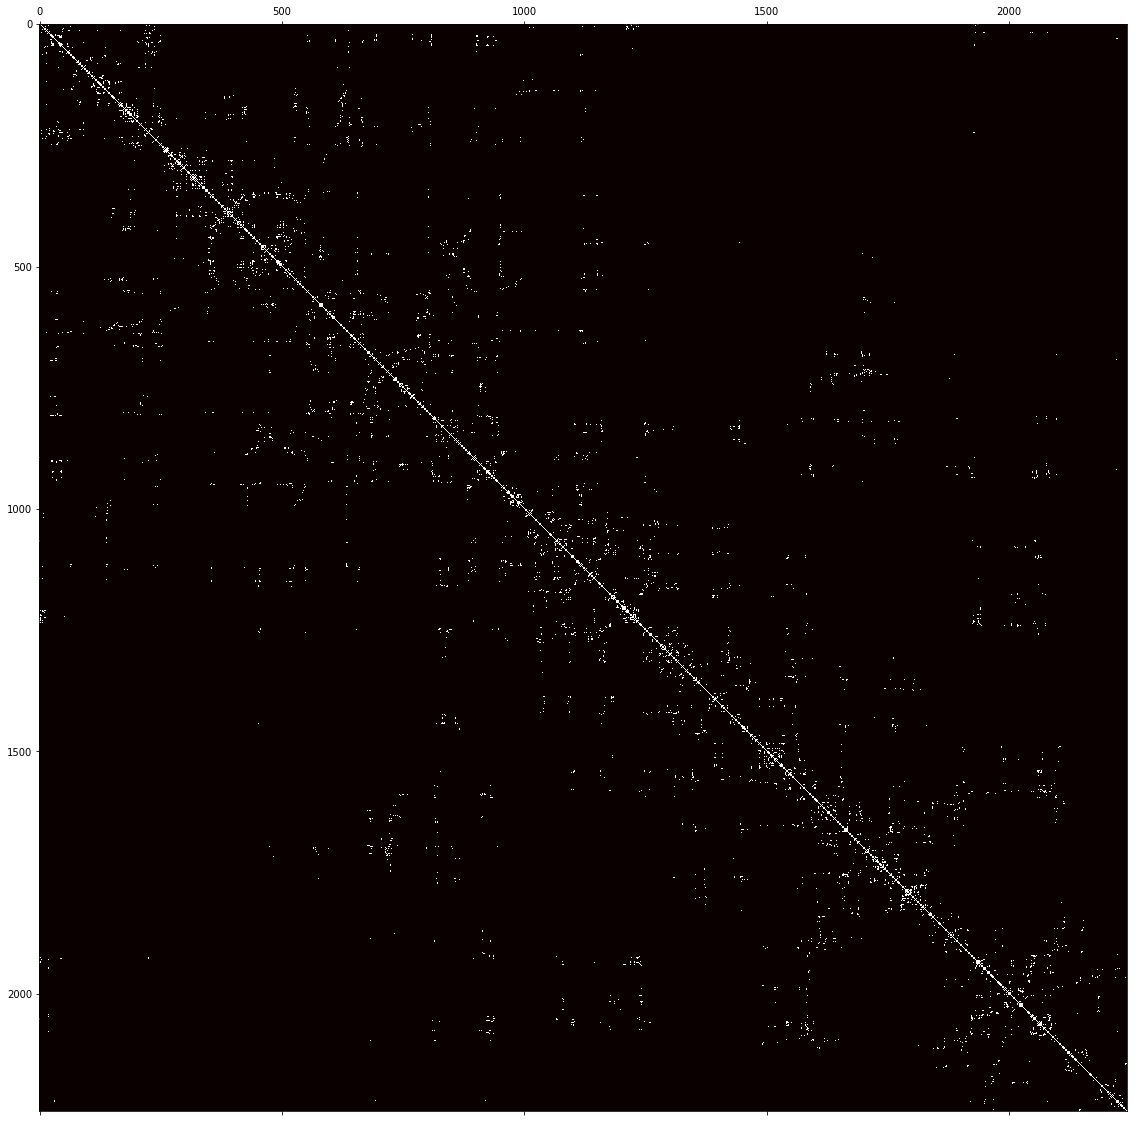

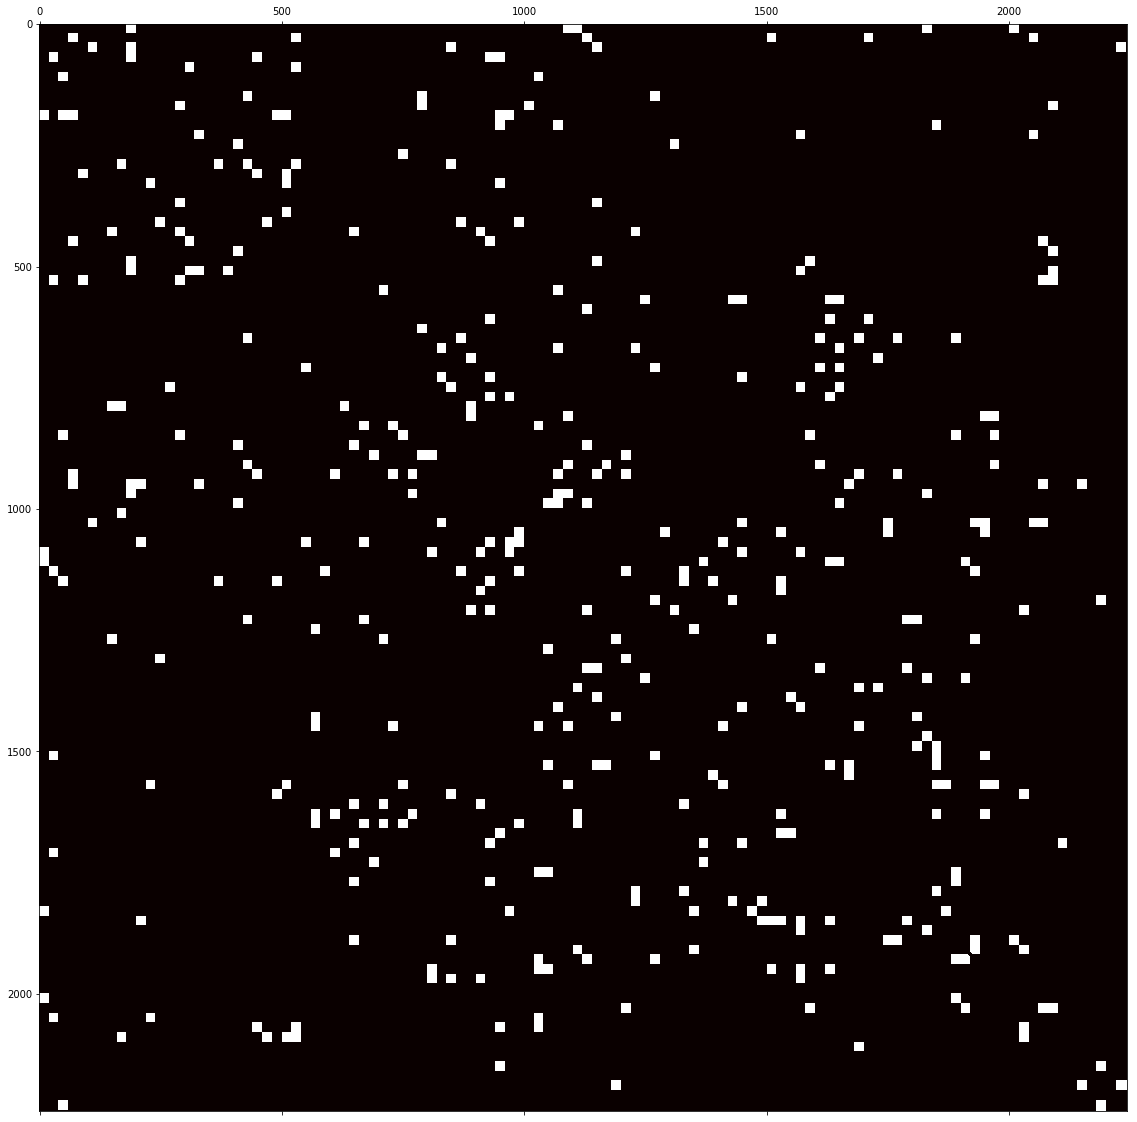

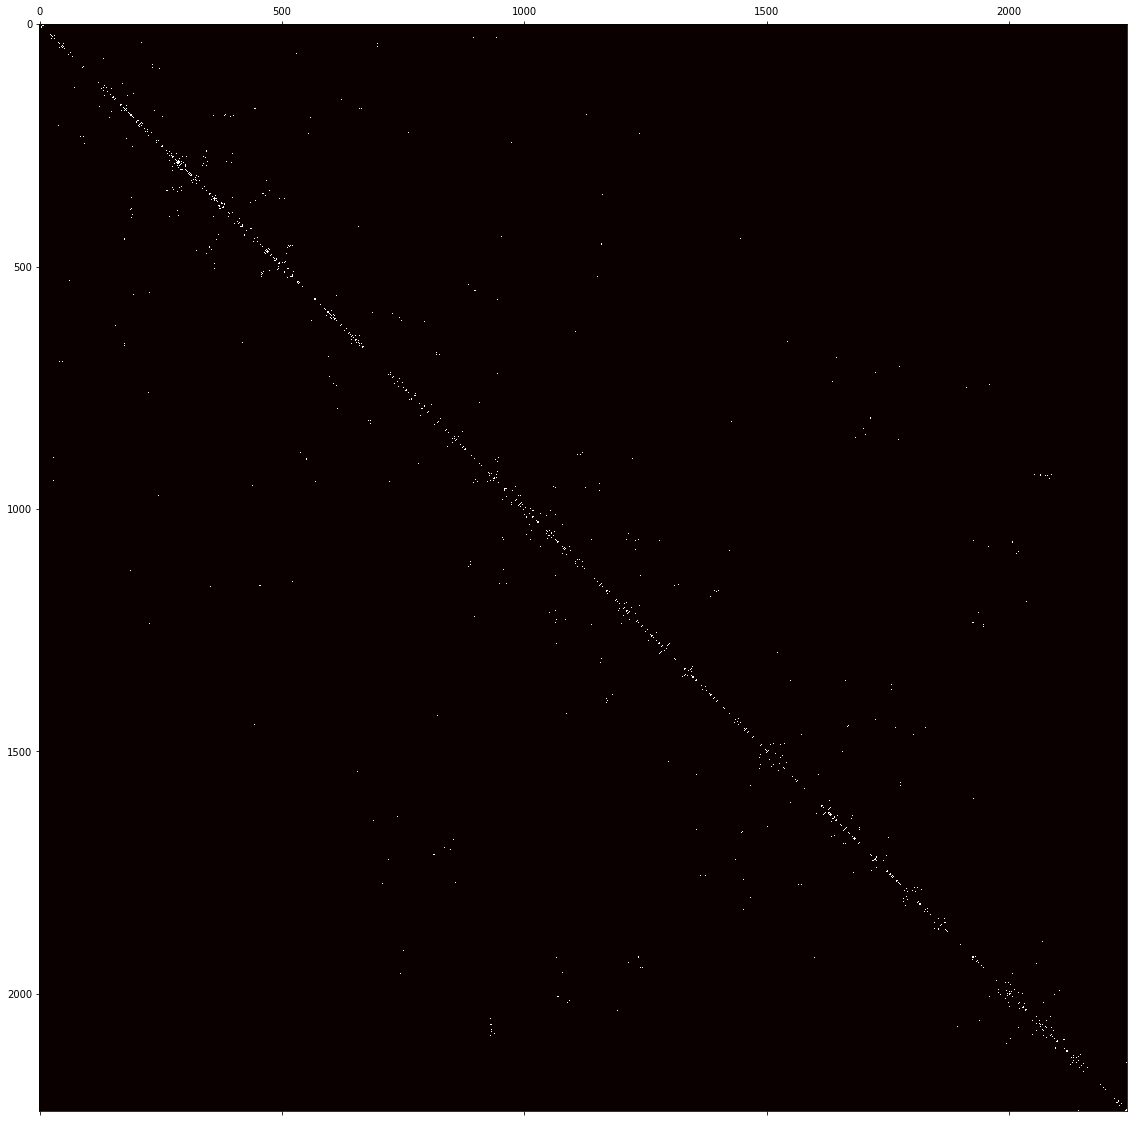

Removed 536 contacts
random walk


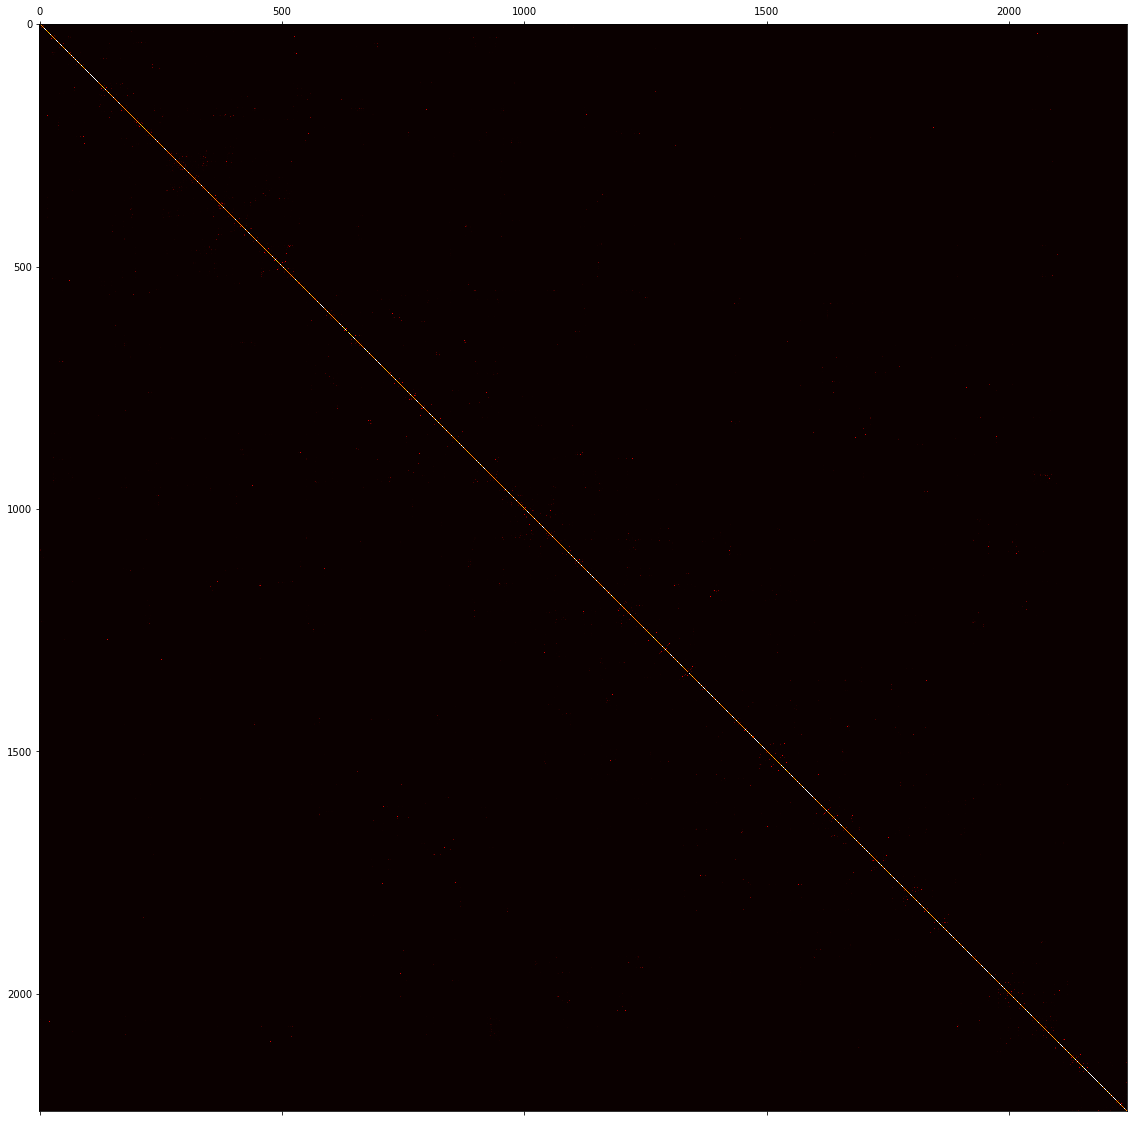

transitivity


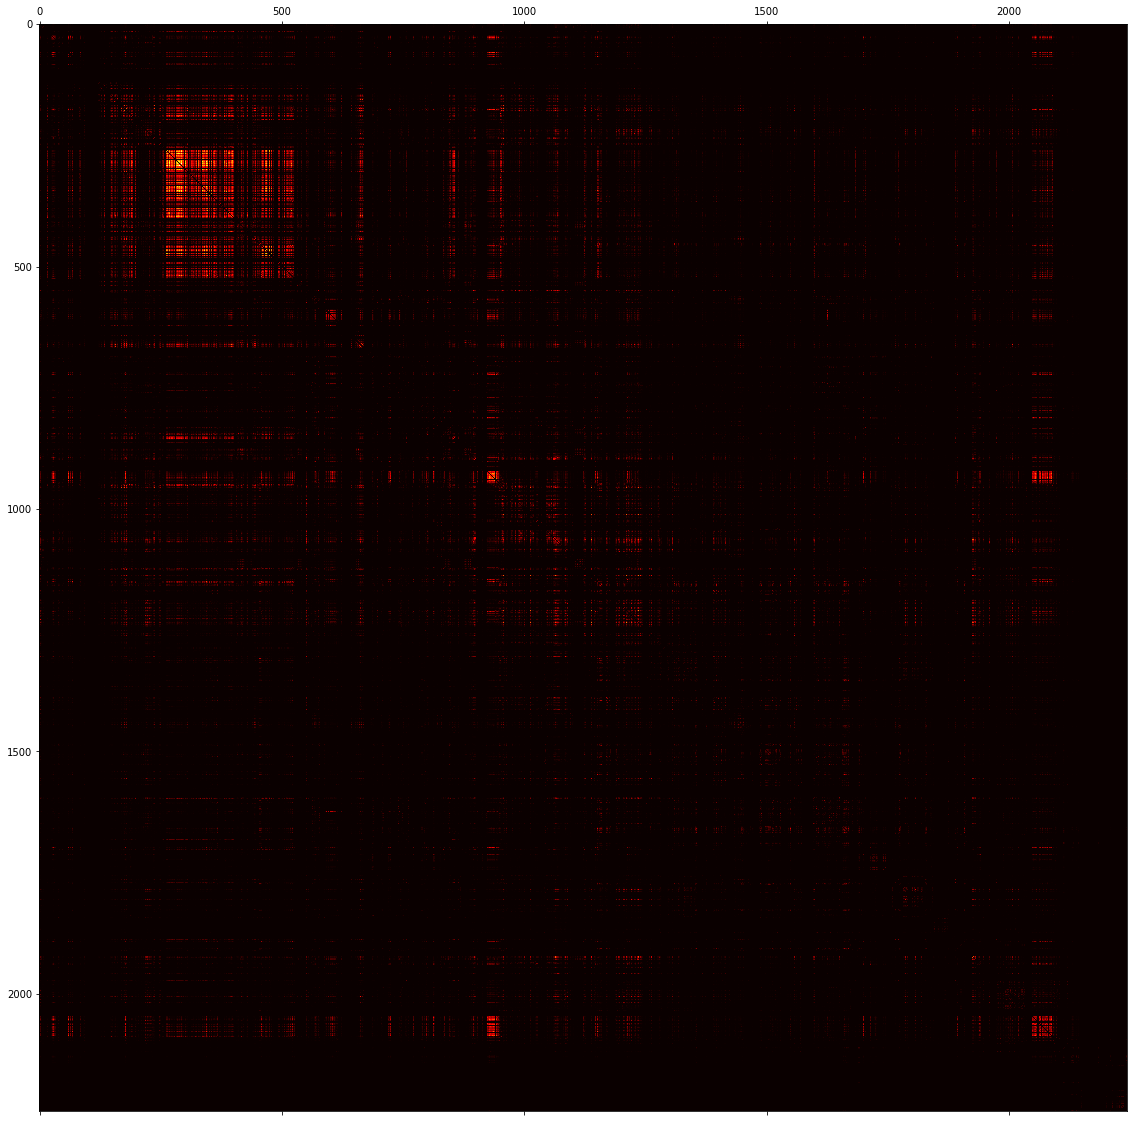

Precision max: 0.3689035570223689
Recall max: 0.7074542897327707
F1 max: 0.484936129187756
B31


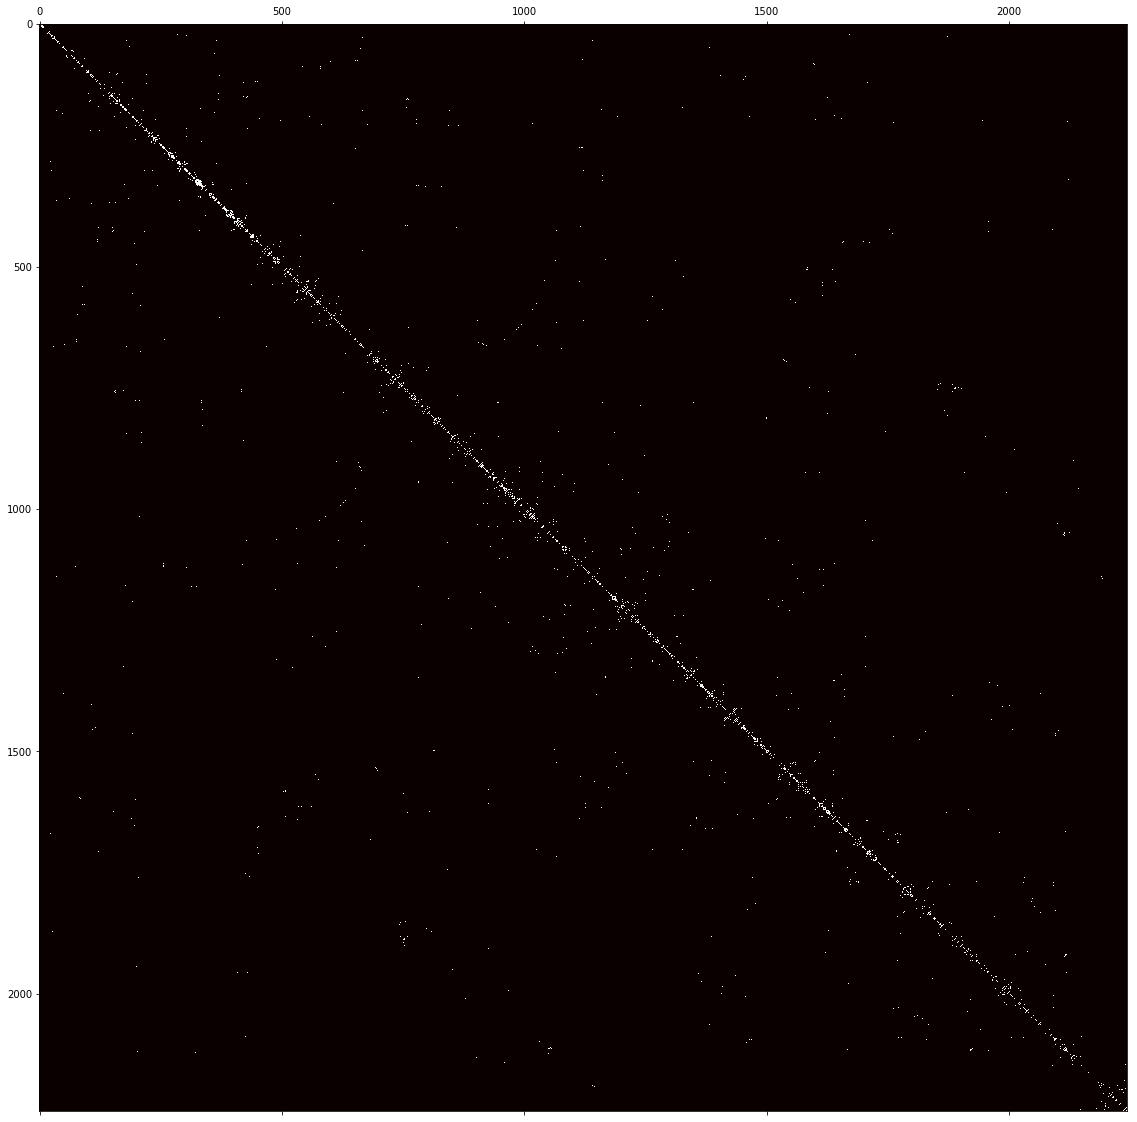

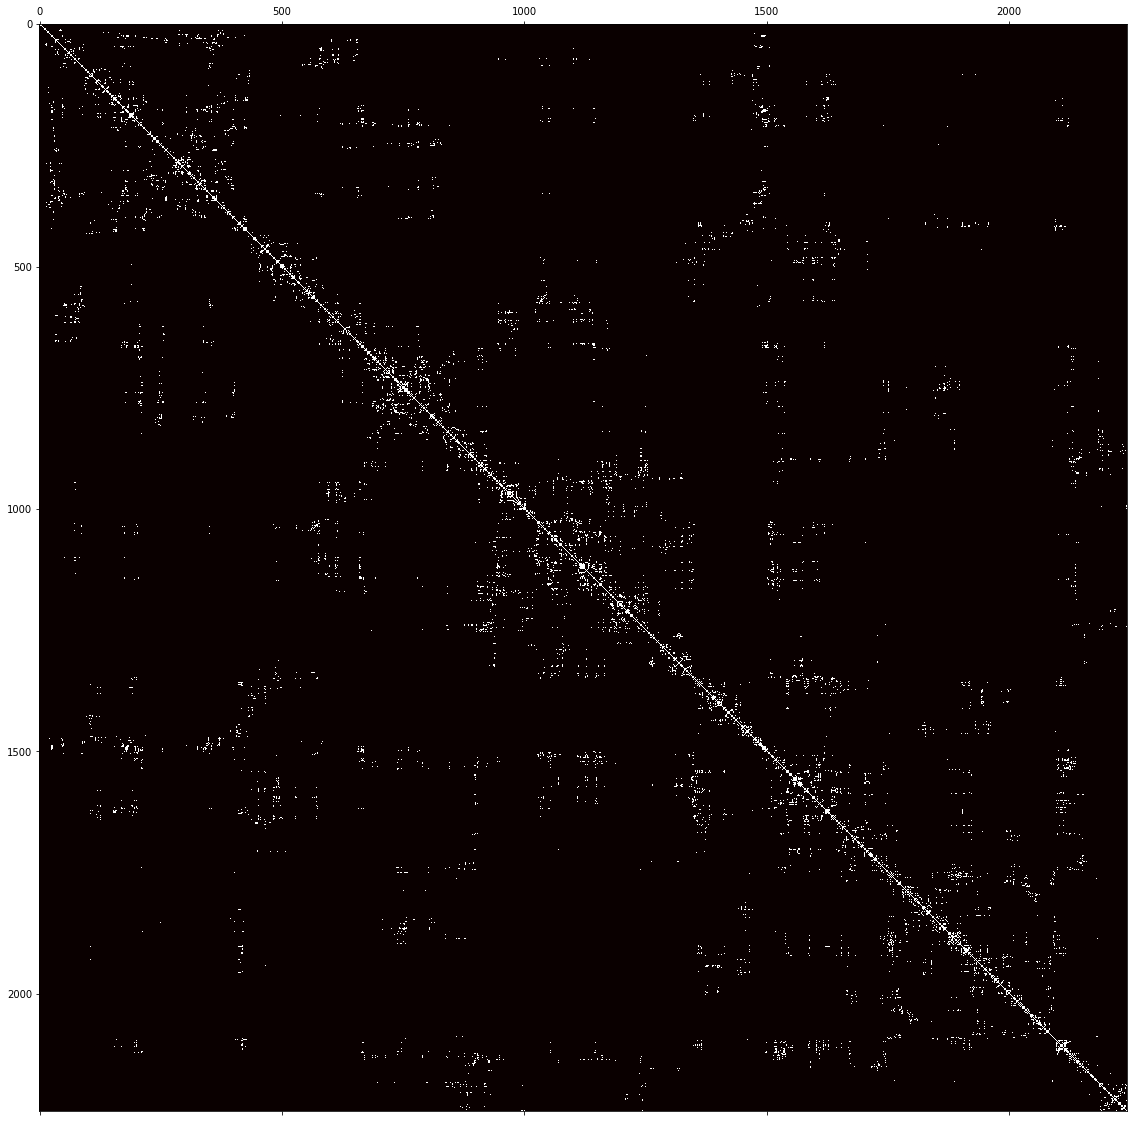

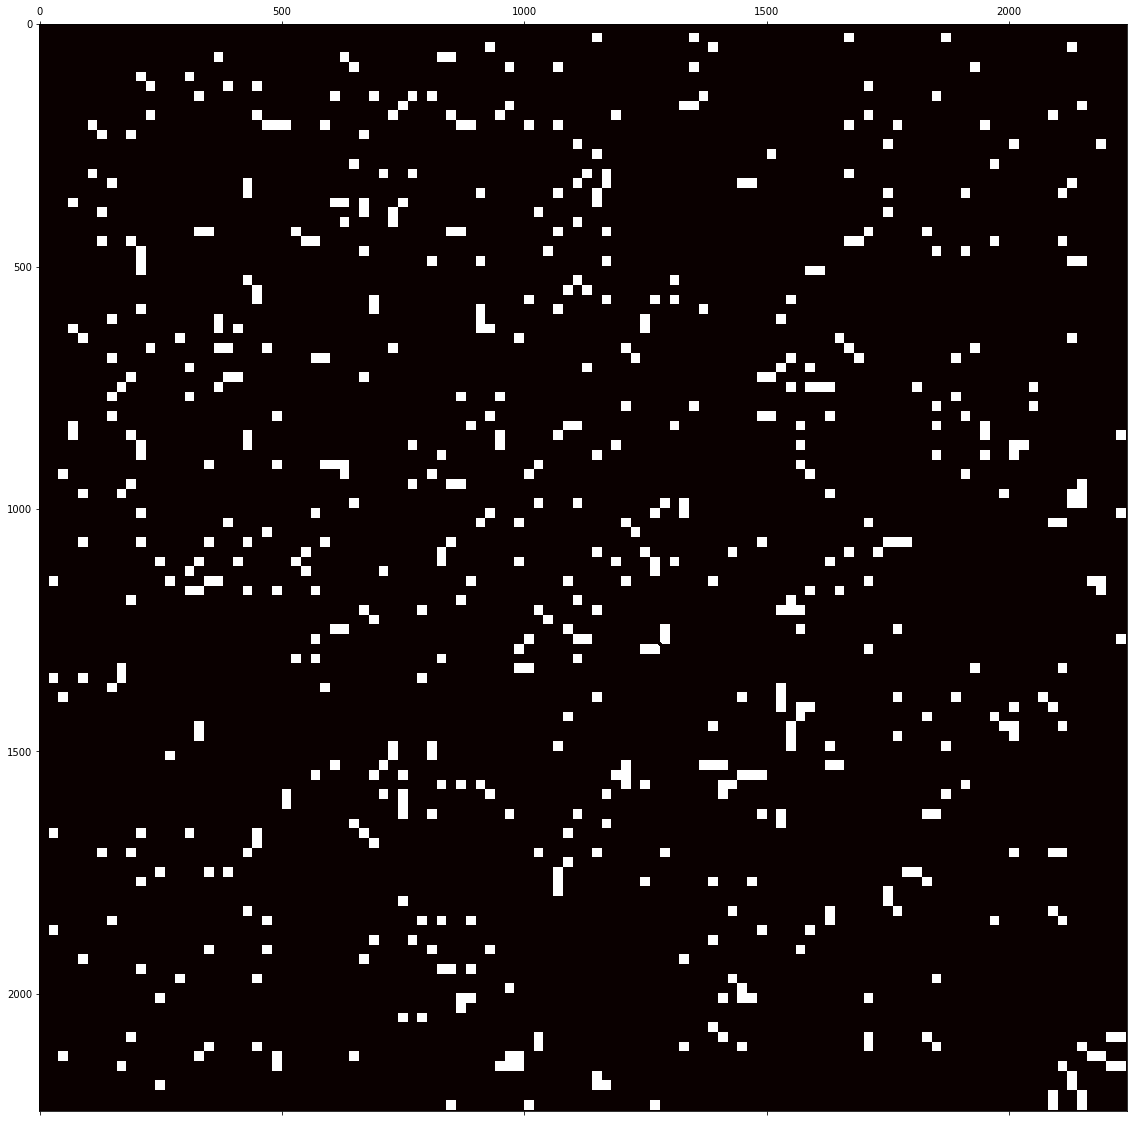

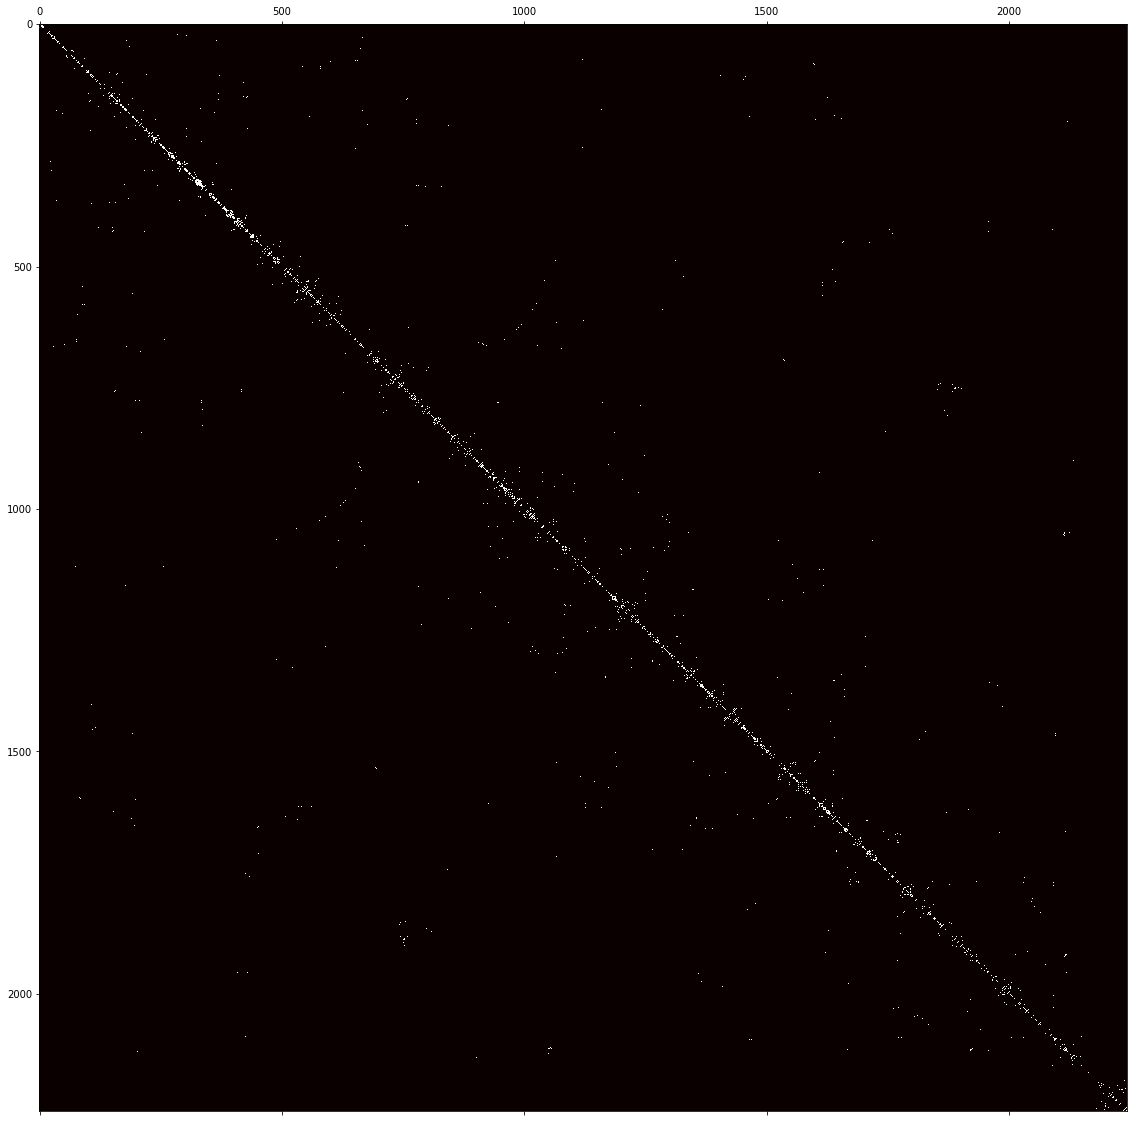

Removed 902 contacts
random walk


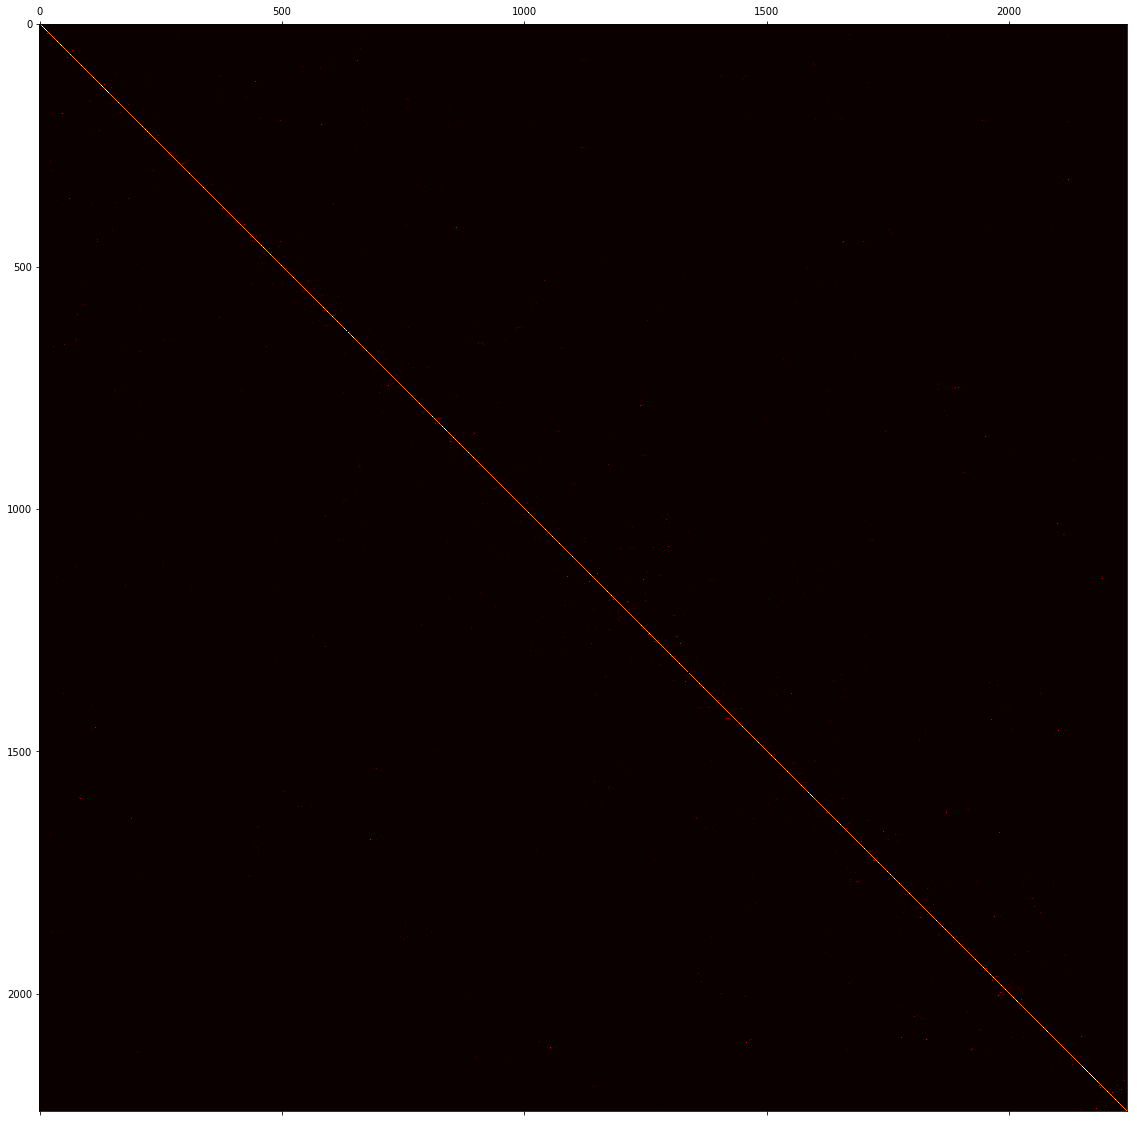

transitivity


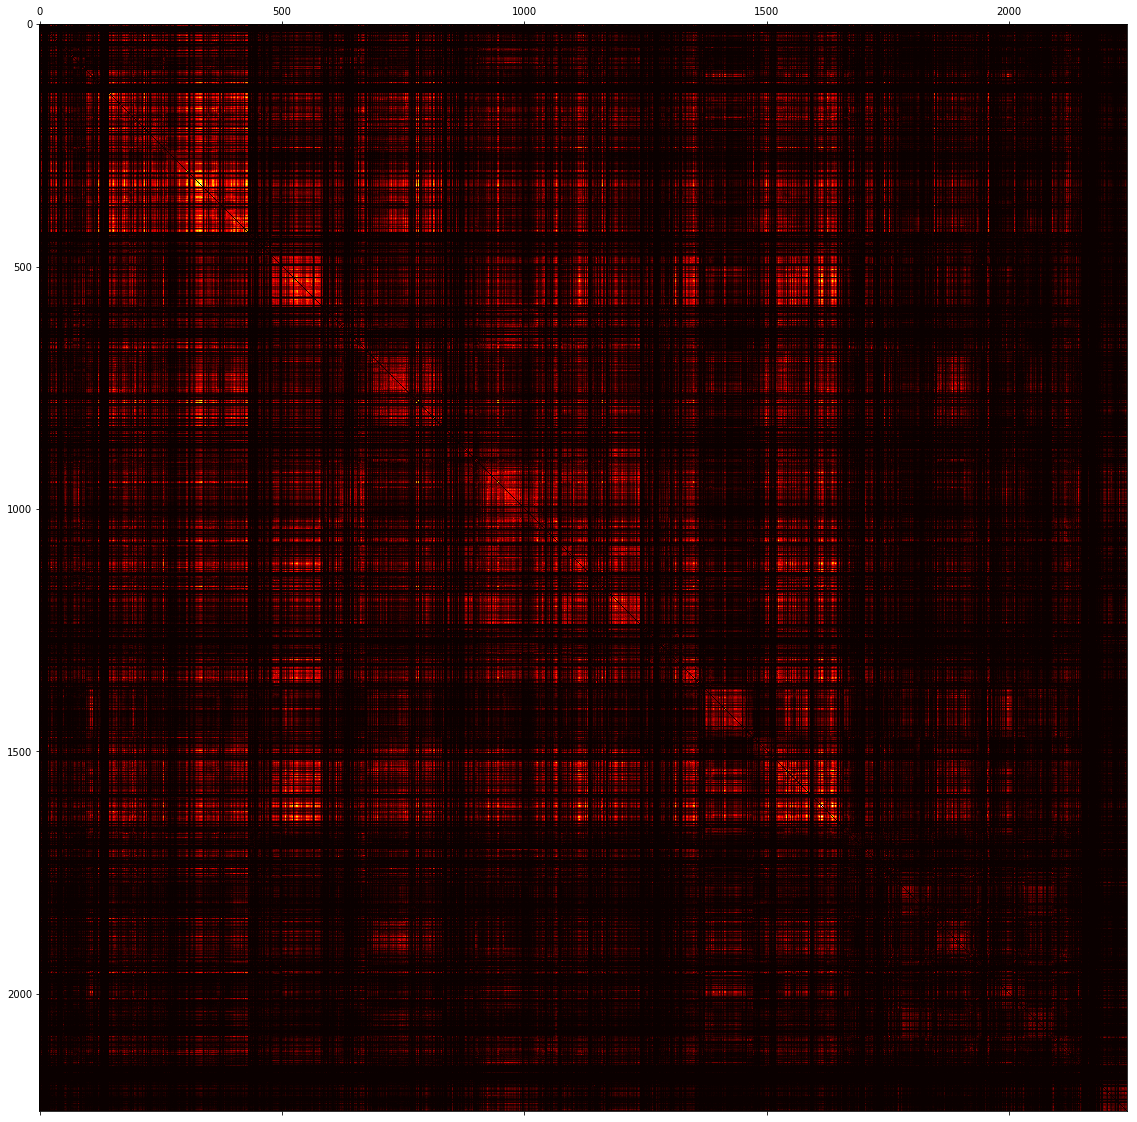

Precision max: 0.4102022336251132
Recall max: 0.6979969183359014
F1 max: 0.5167300380228137
B19


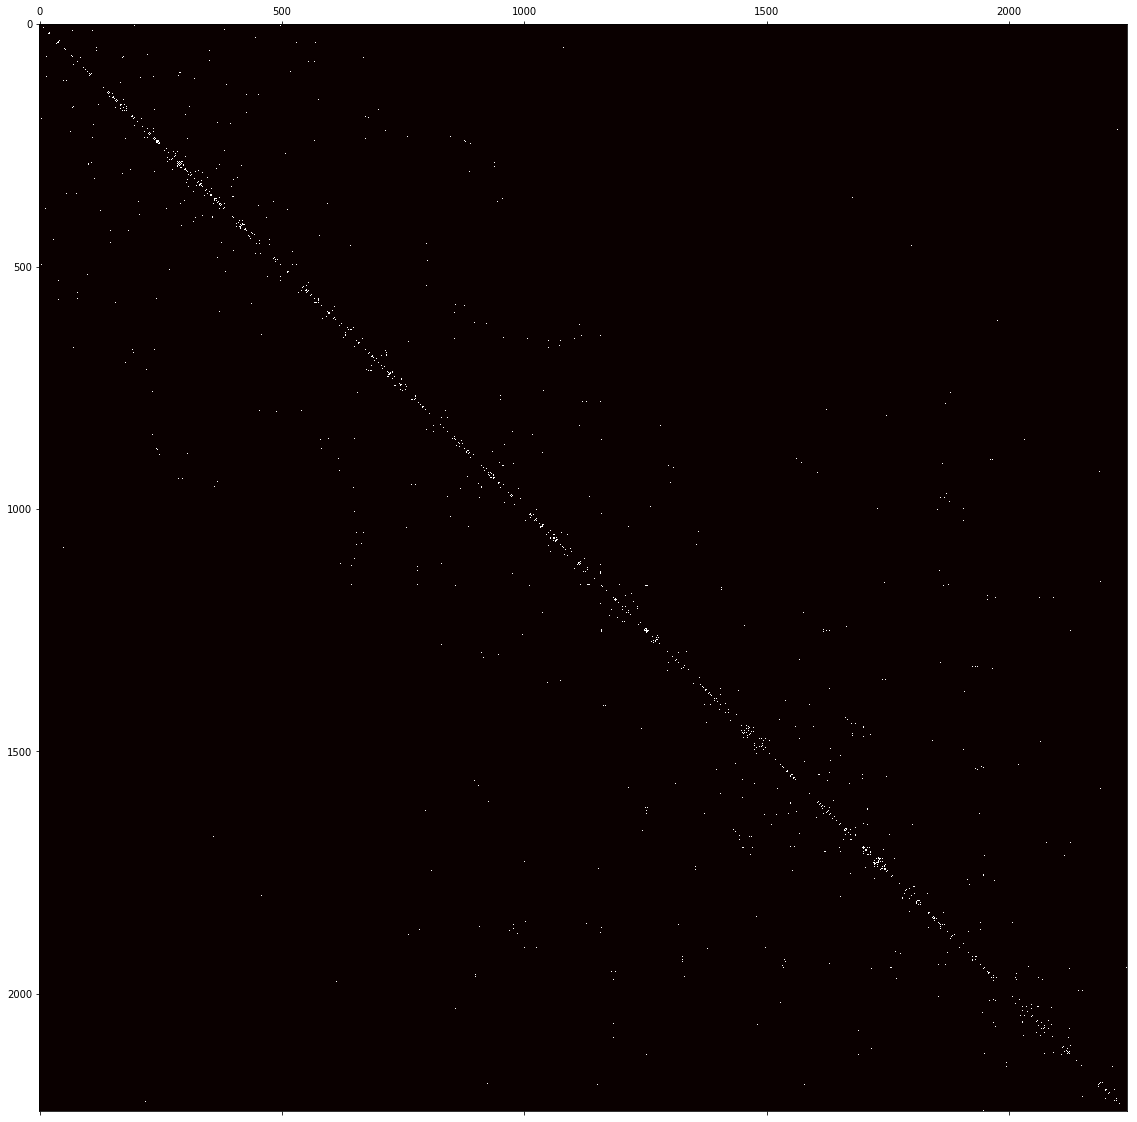

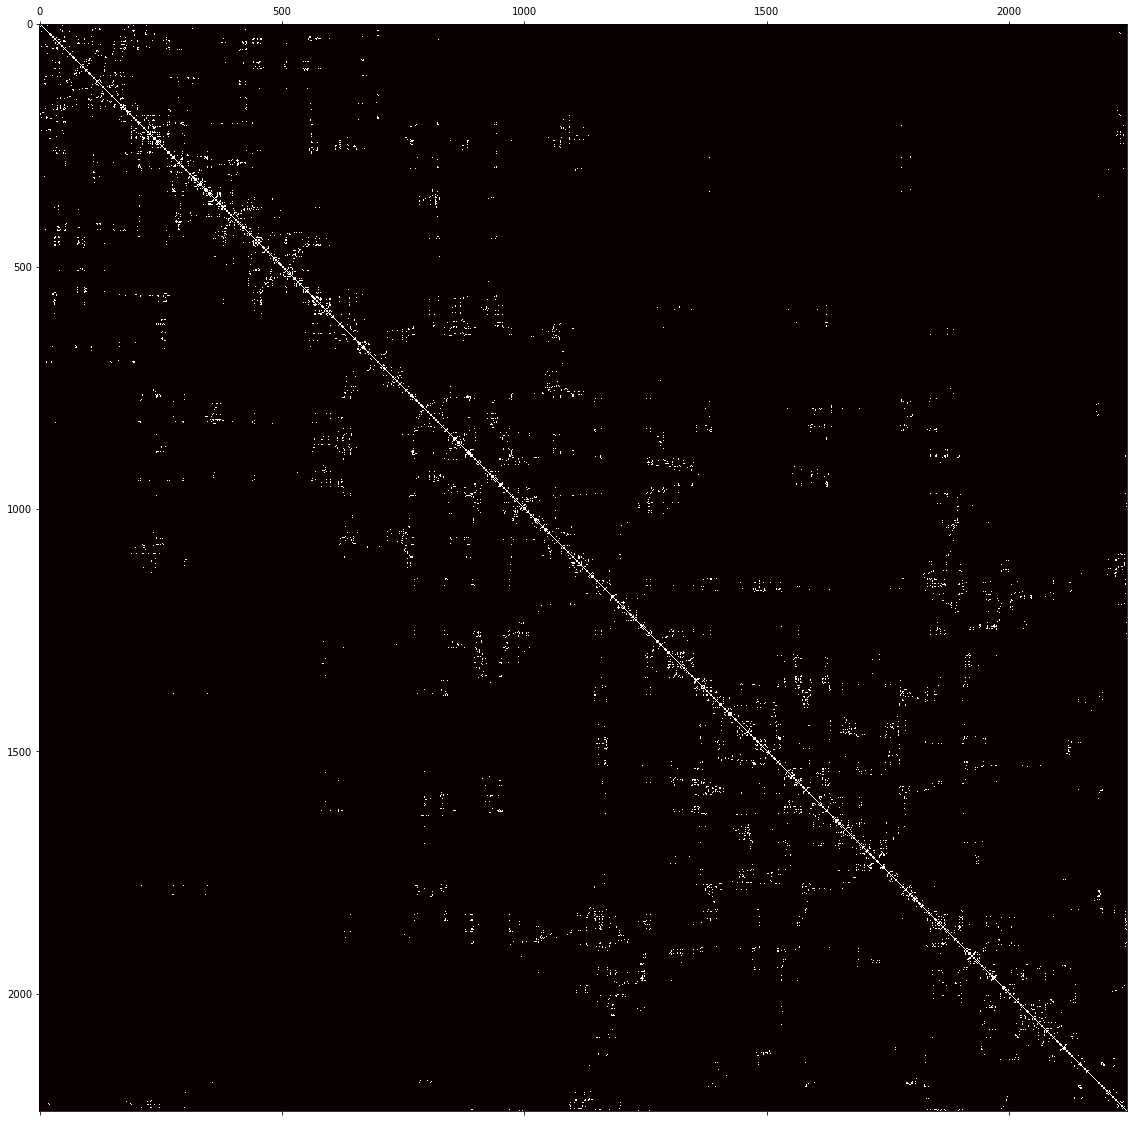

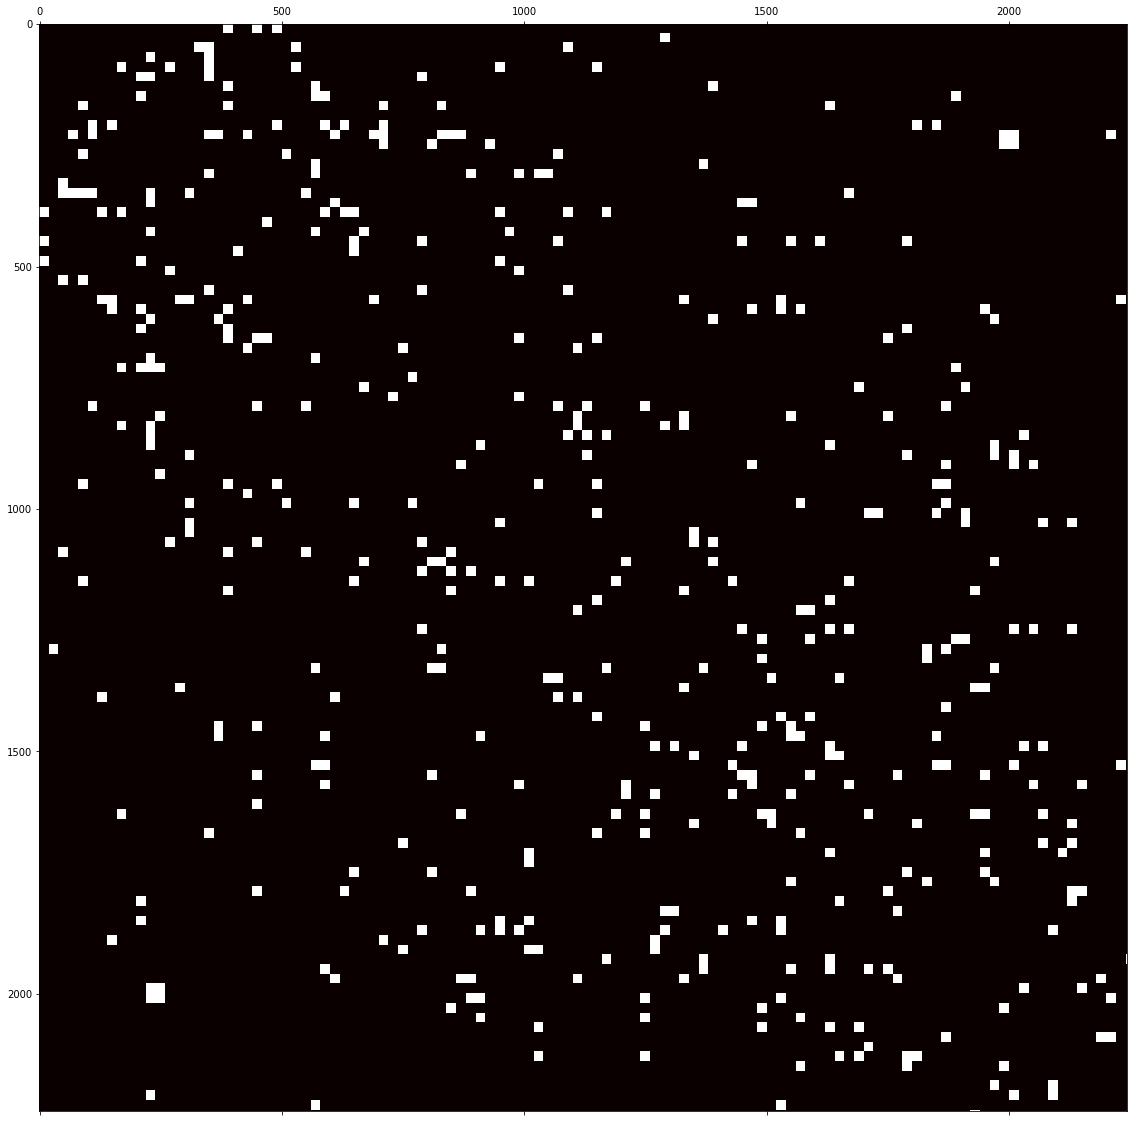

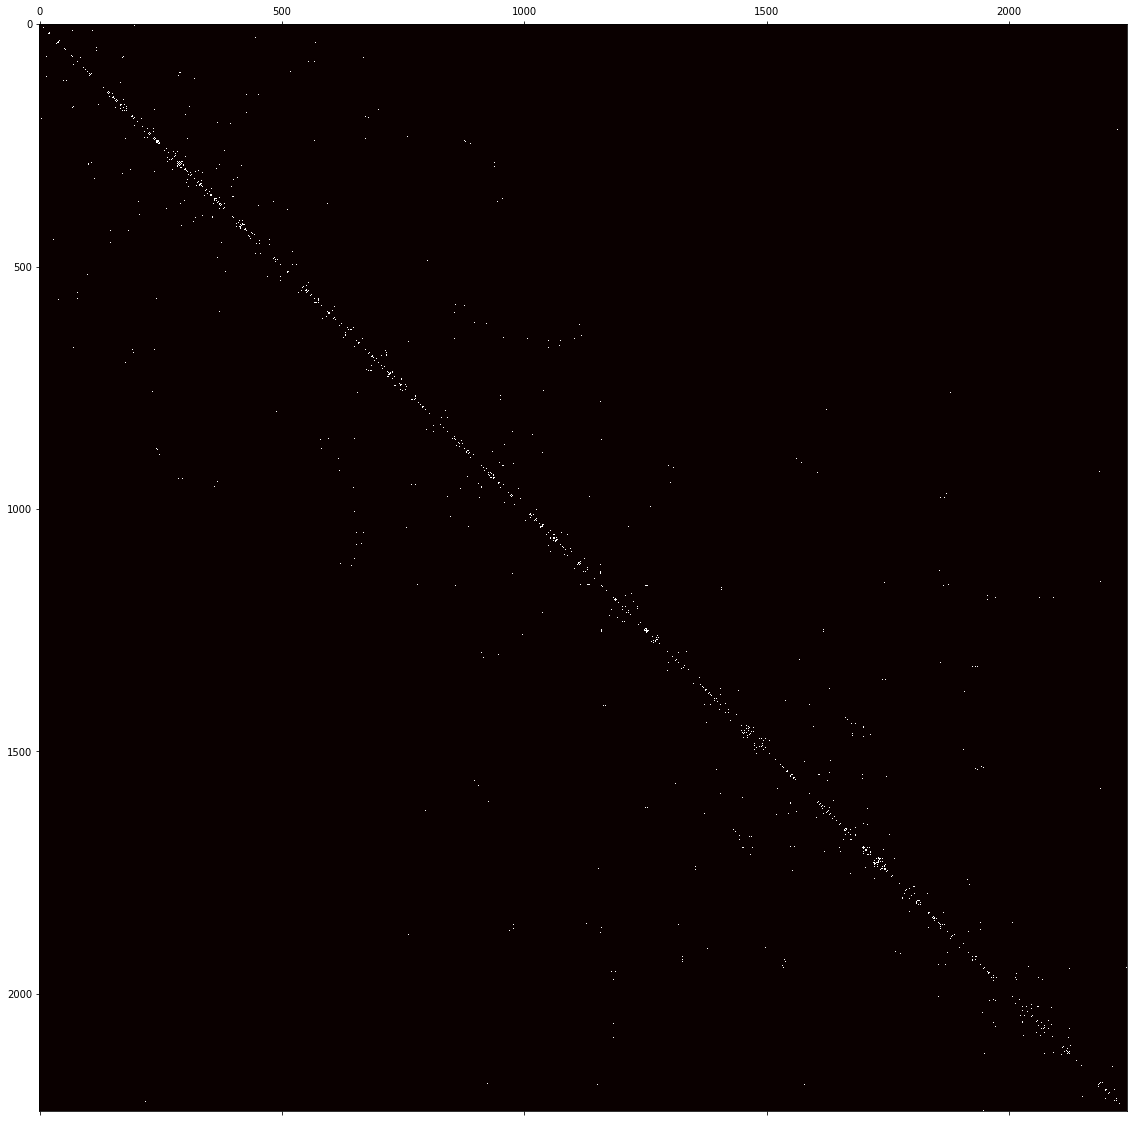

Removed 582 contacts
random walk


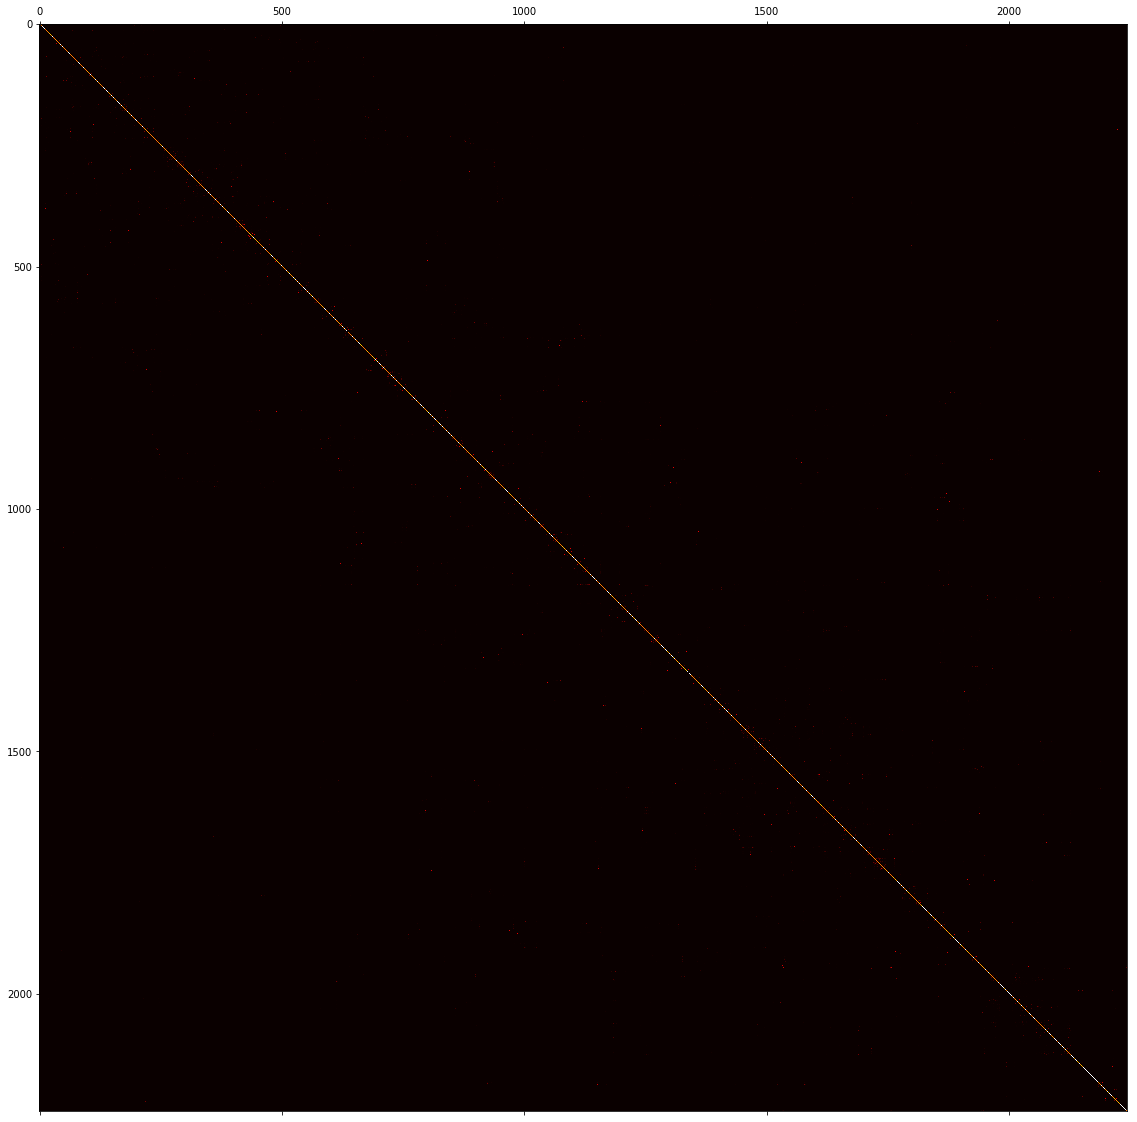

transitivity


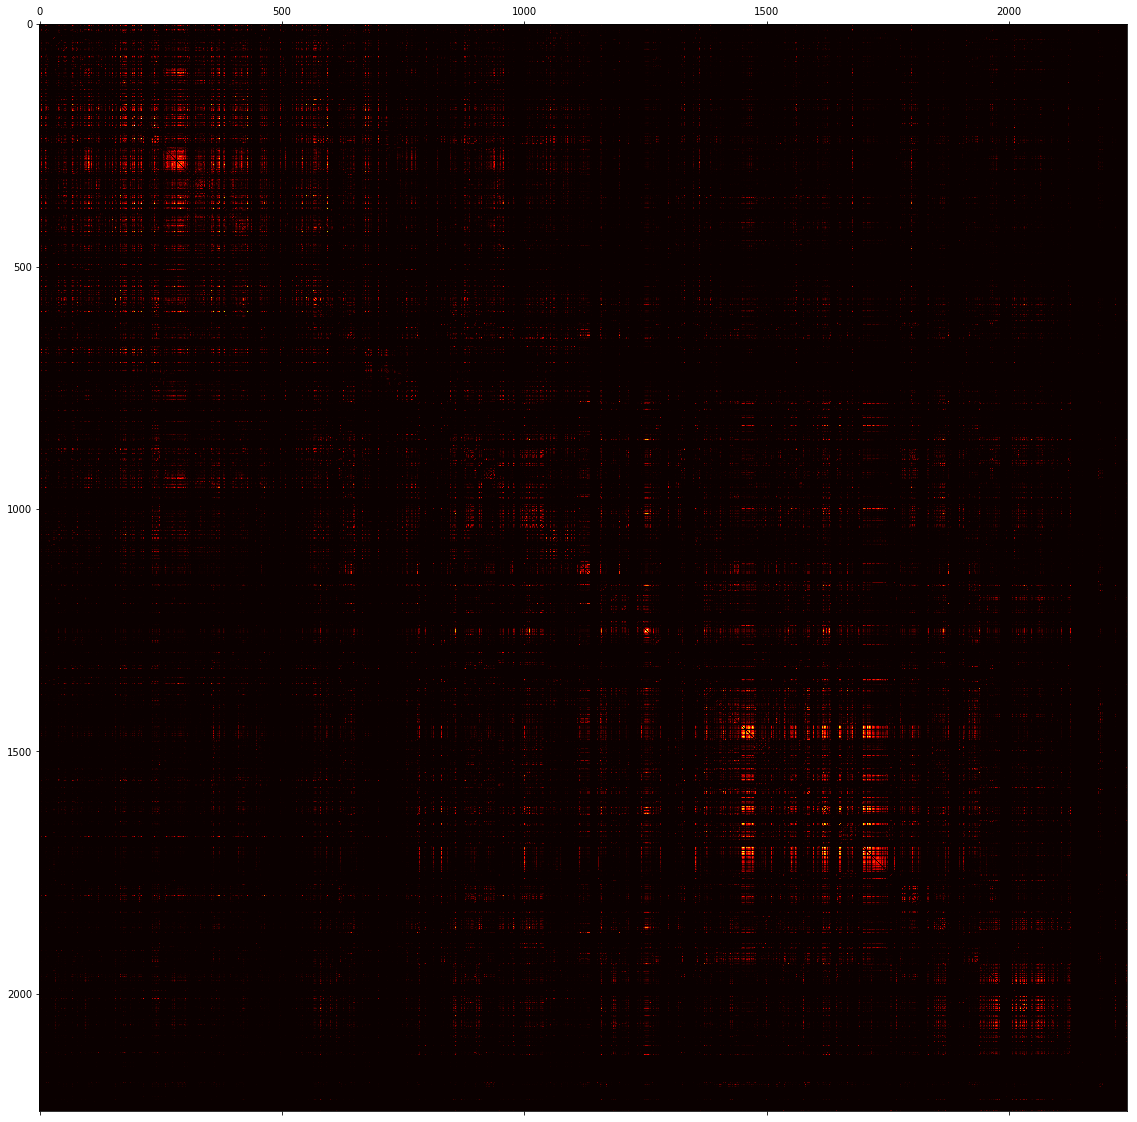

Precision max: 0.3808336302101888
Recall max: 0.6955107351984385
F1 max: 0.4921731123388582
sc24


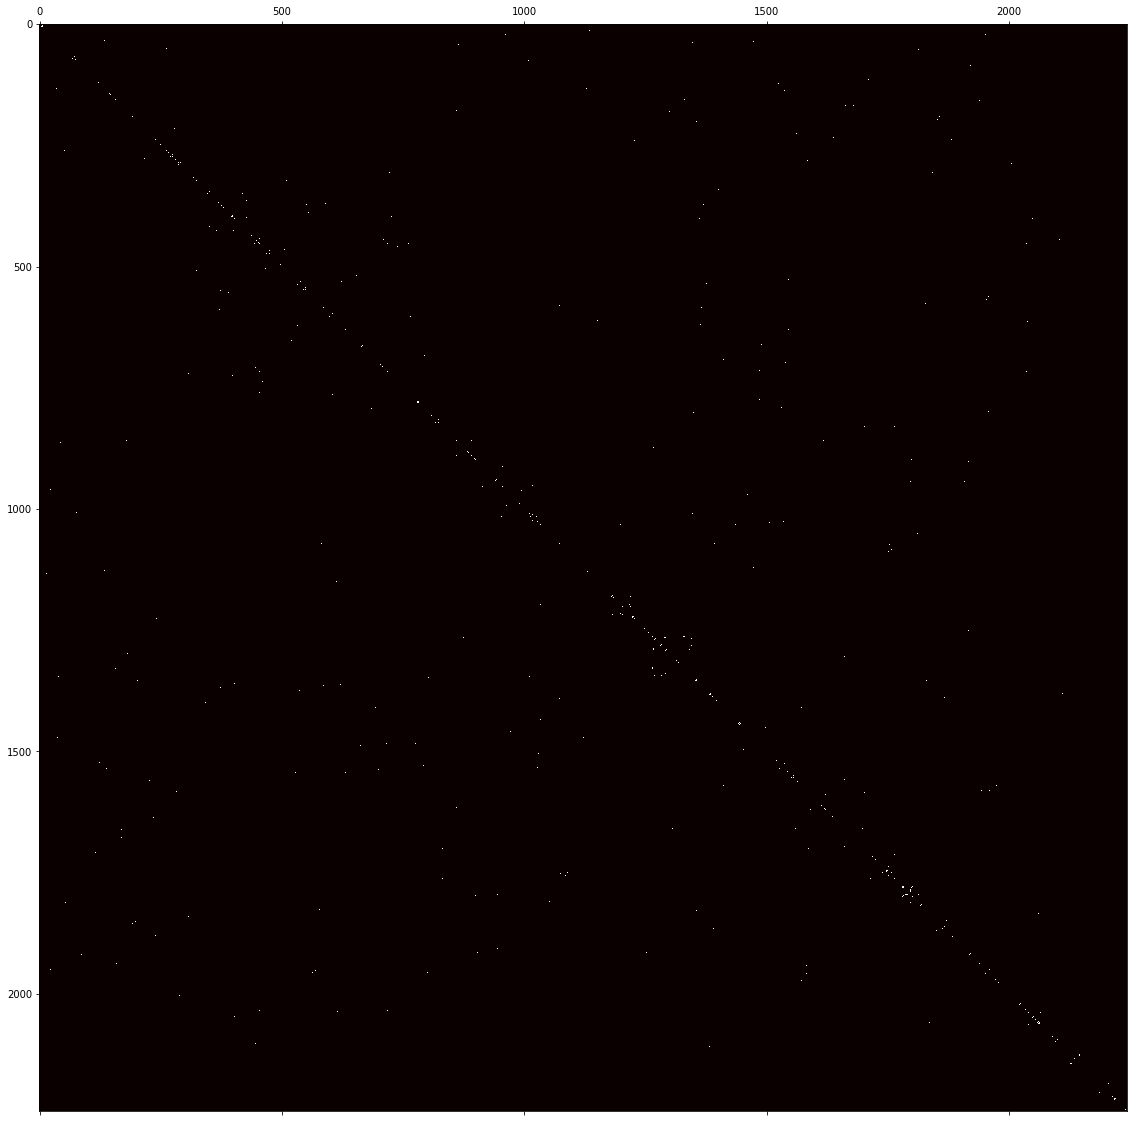

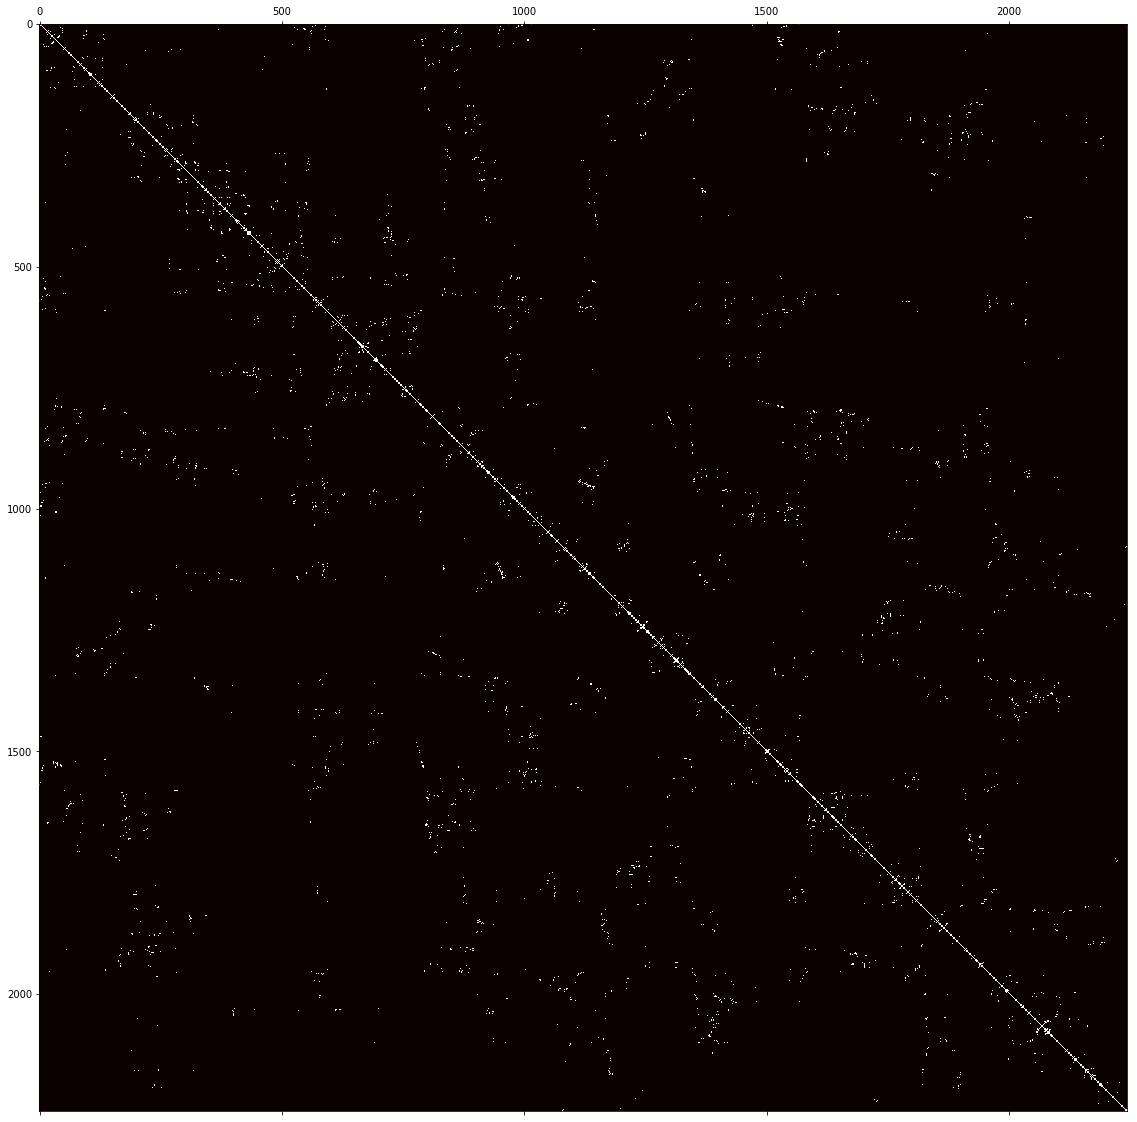

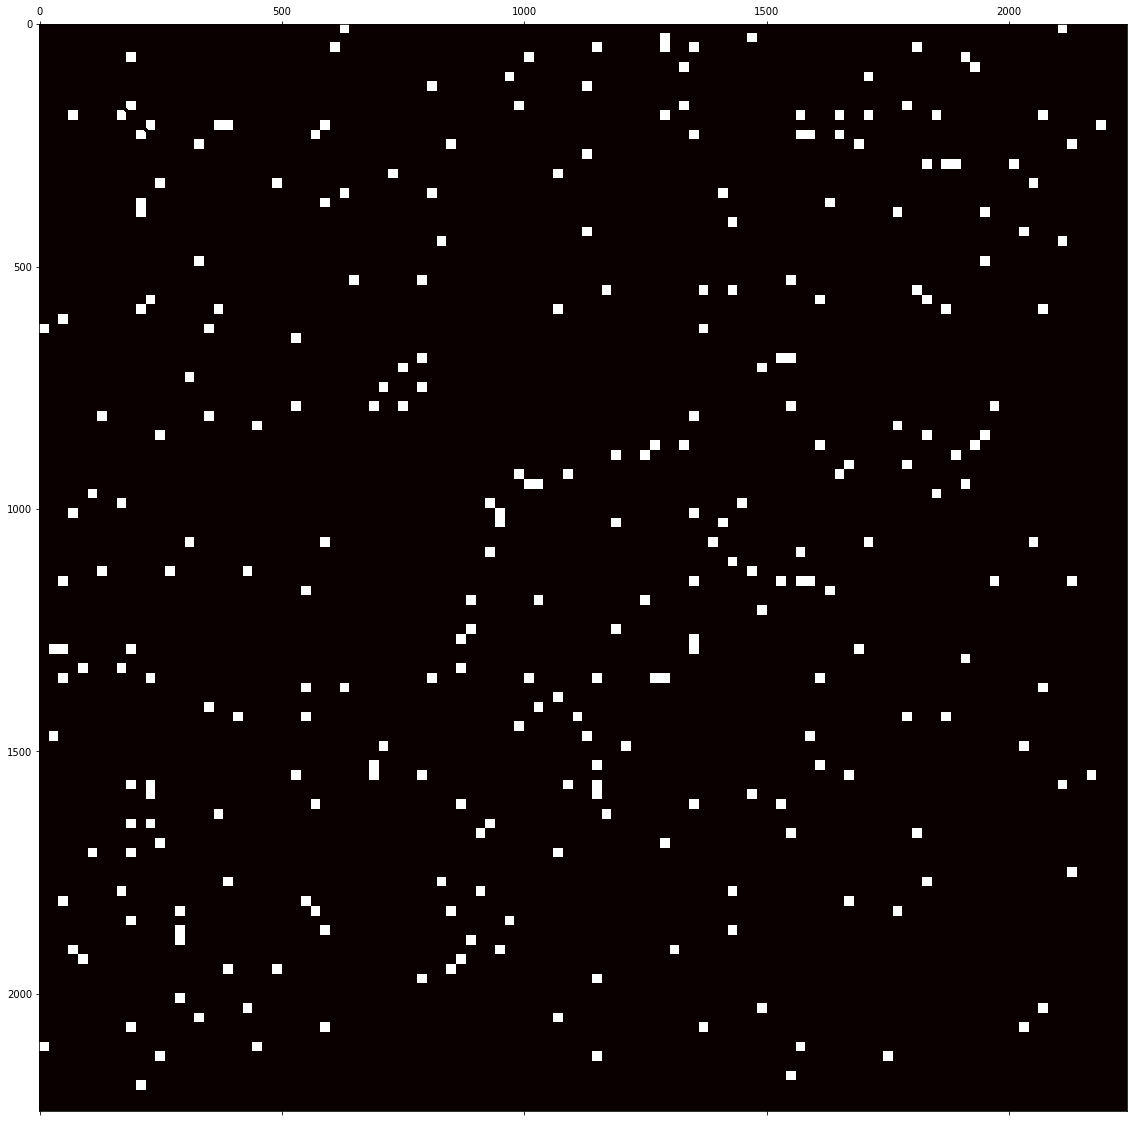

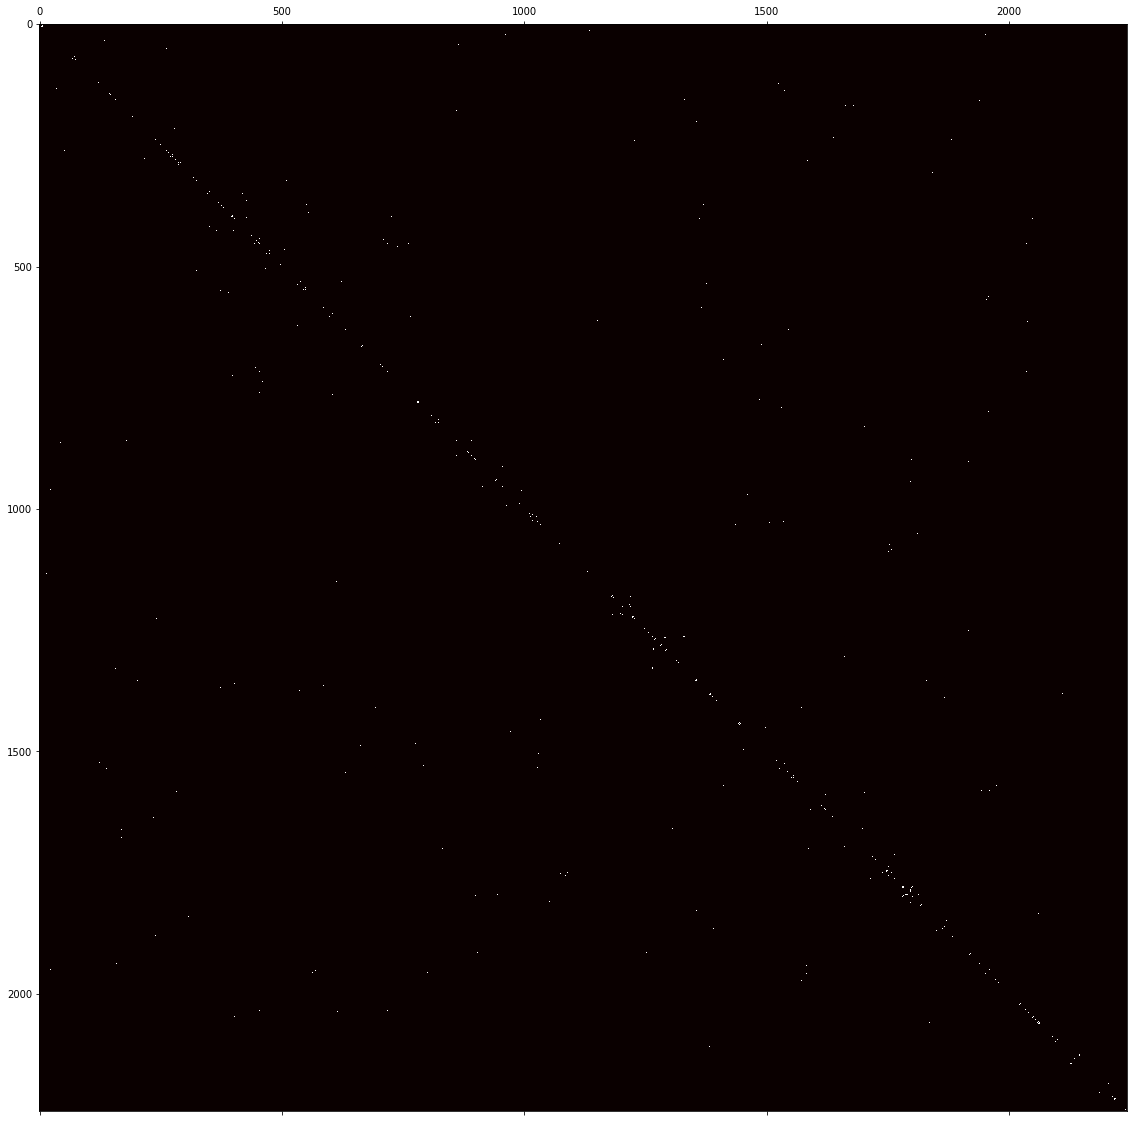

Removed 338 contacts
random walk


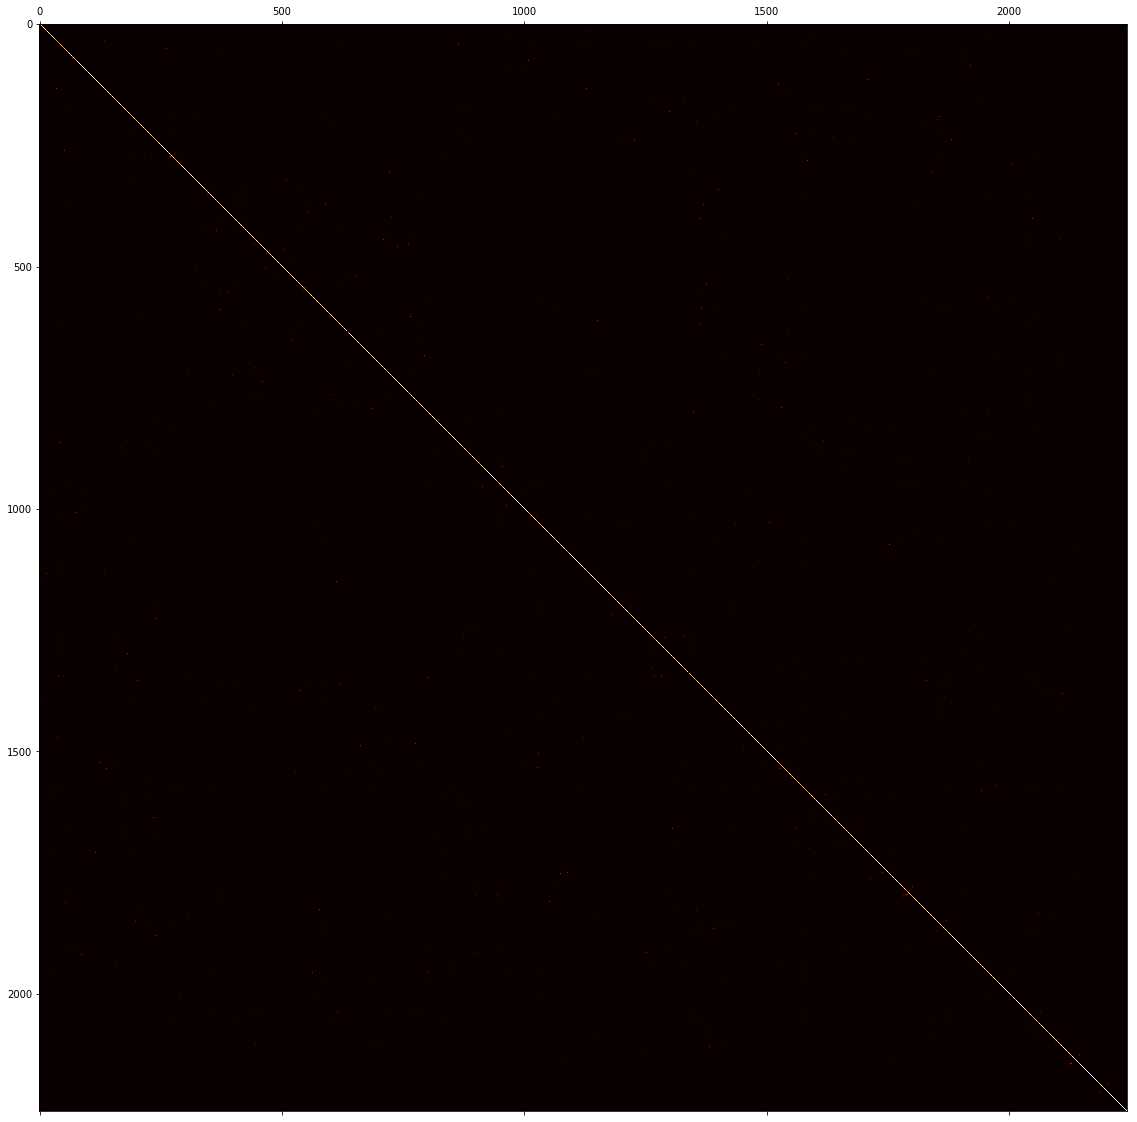

transitivity


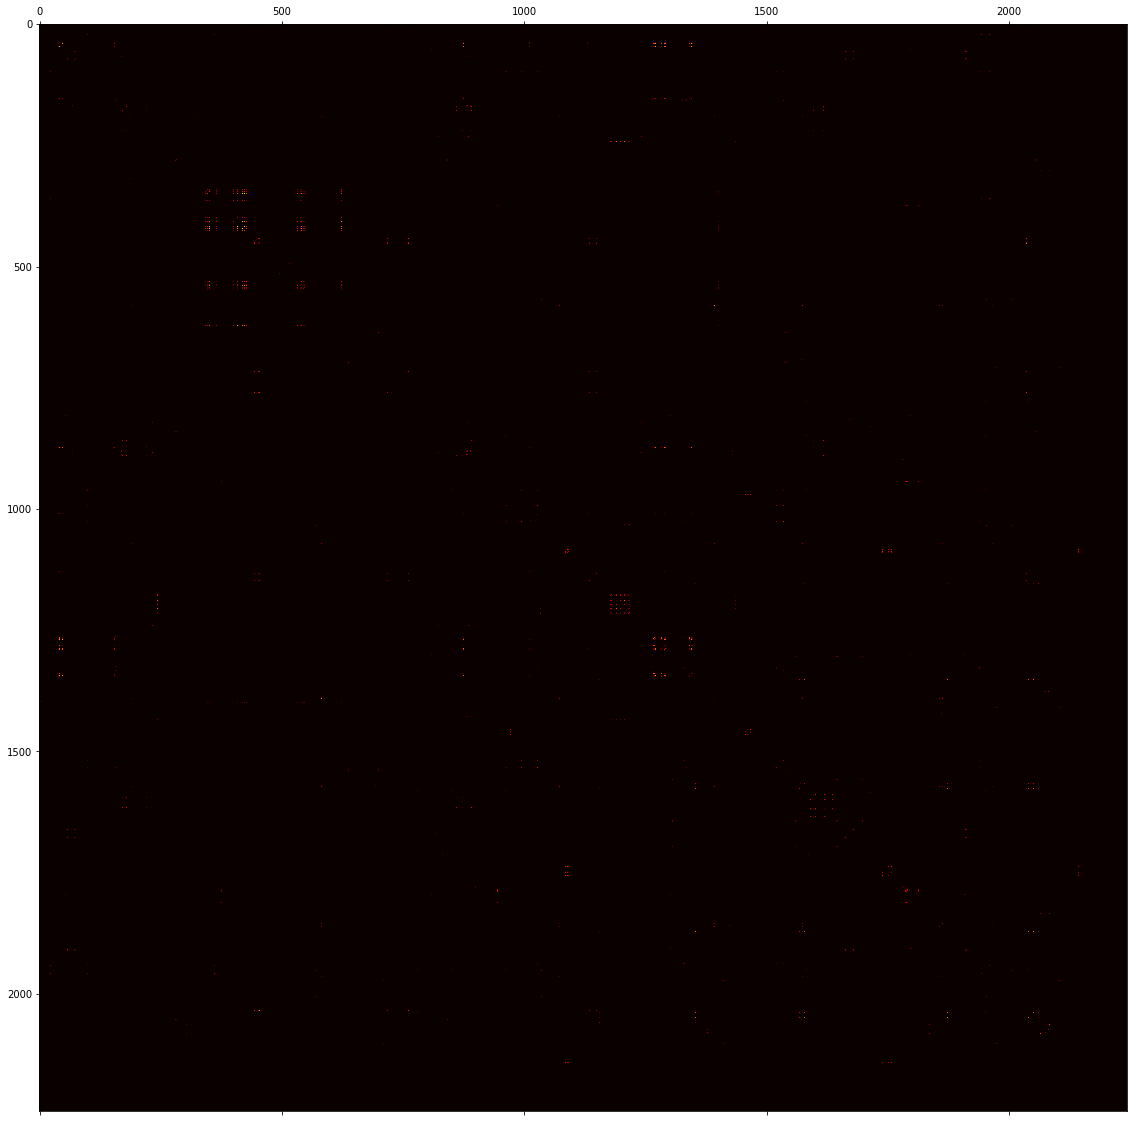

Precision max: 0.22937853107344633
Recall max: 0.6819708846584547
F1 max: 0.3432919954904171
A5


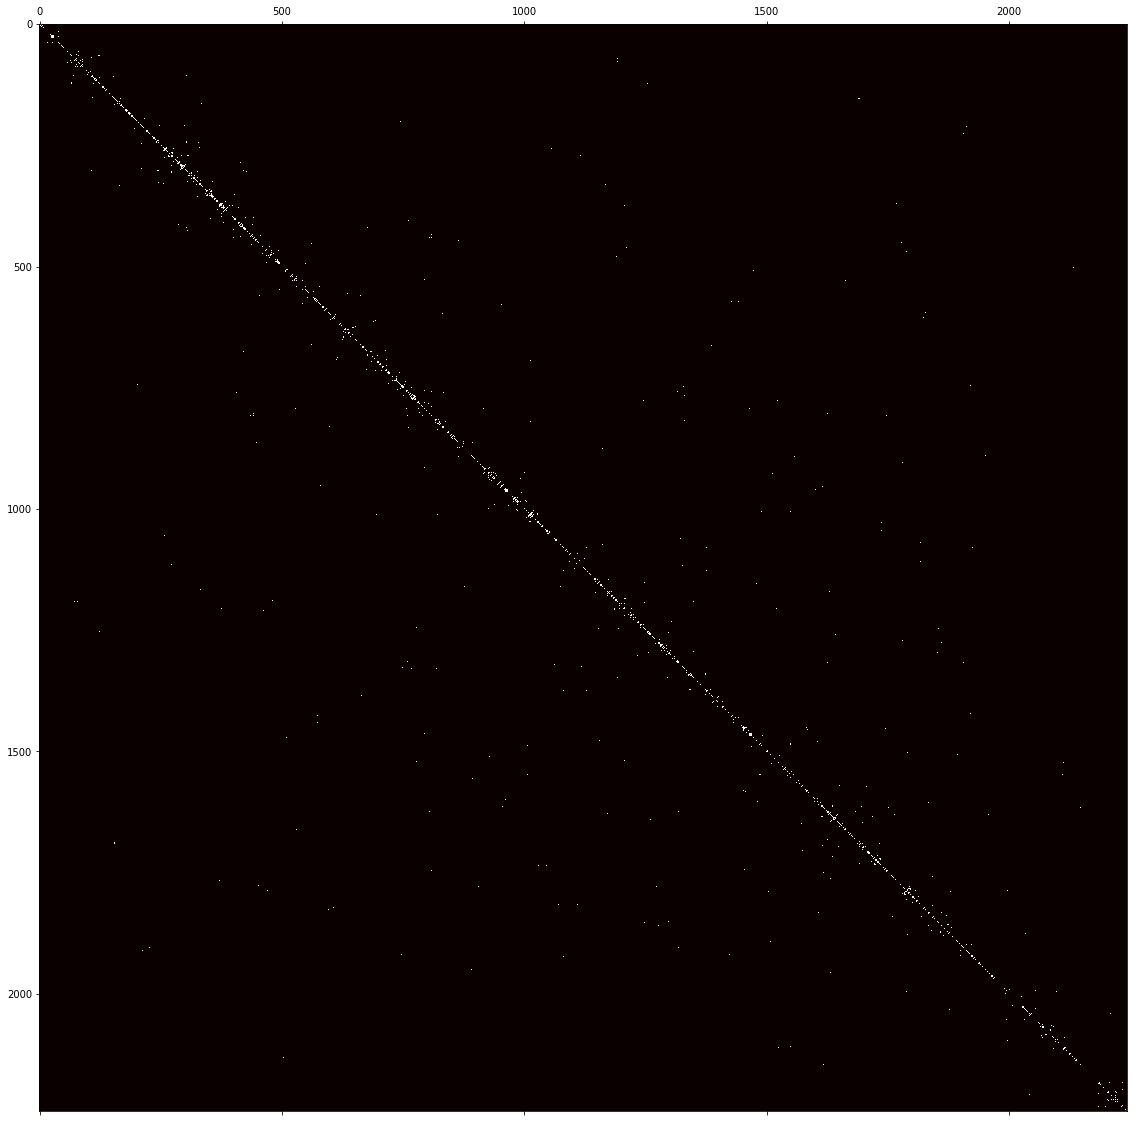

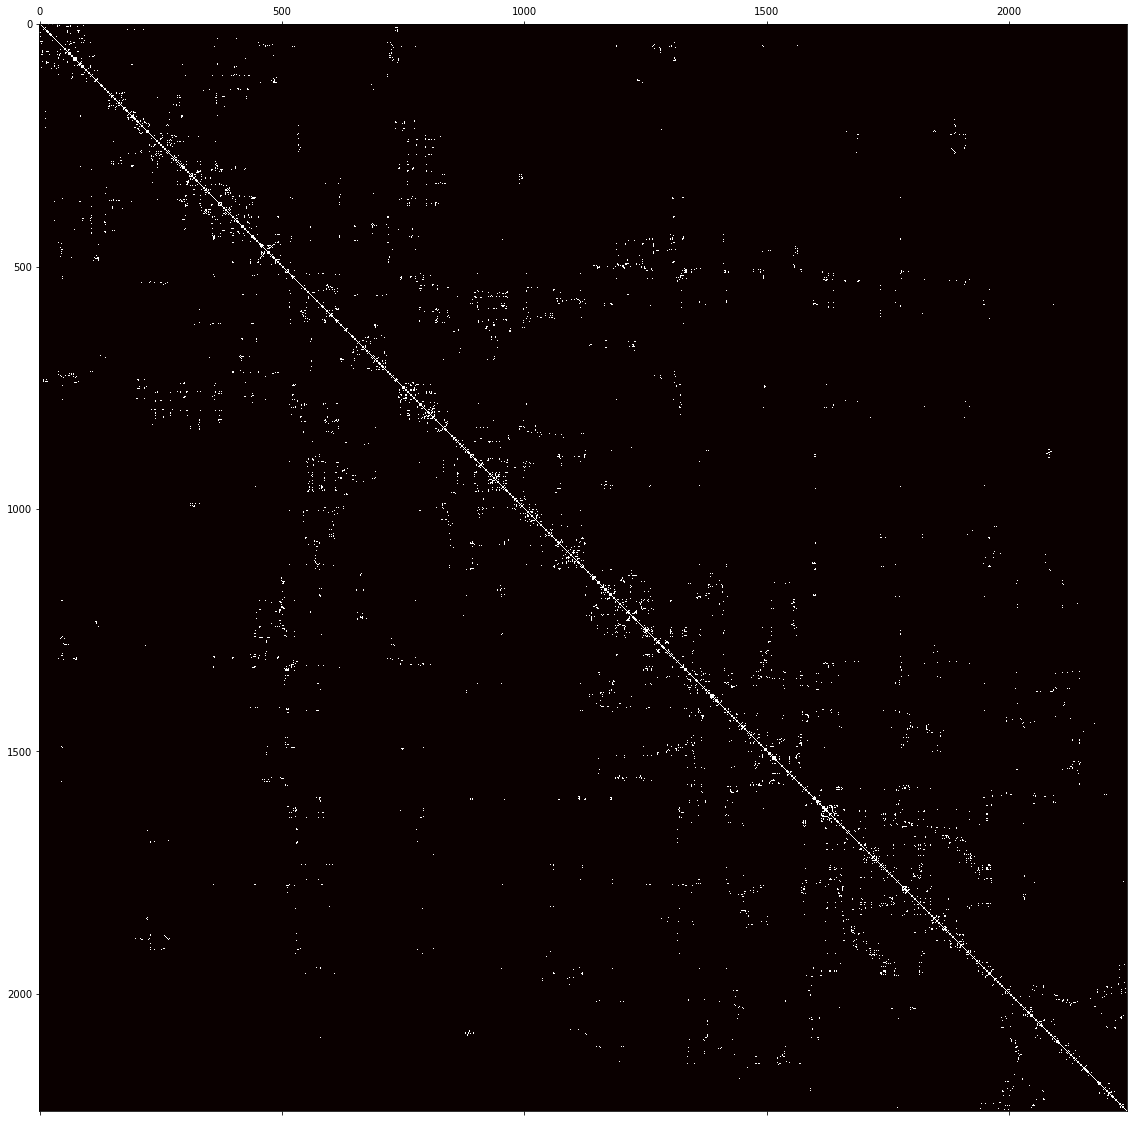

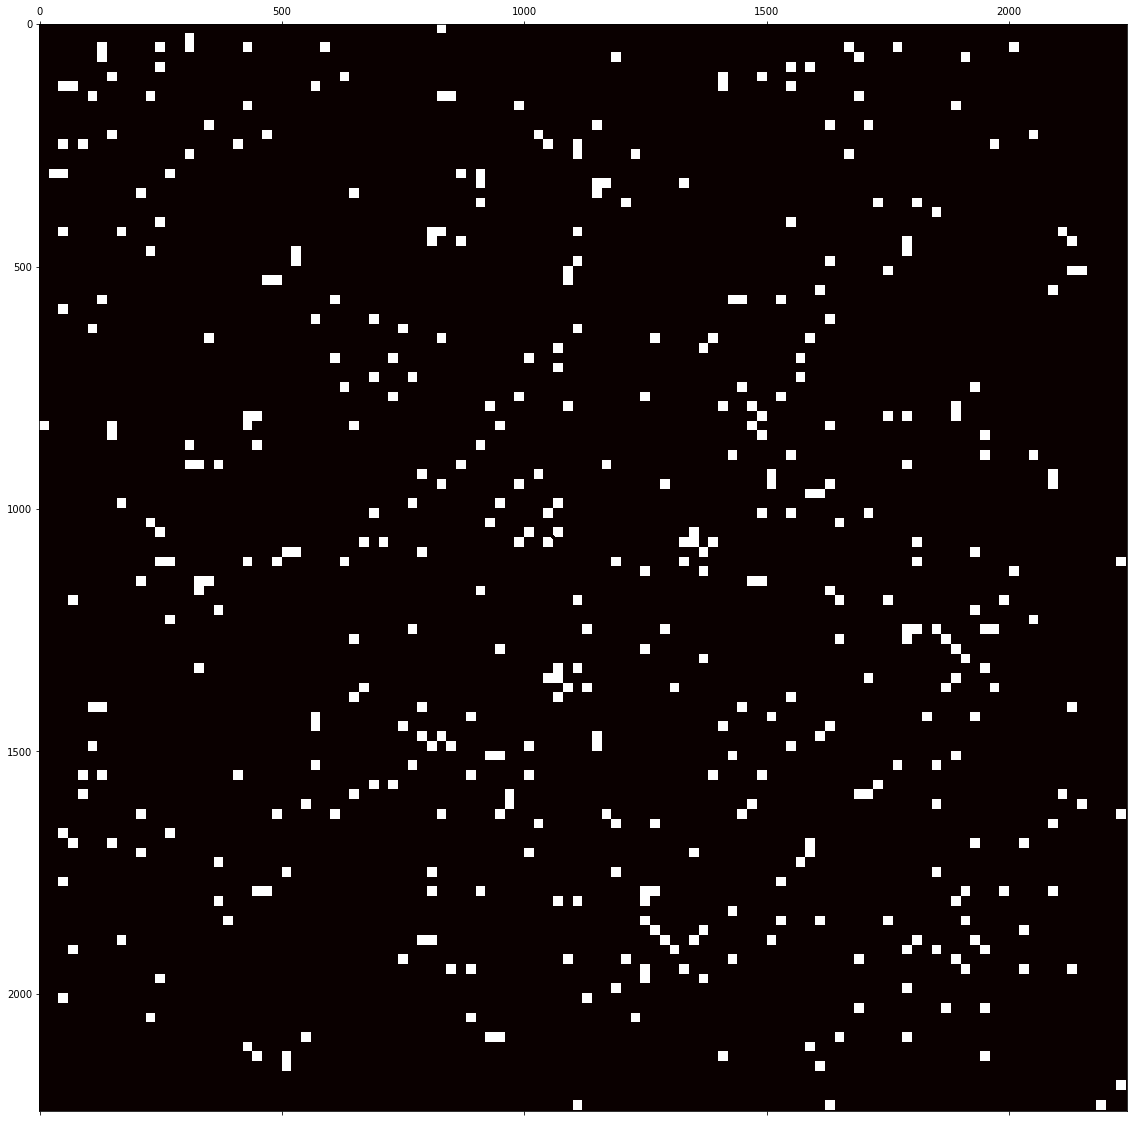

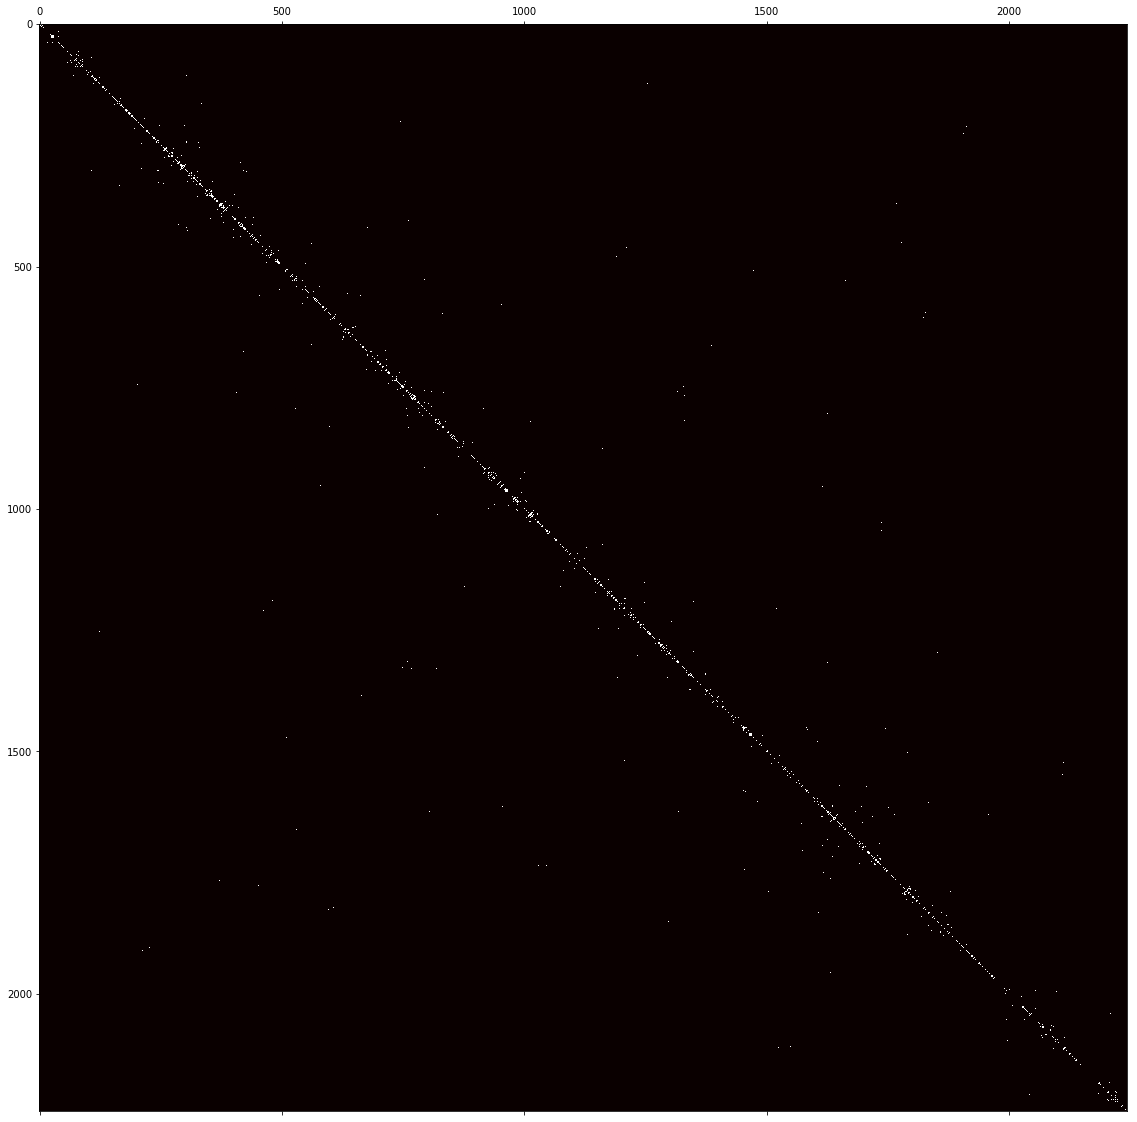

Removed 546 contacts
random walk


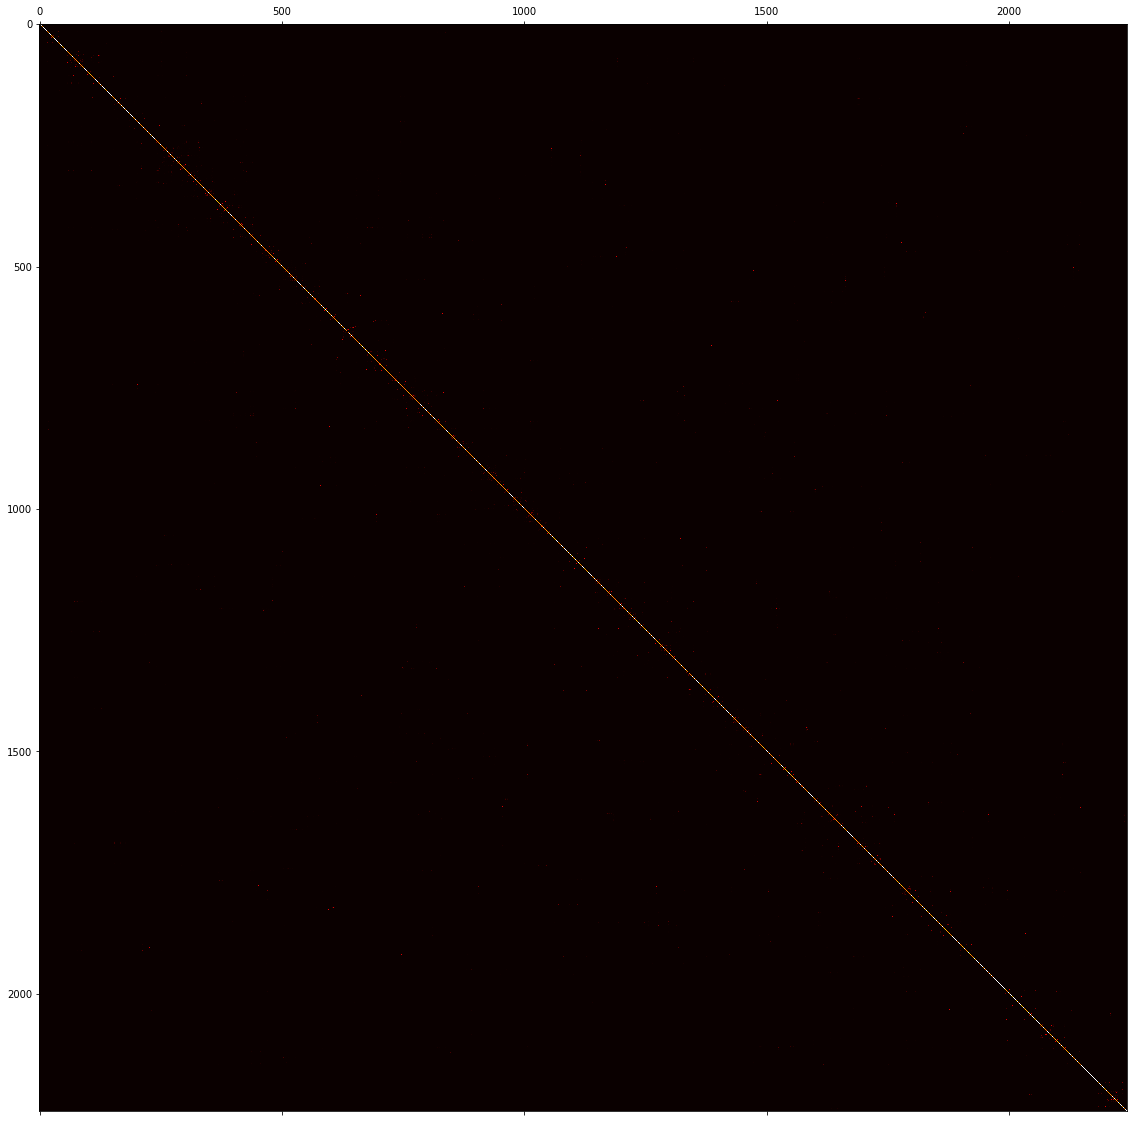

transitivity


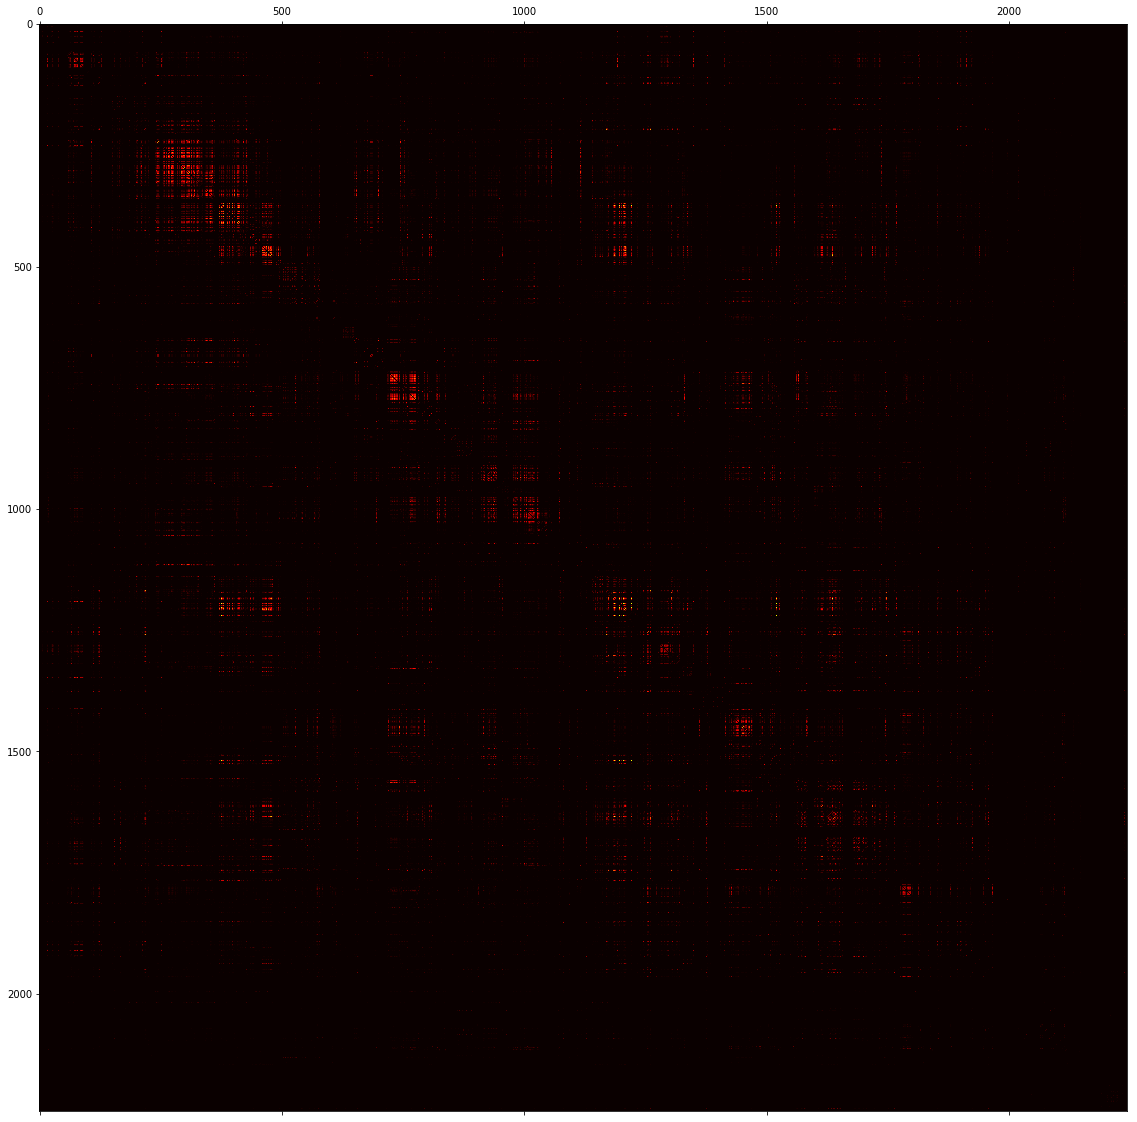

Precision max: 0.29323044545773413
Recall max: 0.6593059936908517
F1 max: 0.40592376790483126
A2


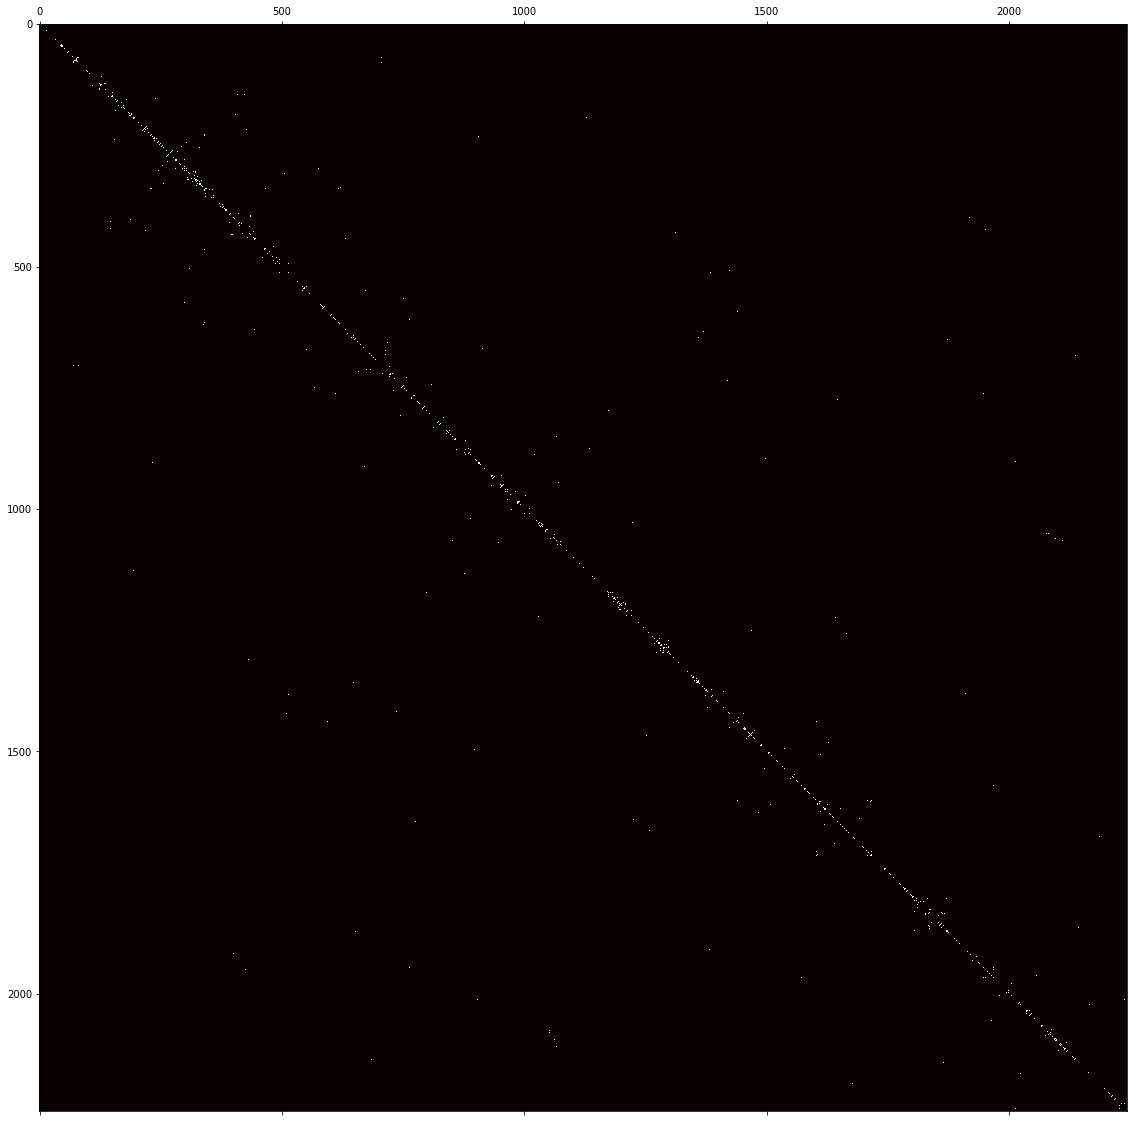

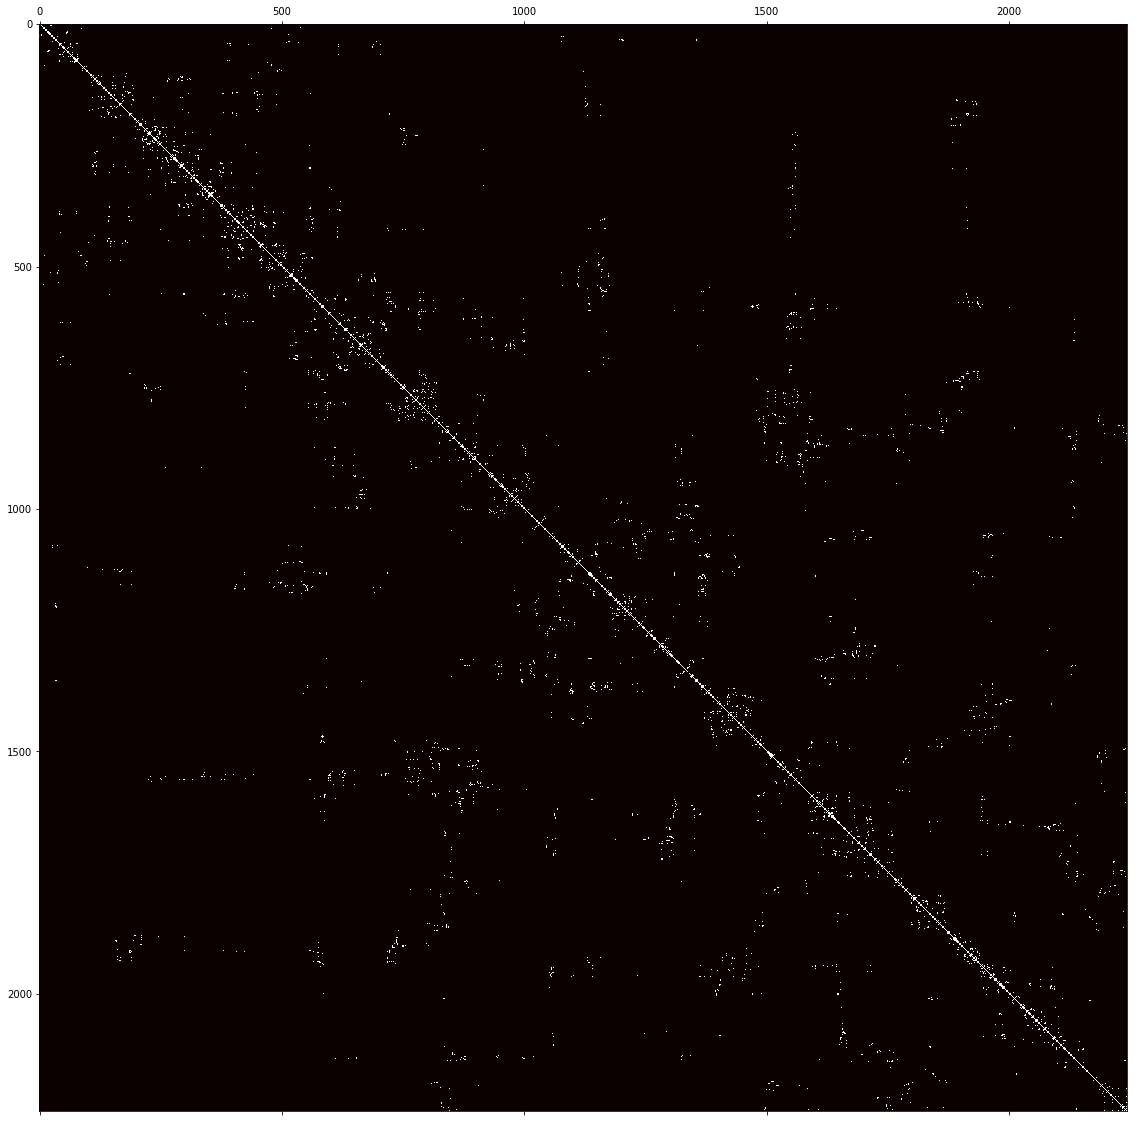

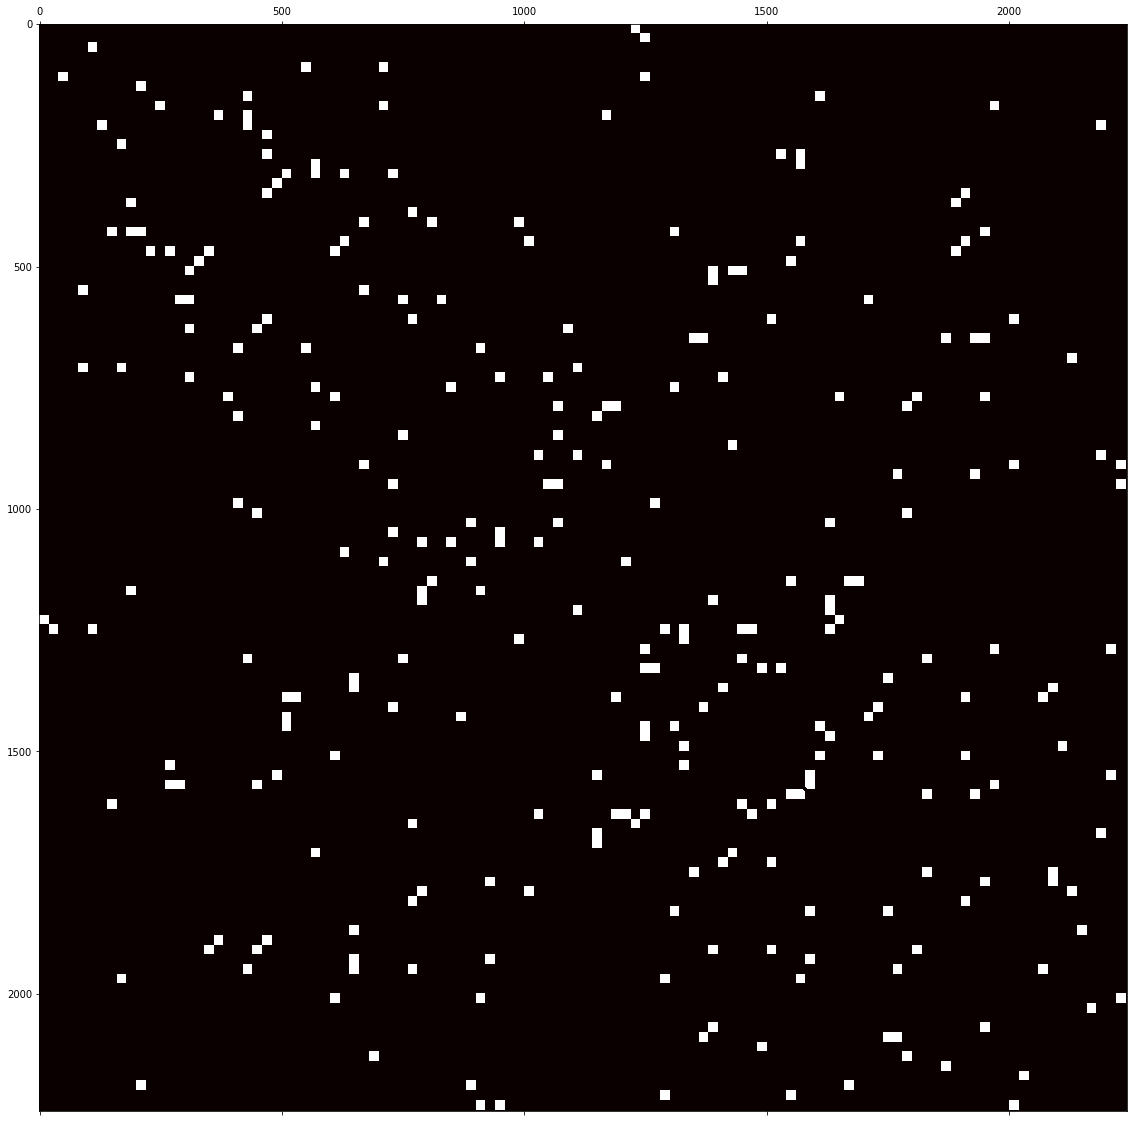

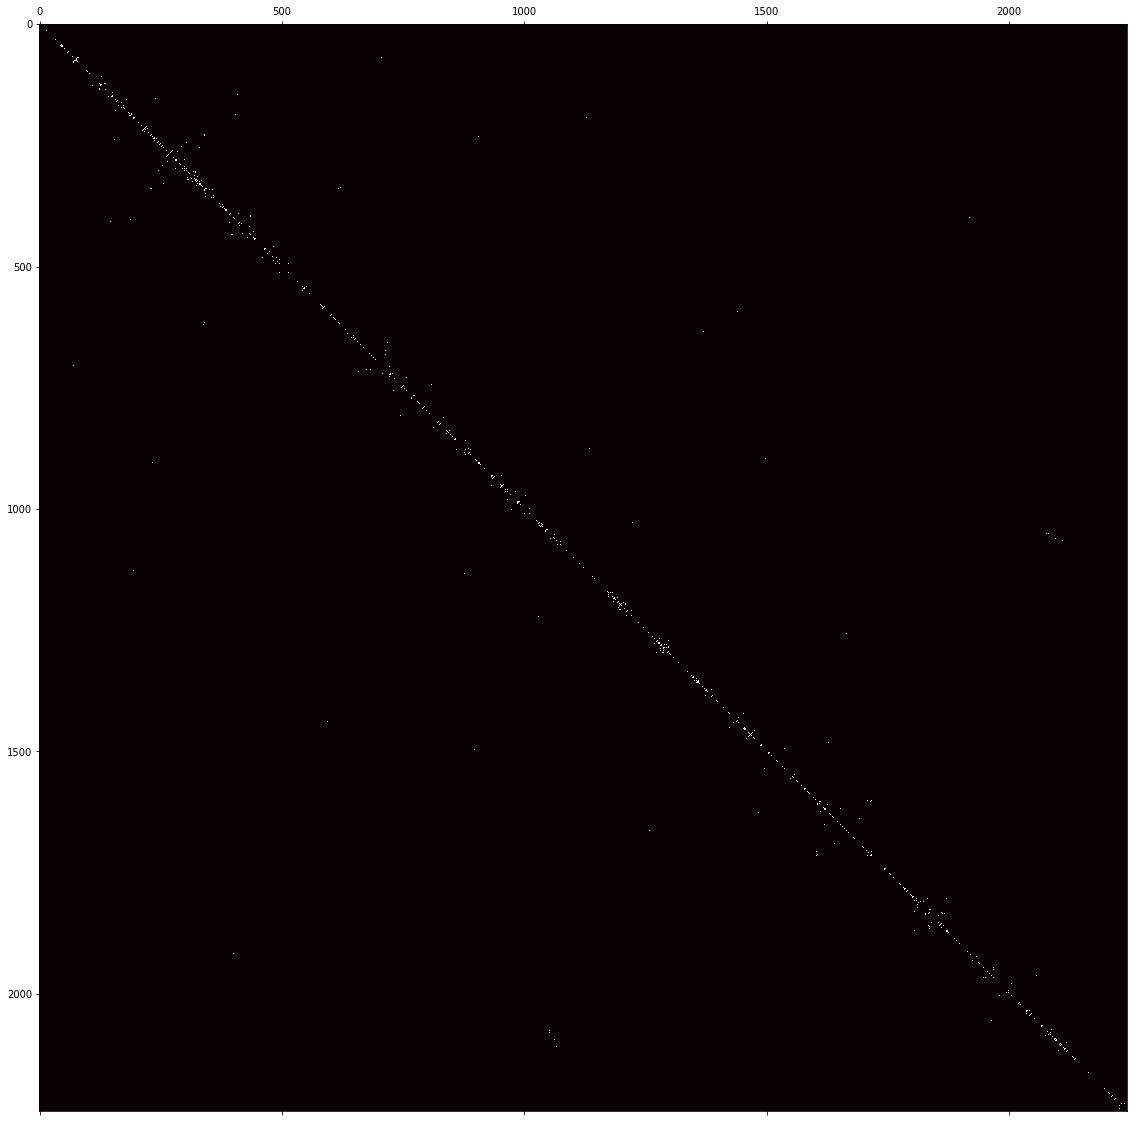

Removed 364 contacts
random walk


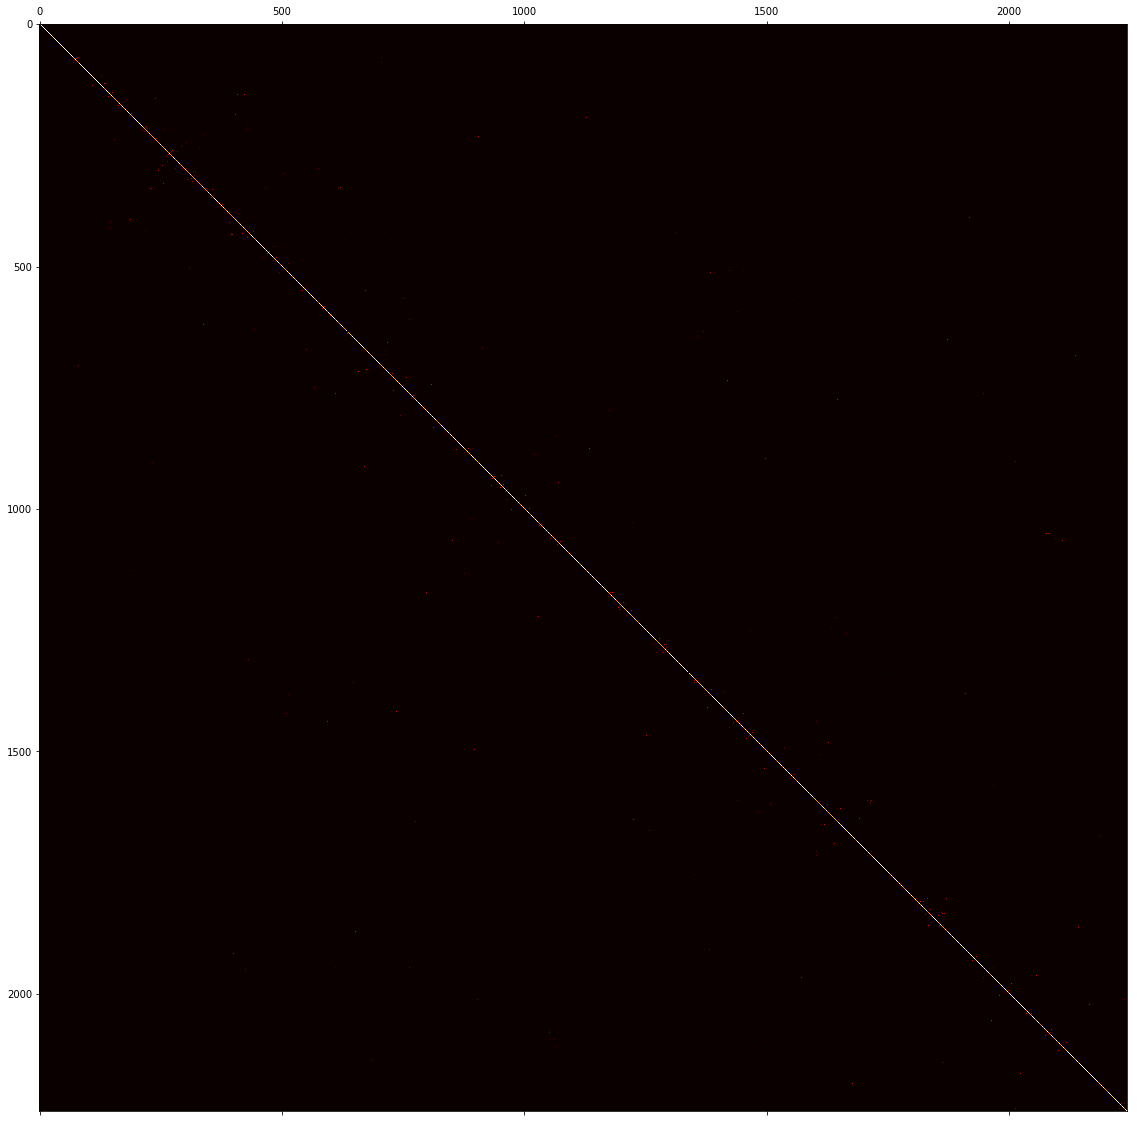

transitivity


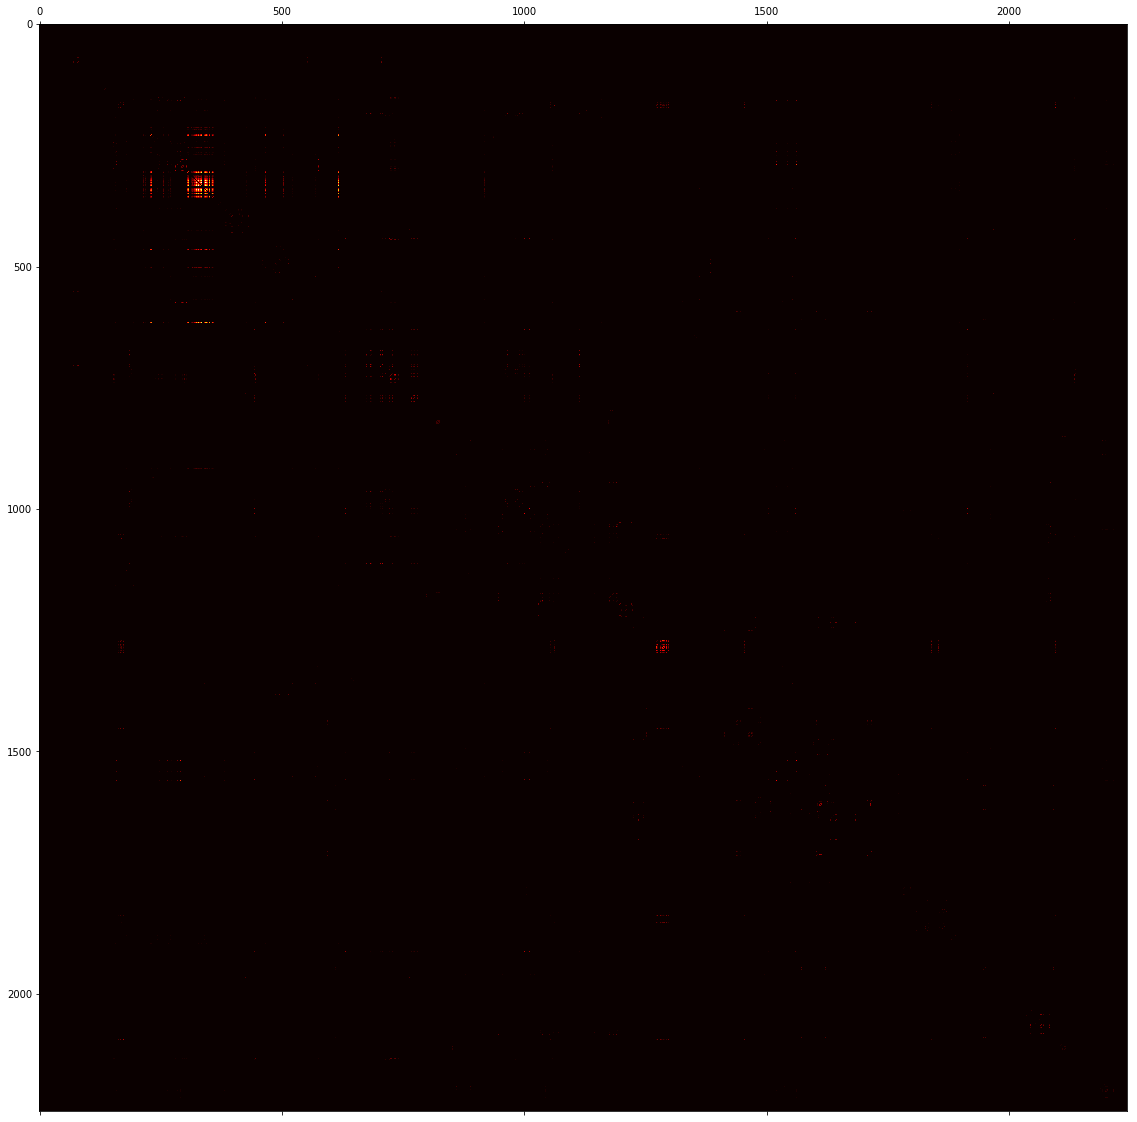

Precision max: 0.21914981427981842
Recall max: 0.6483516483516484
F1 max: 0.32757557063541026
sc16


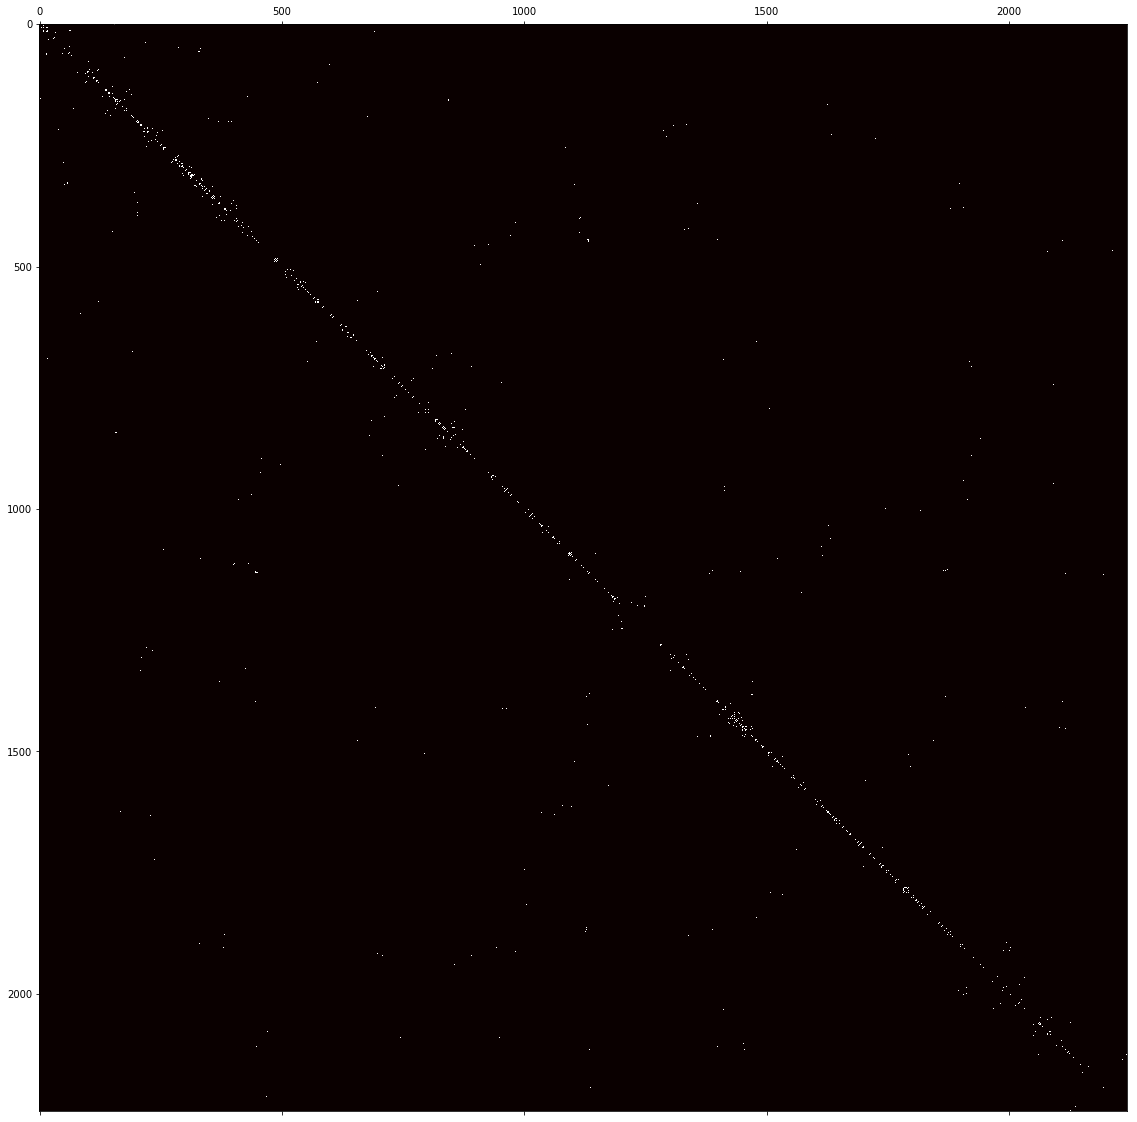

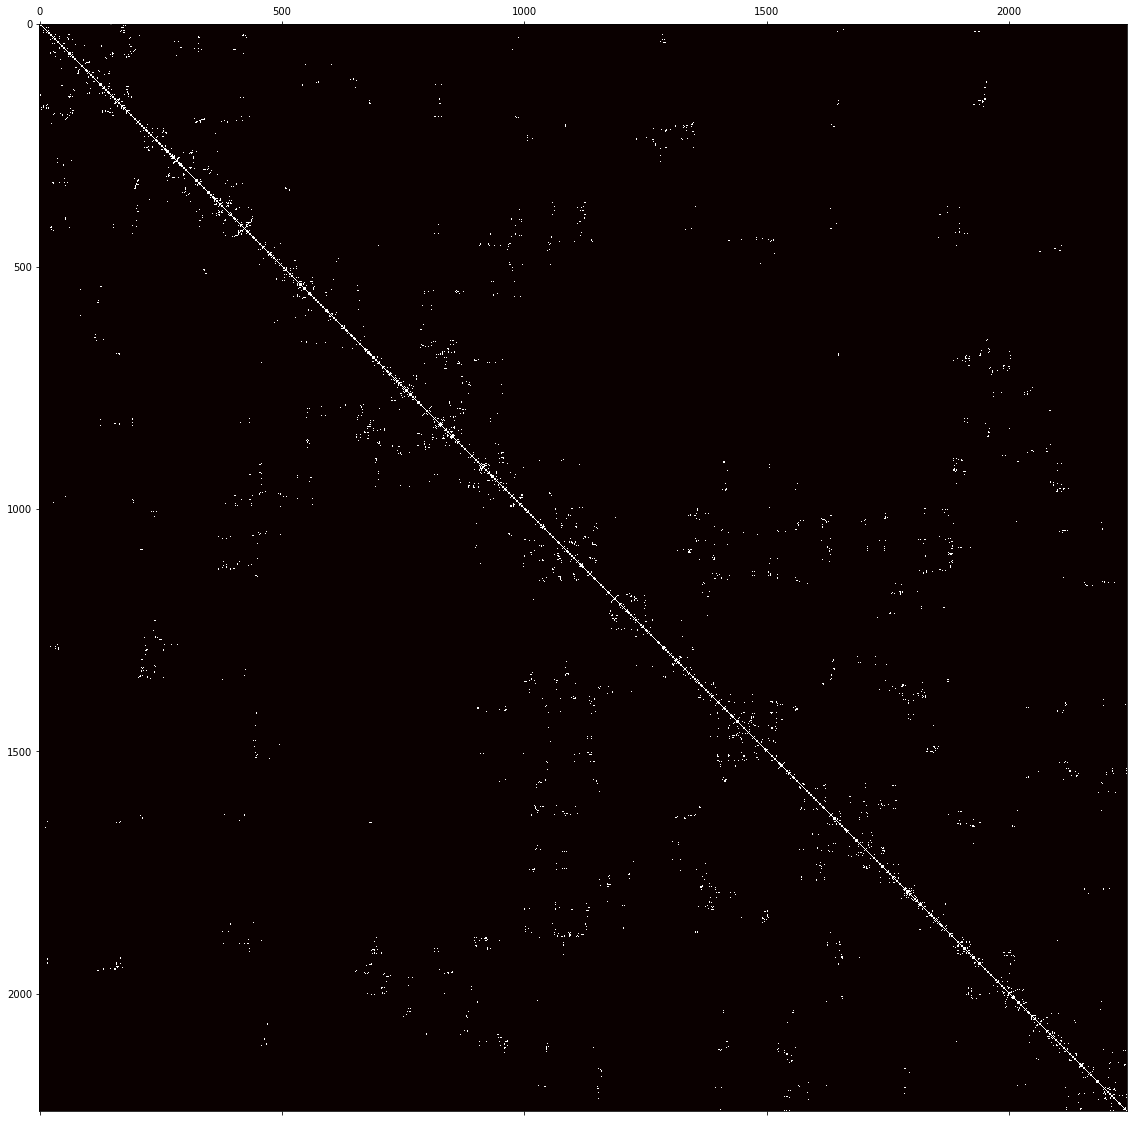

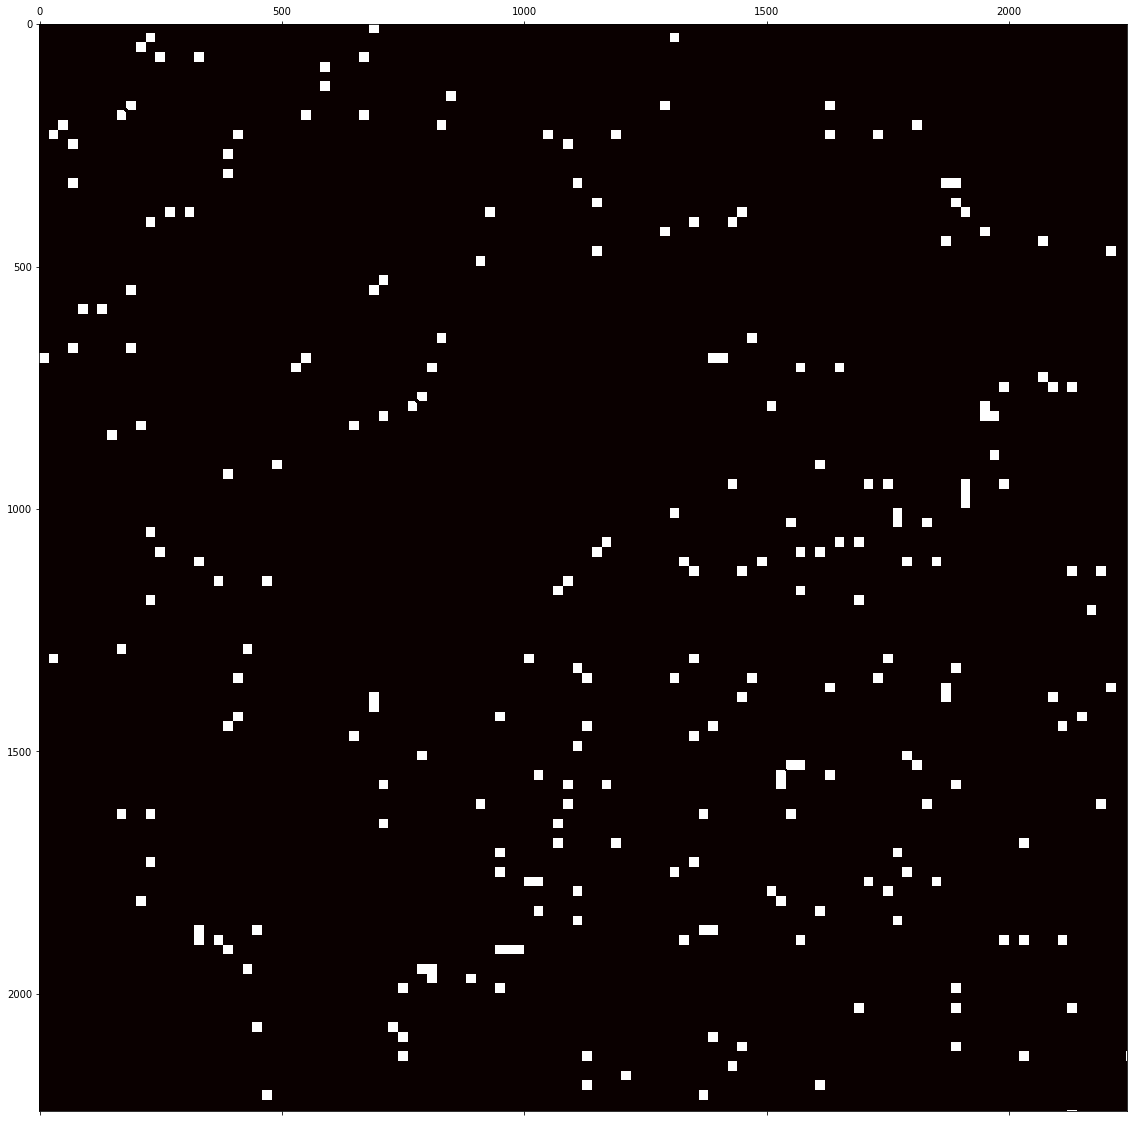

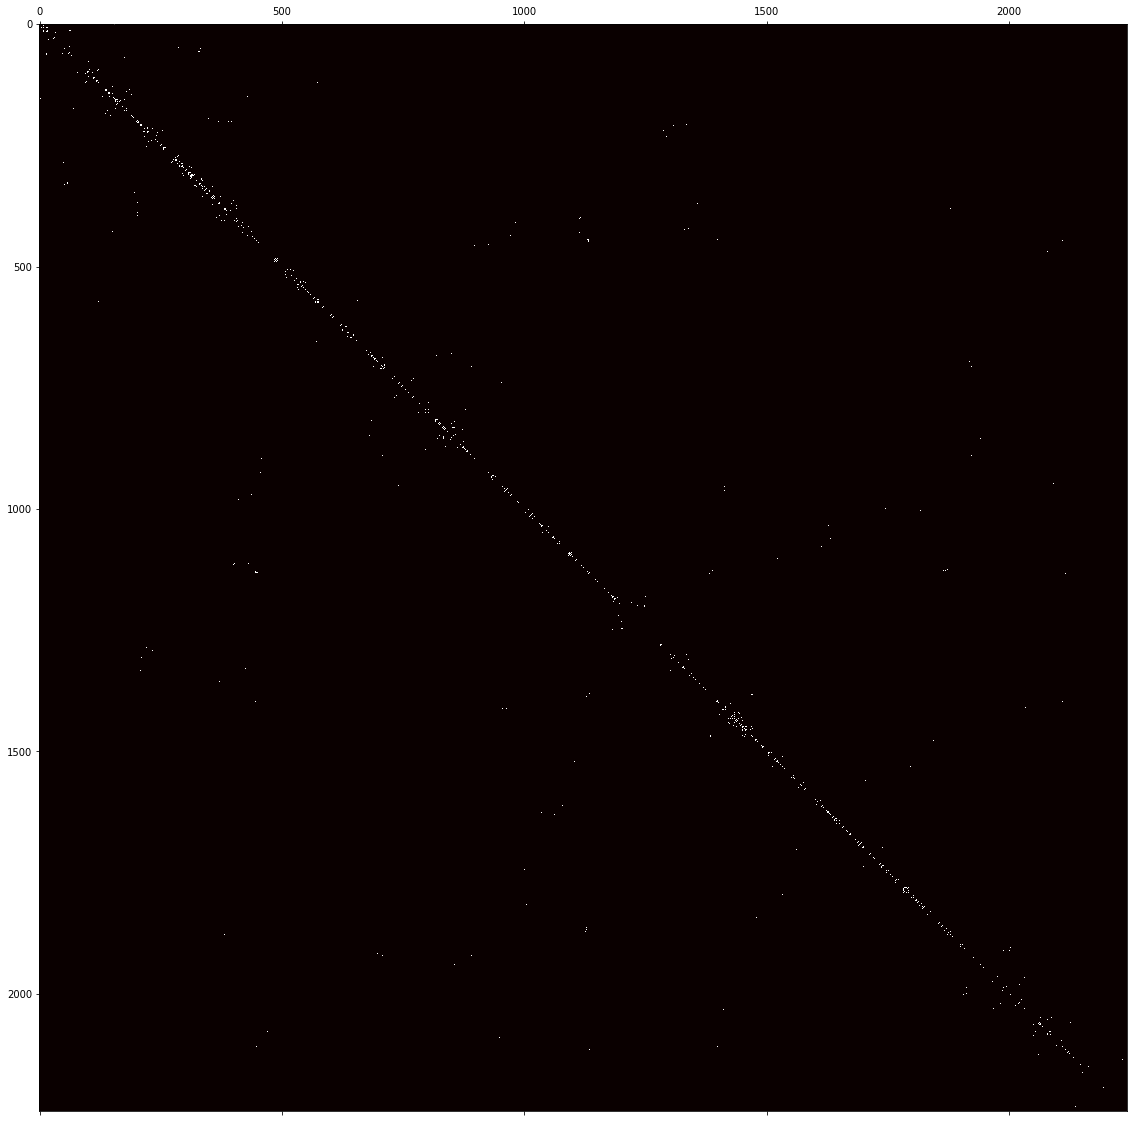

Removed 318 contacts
random walk


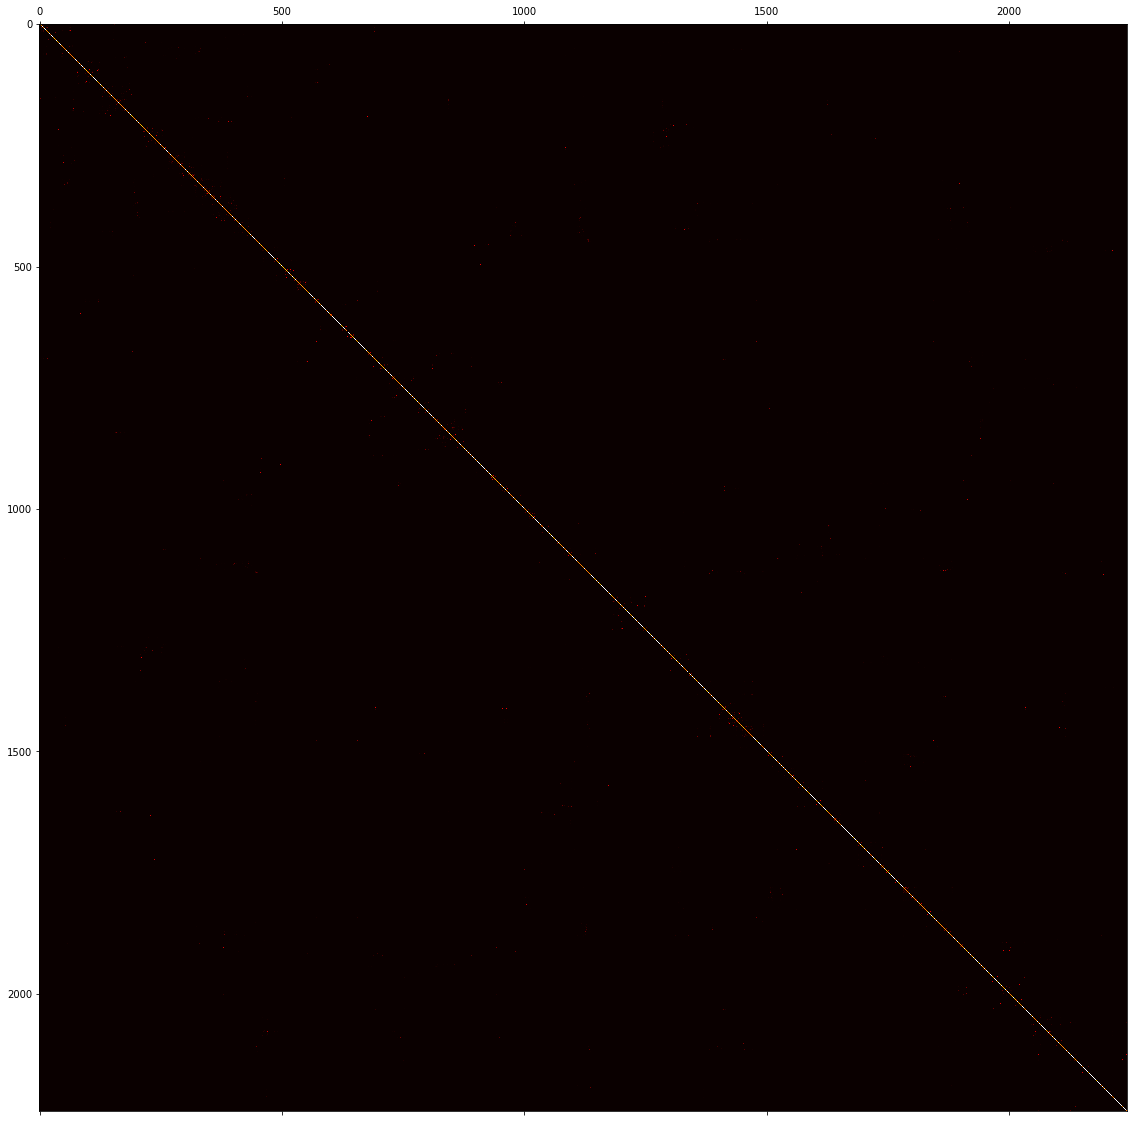

transitivity


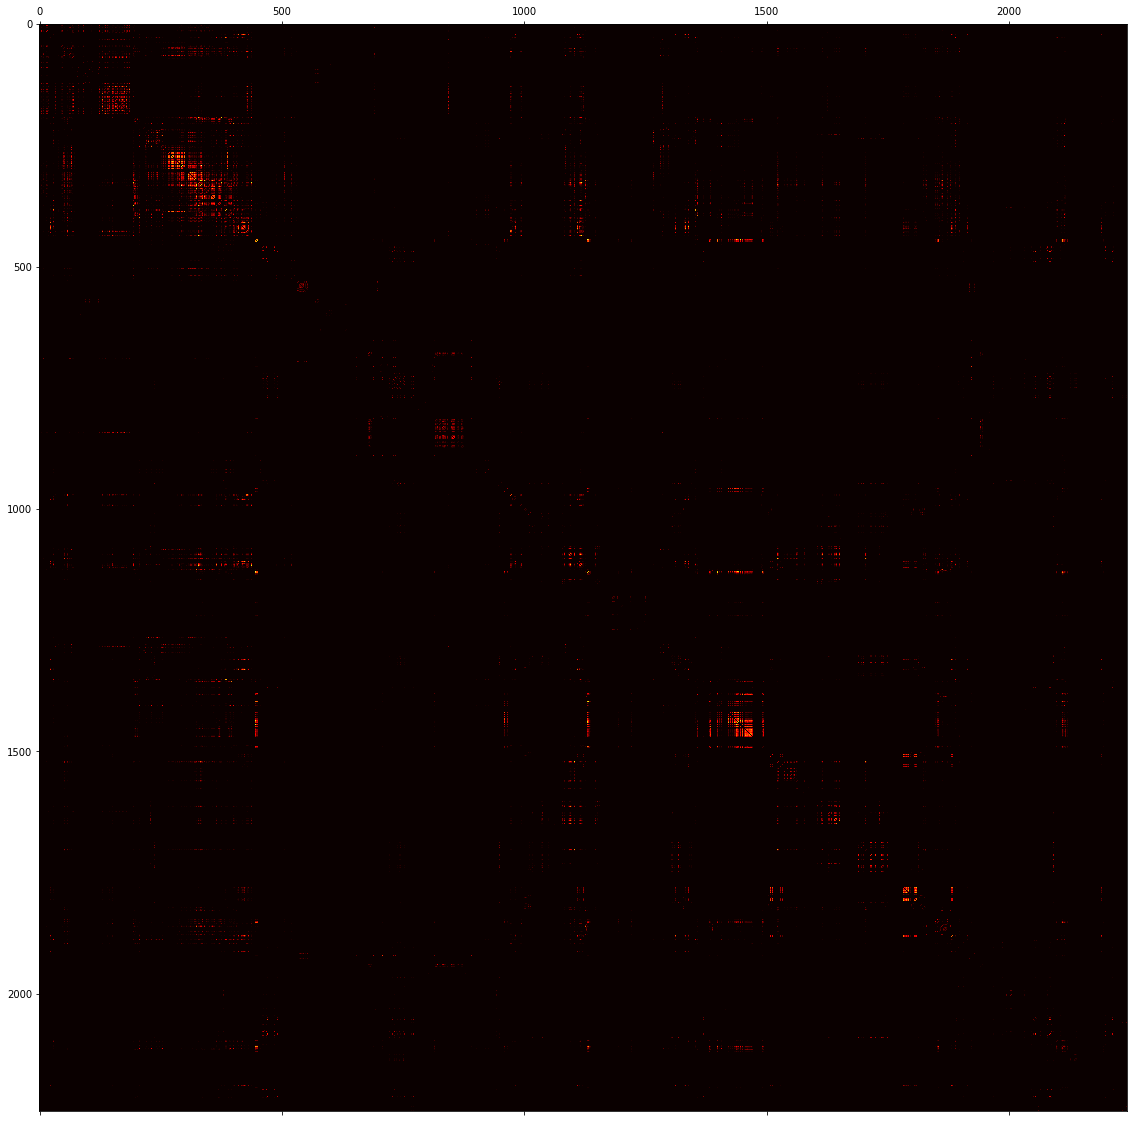

Precision max: 0.35516372795969775
Recall max: 0.7444561774023232
F1 max: 0.48090040927694405
A3


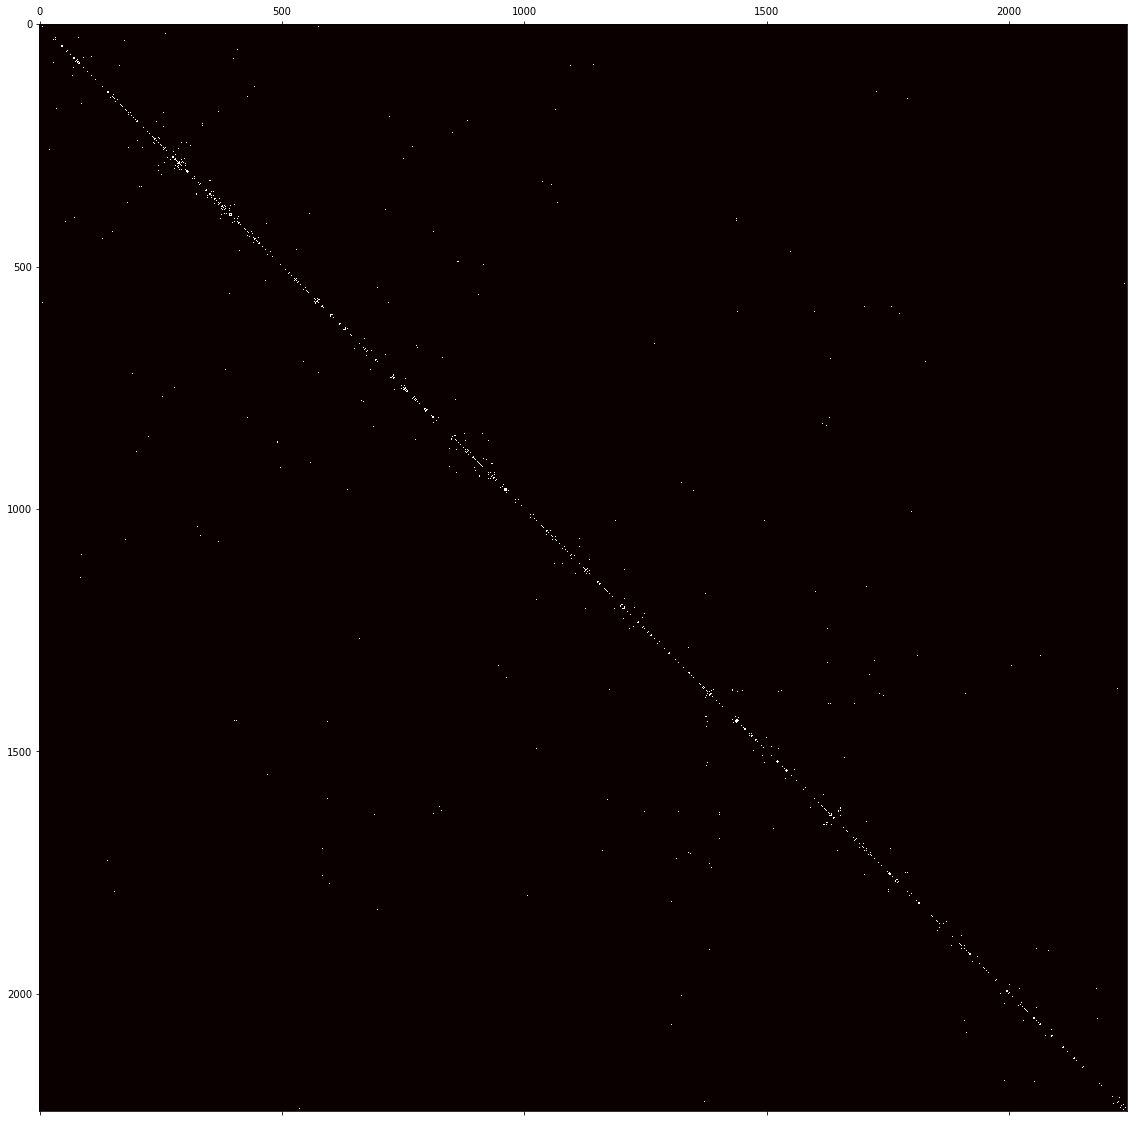

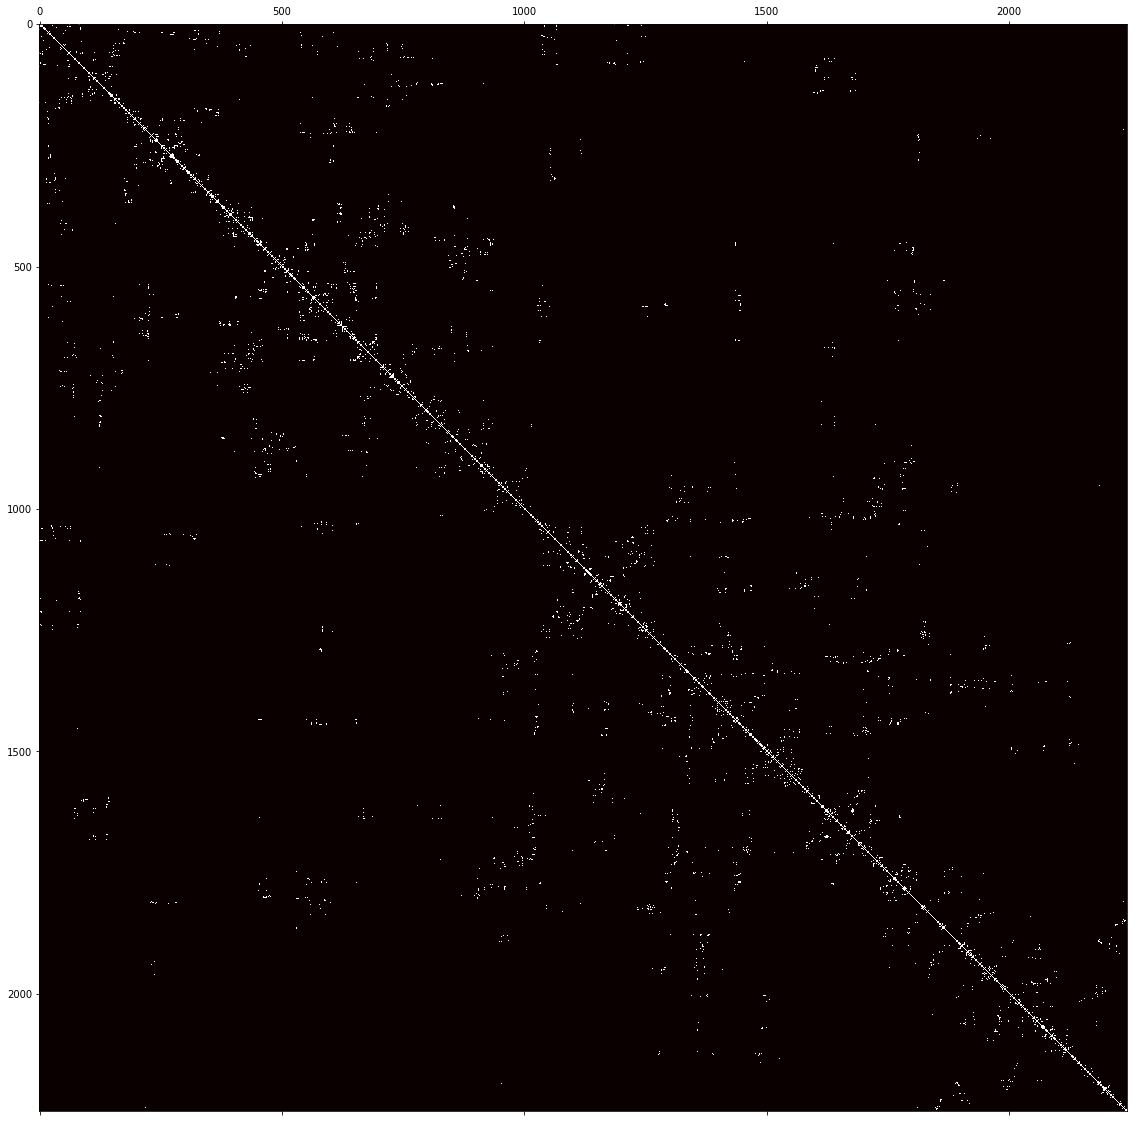

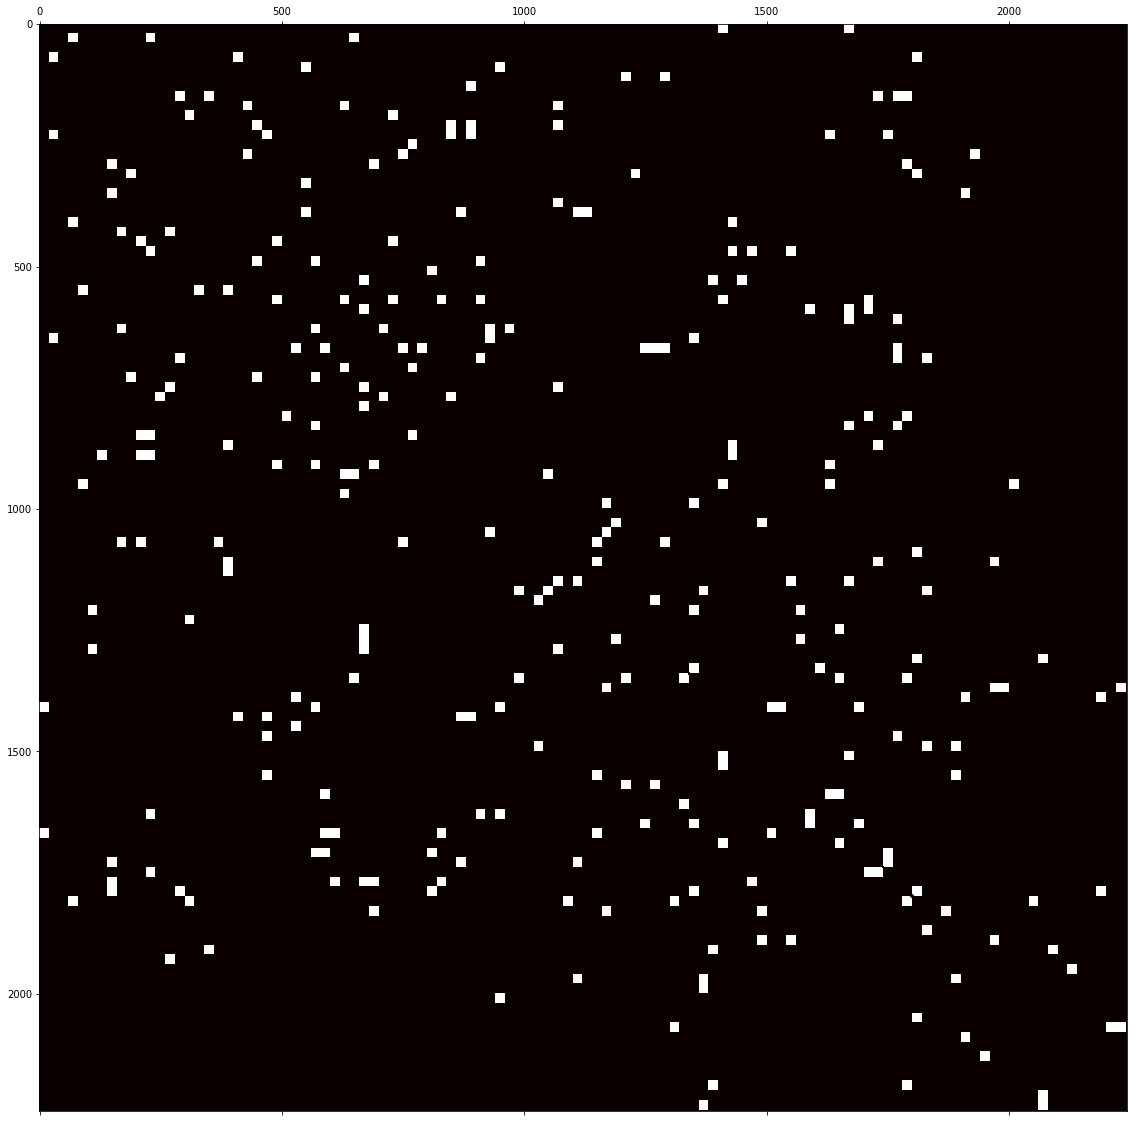

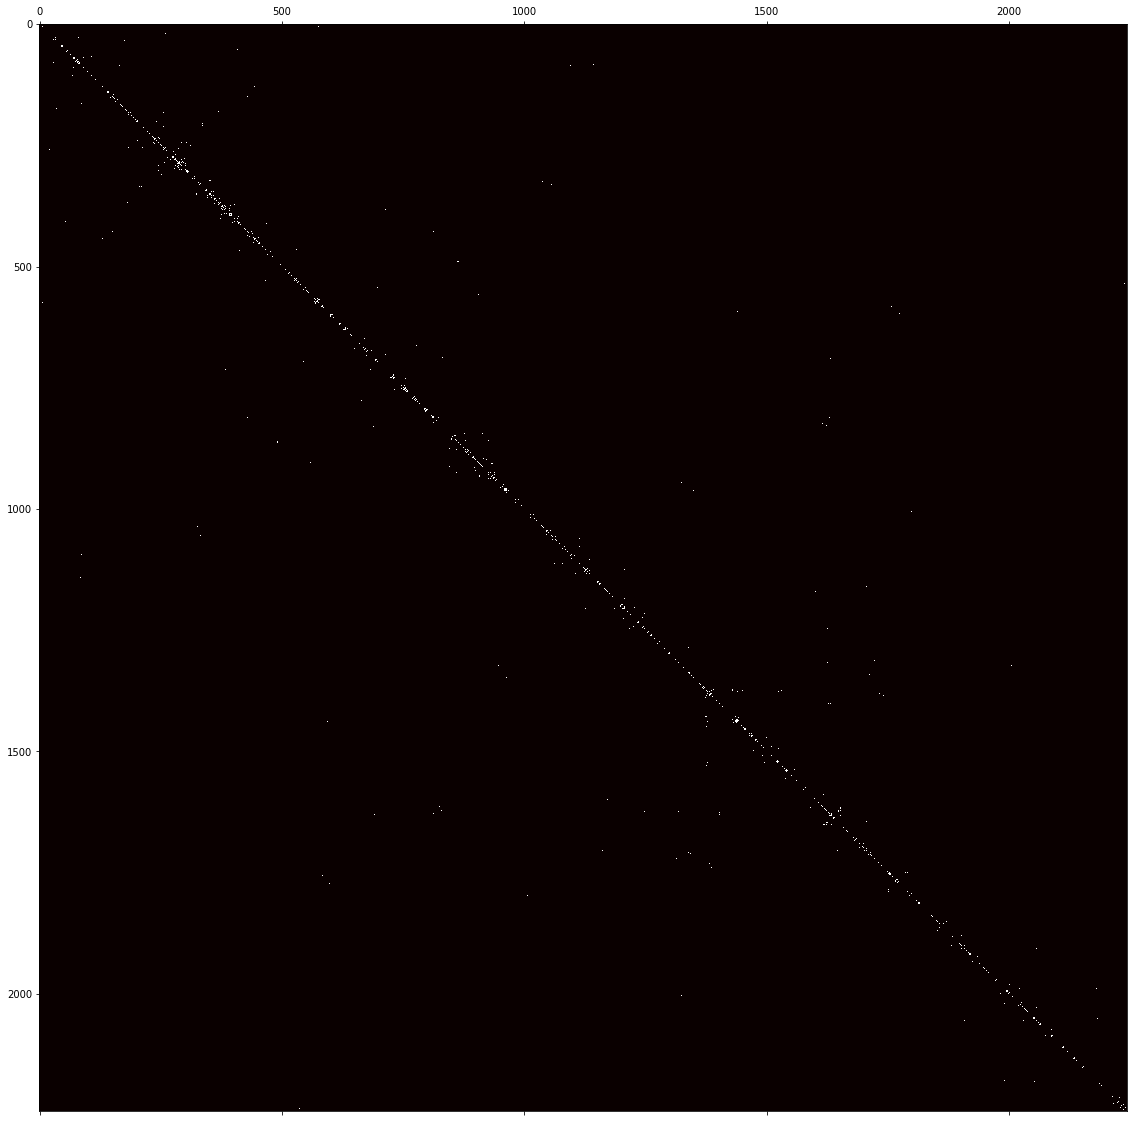

Removed 382 contacts
random walk


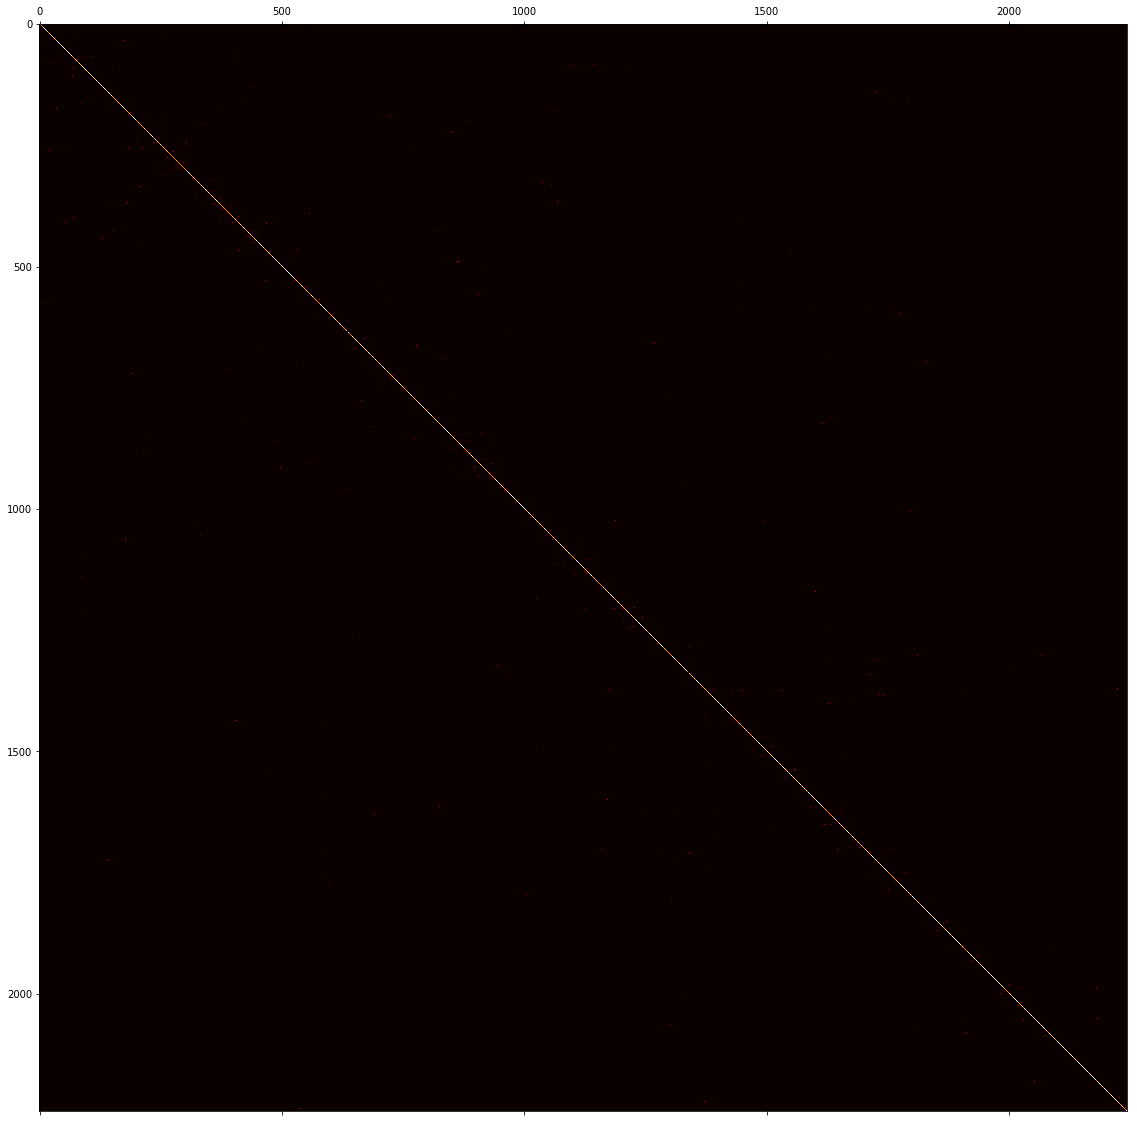

transitivity


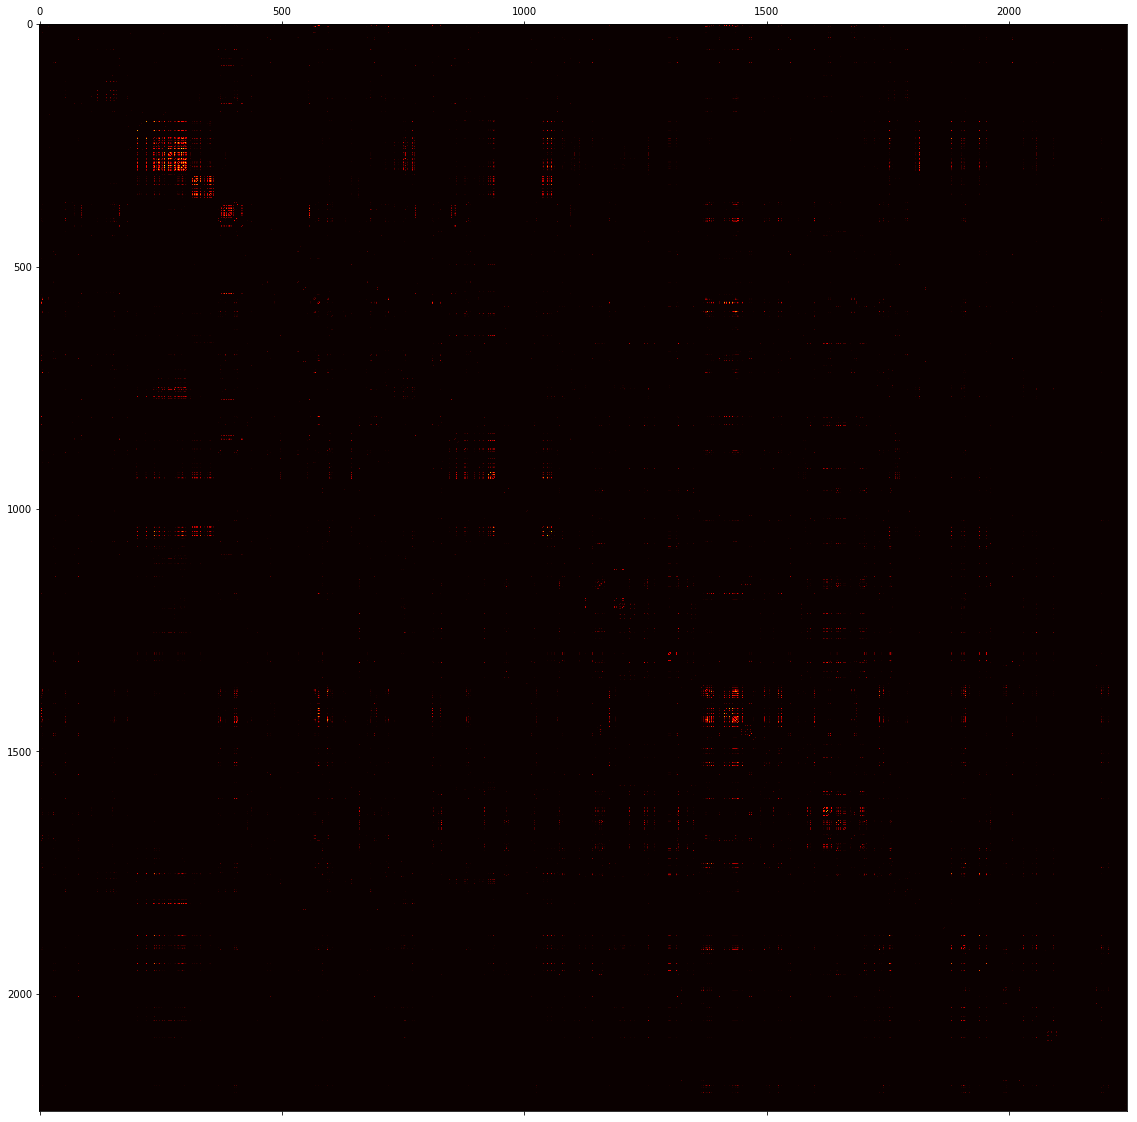

Precision max: 0.2726069695632995
Recall max: 0.6702819956616052
F1 max: 0.38758231420508
B3


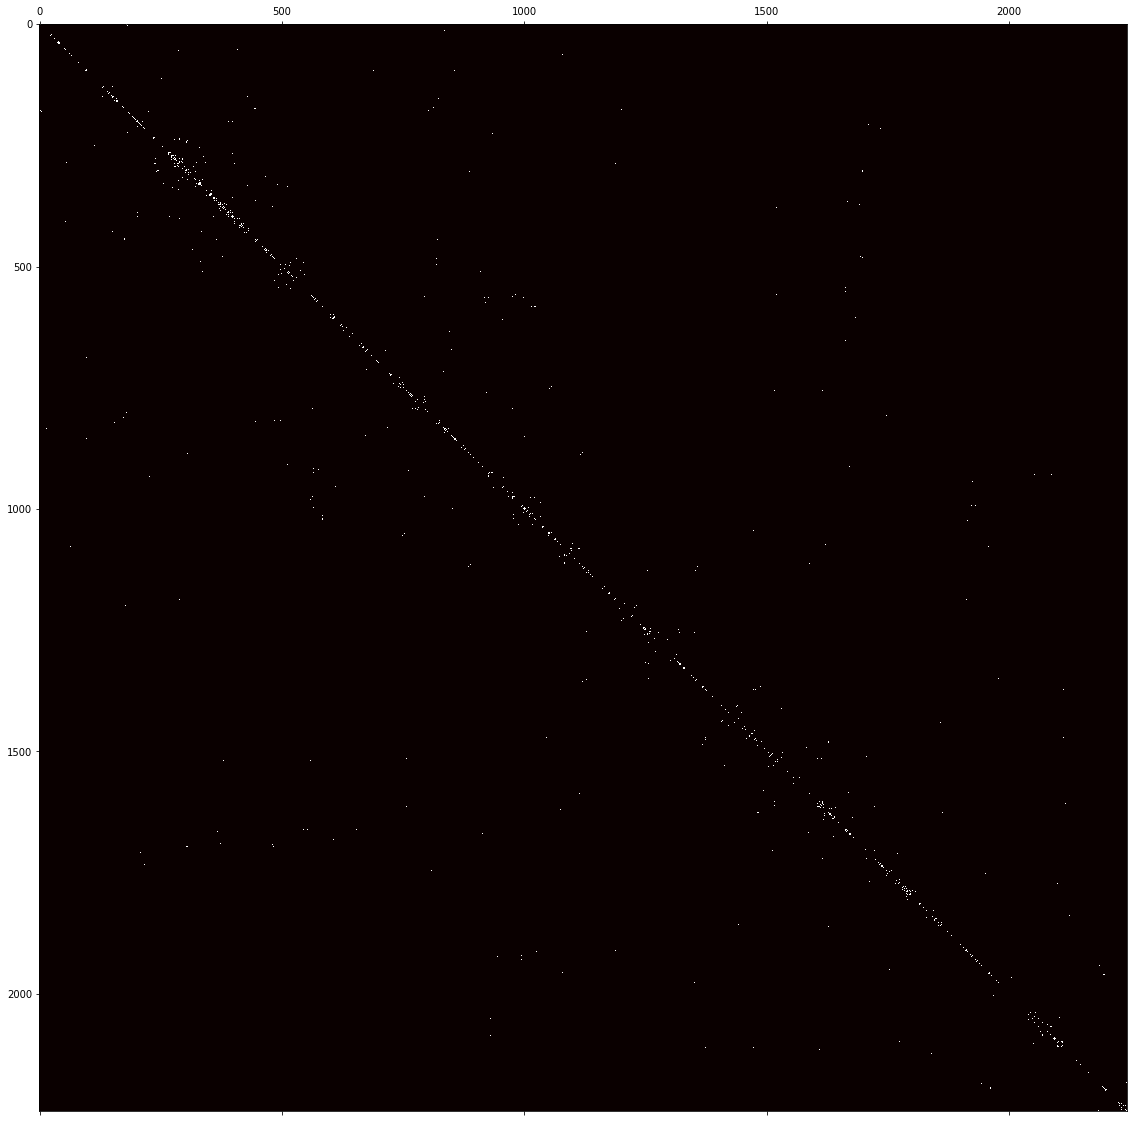

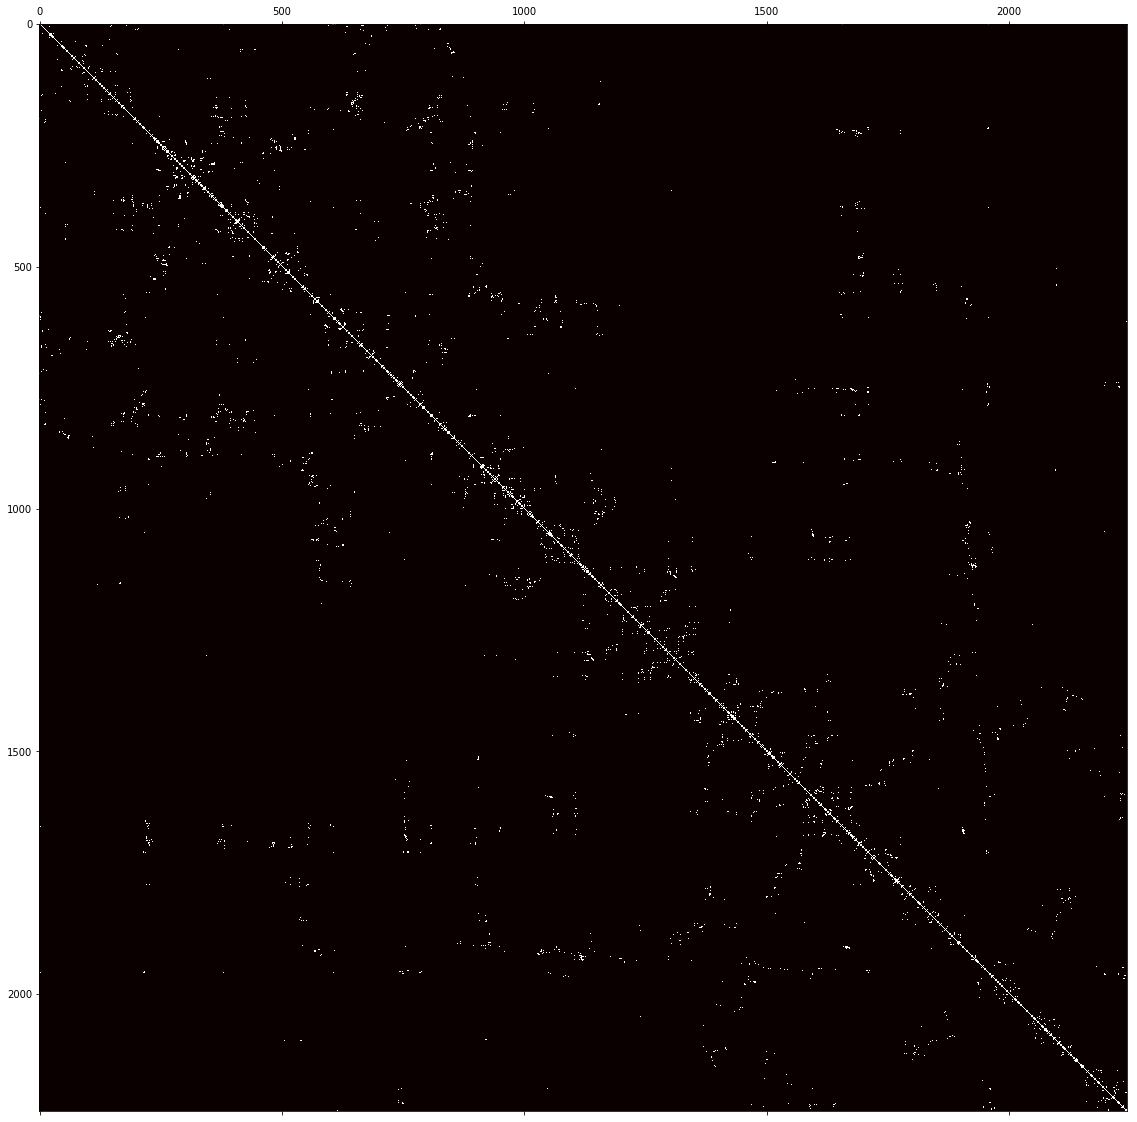

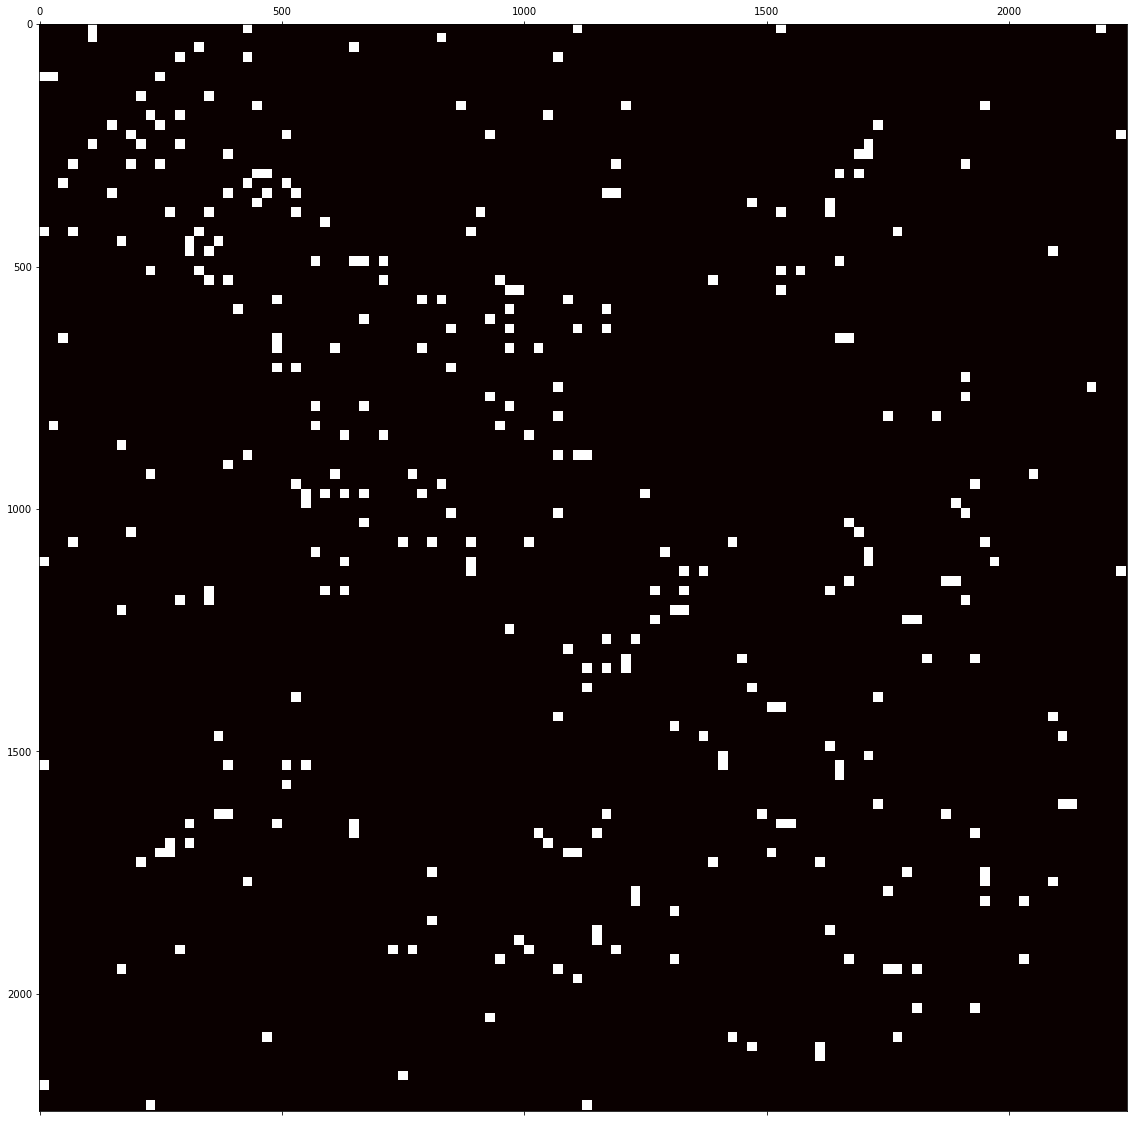

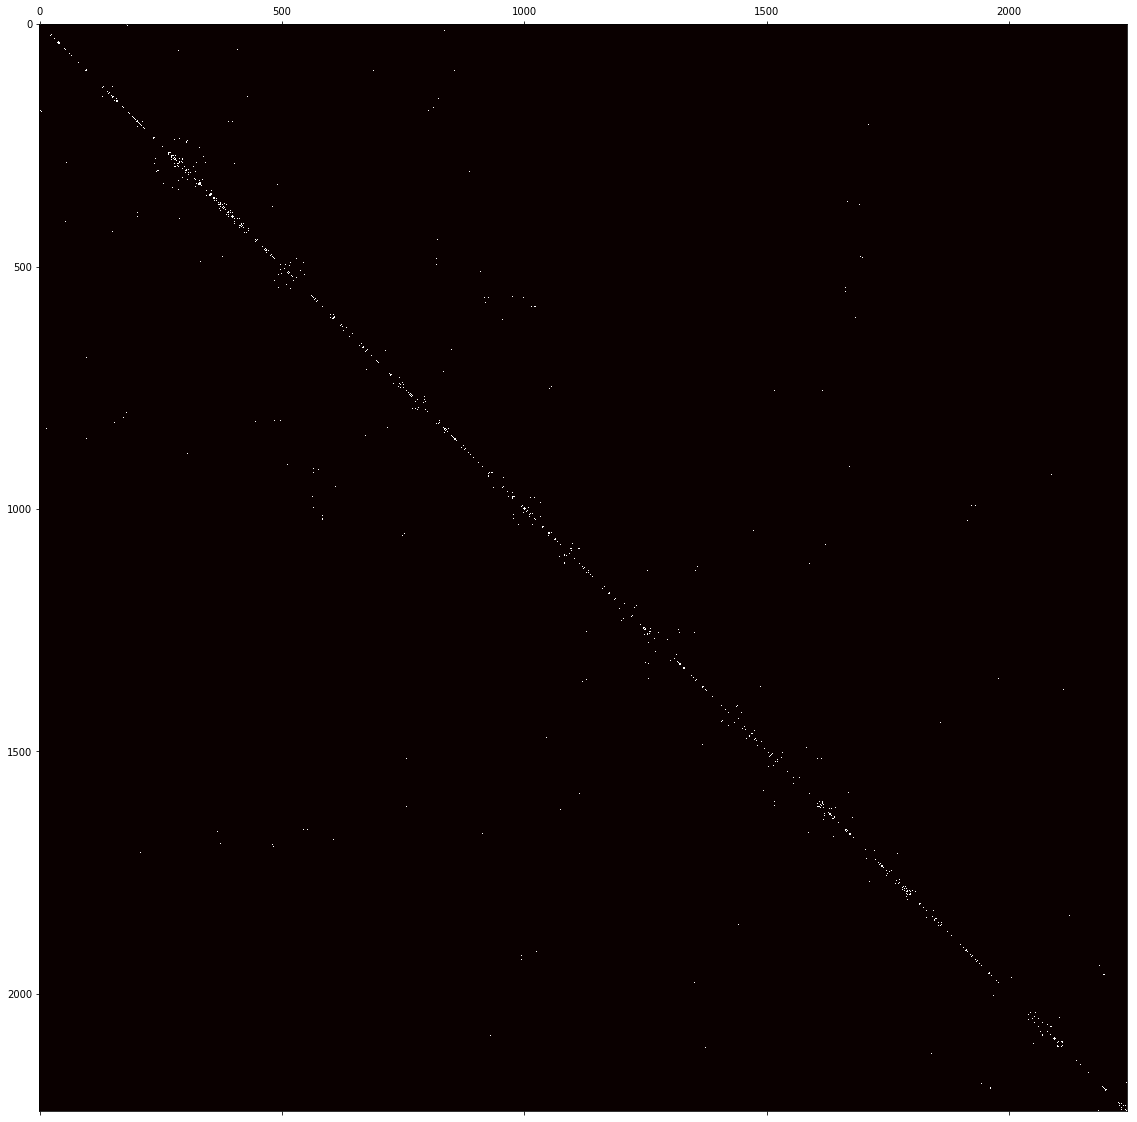

Removed 376 contacts
random walk


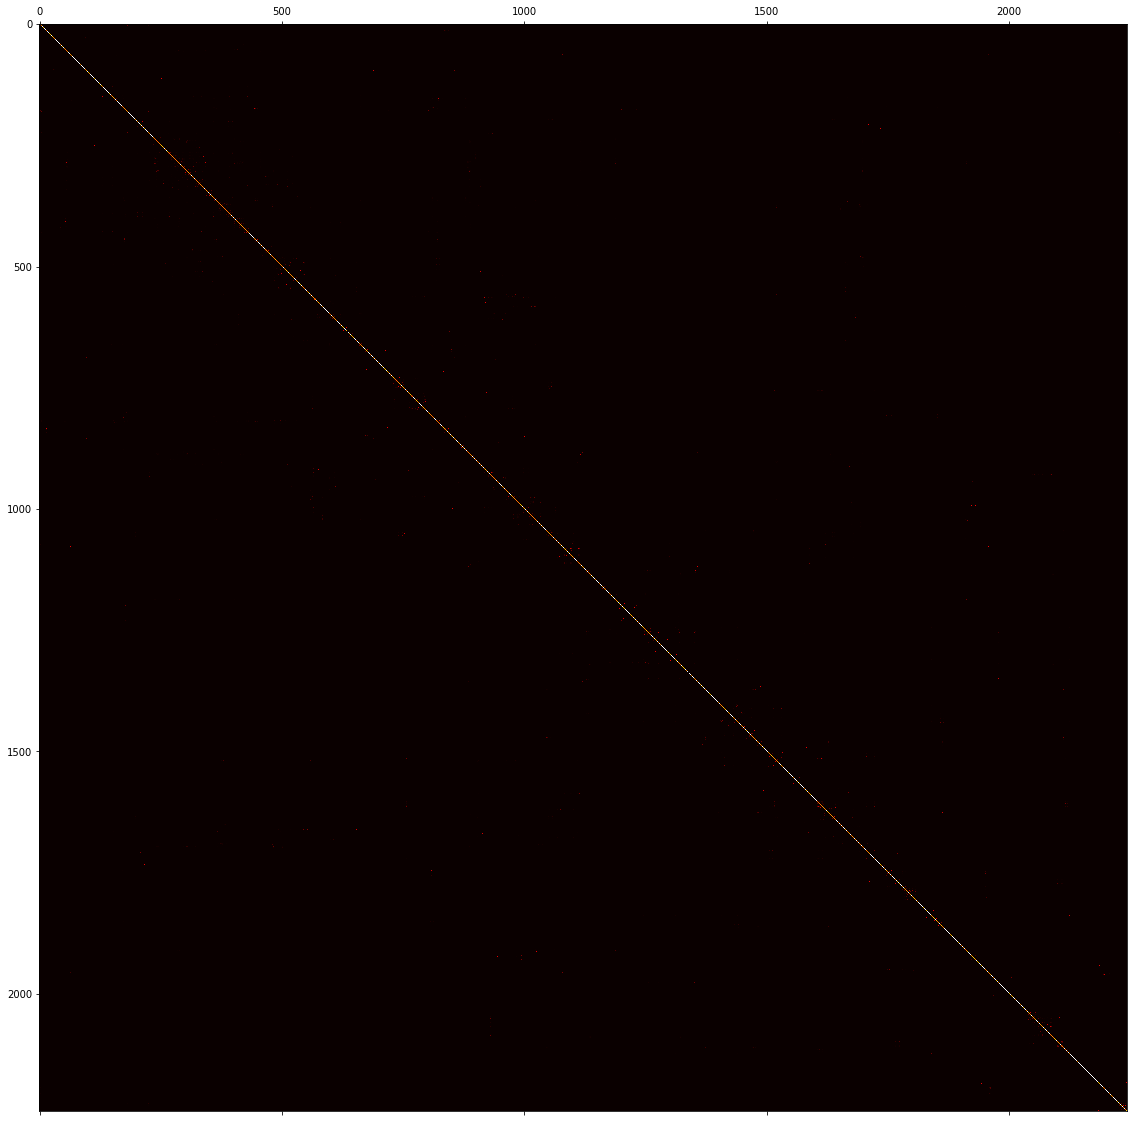

transitivity


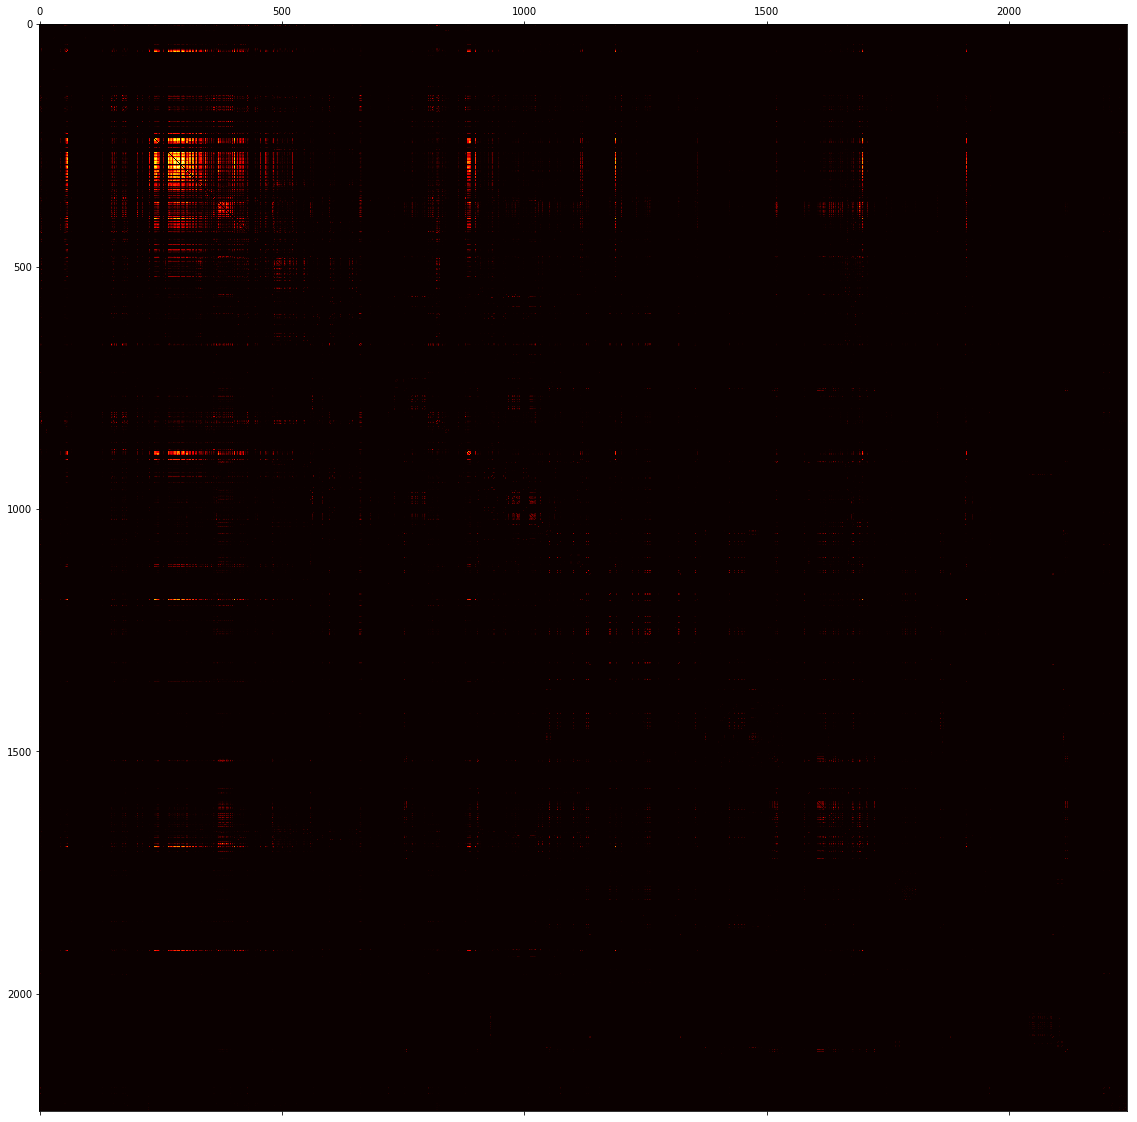

Precision max: 0.3246632605666512
Recall max: 0.6941410129096326
F1 max: 0.44240506329113927
sc23


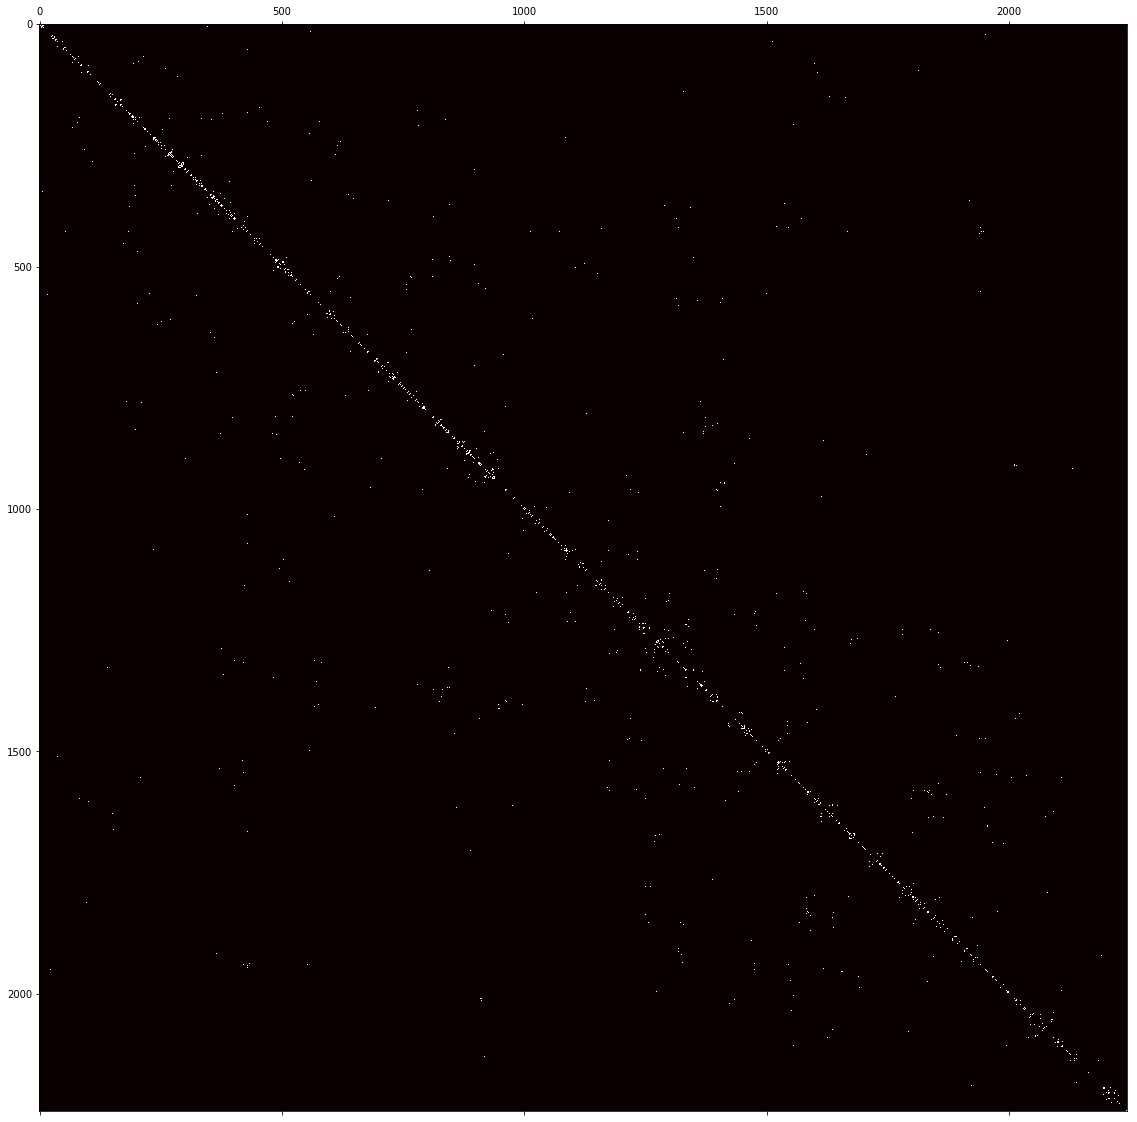

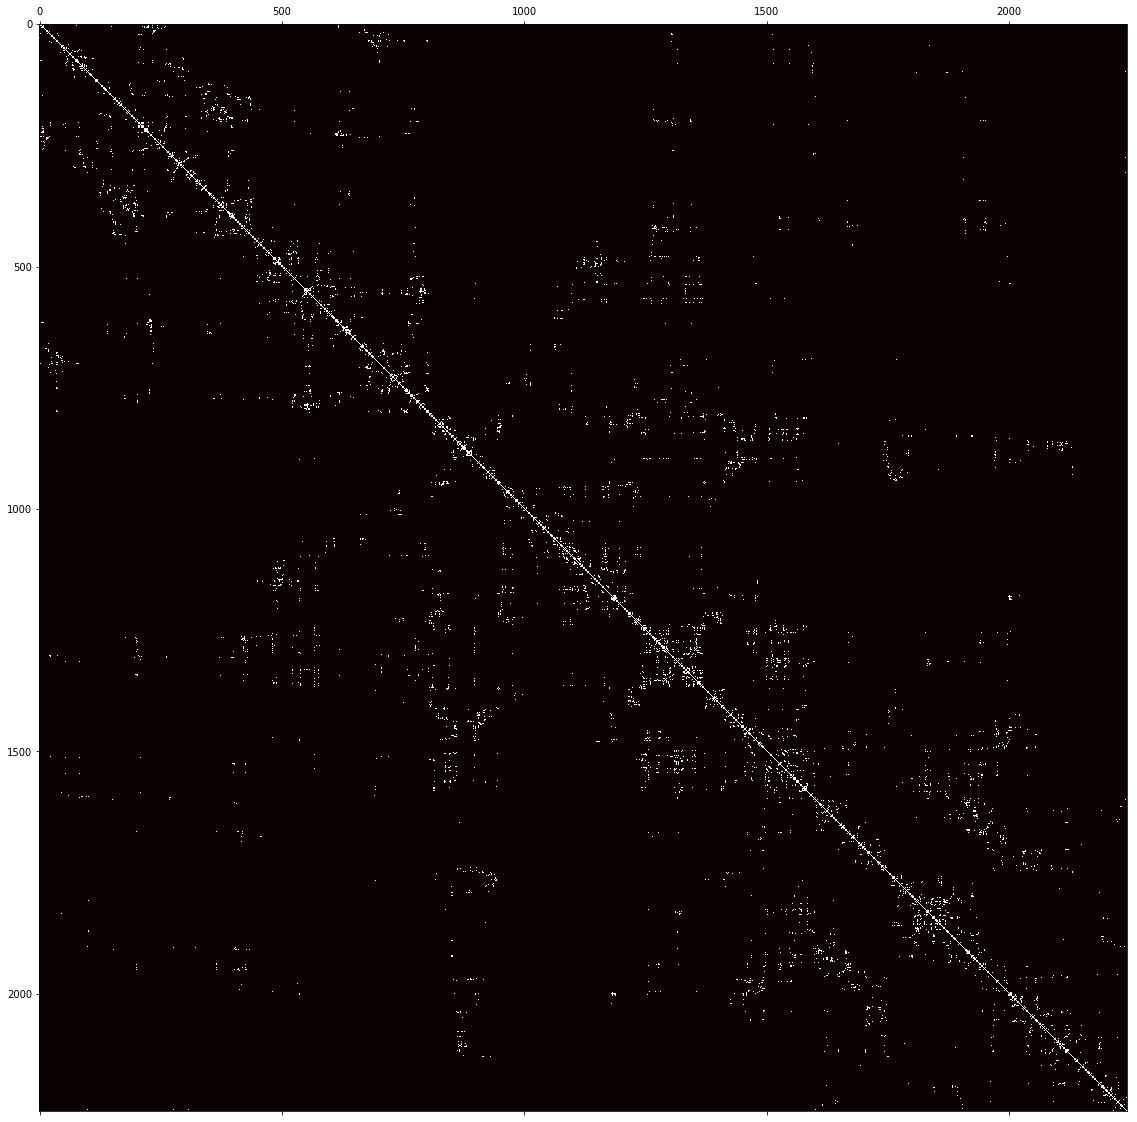

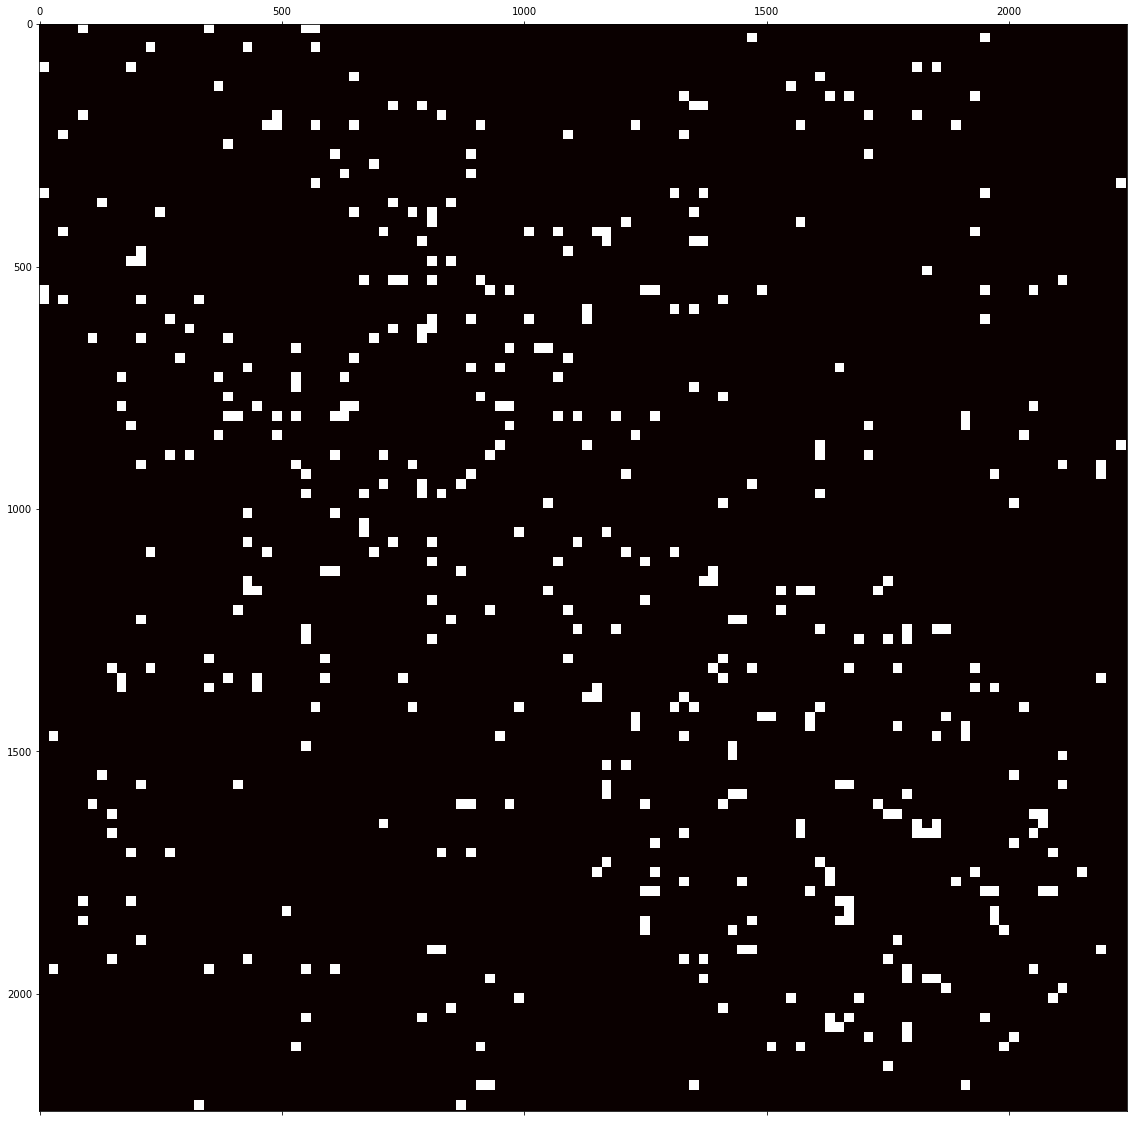

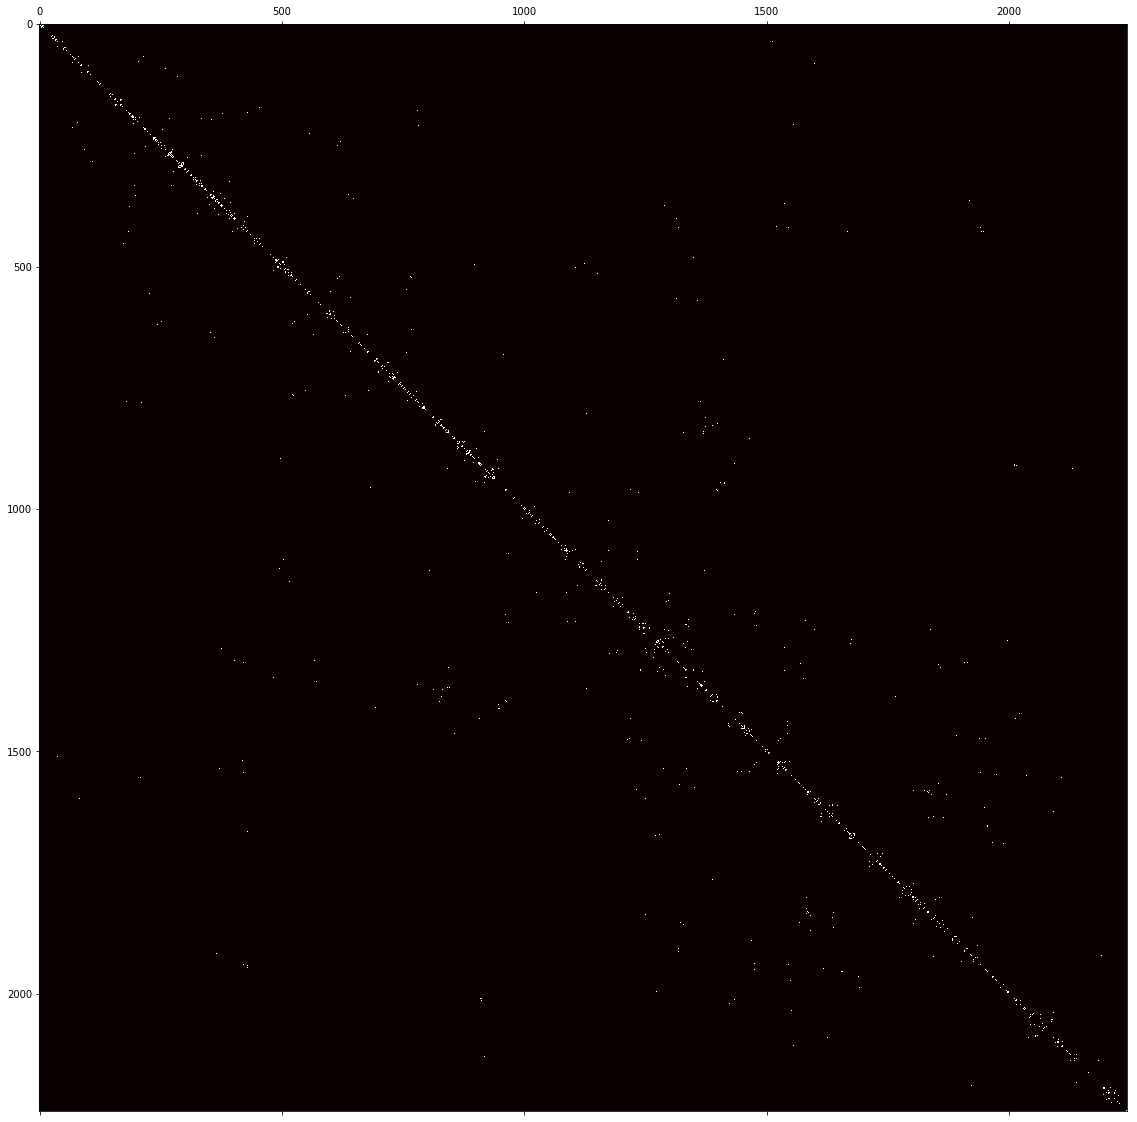

Removed 586 contacts
random walk


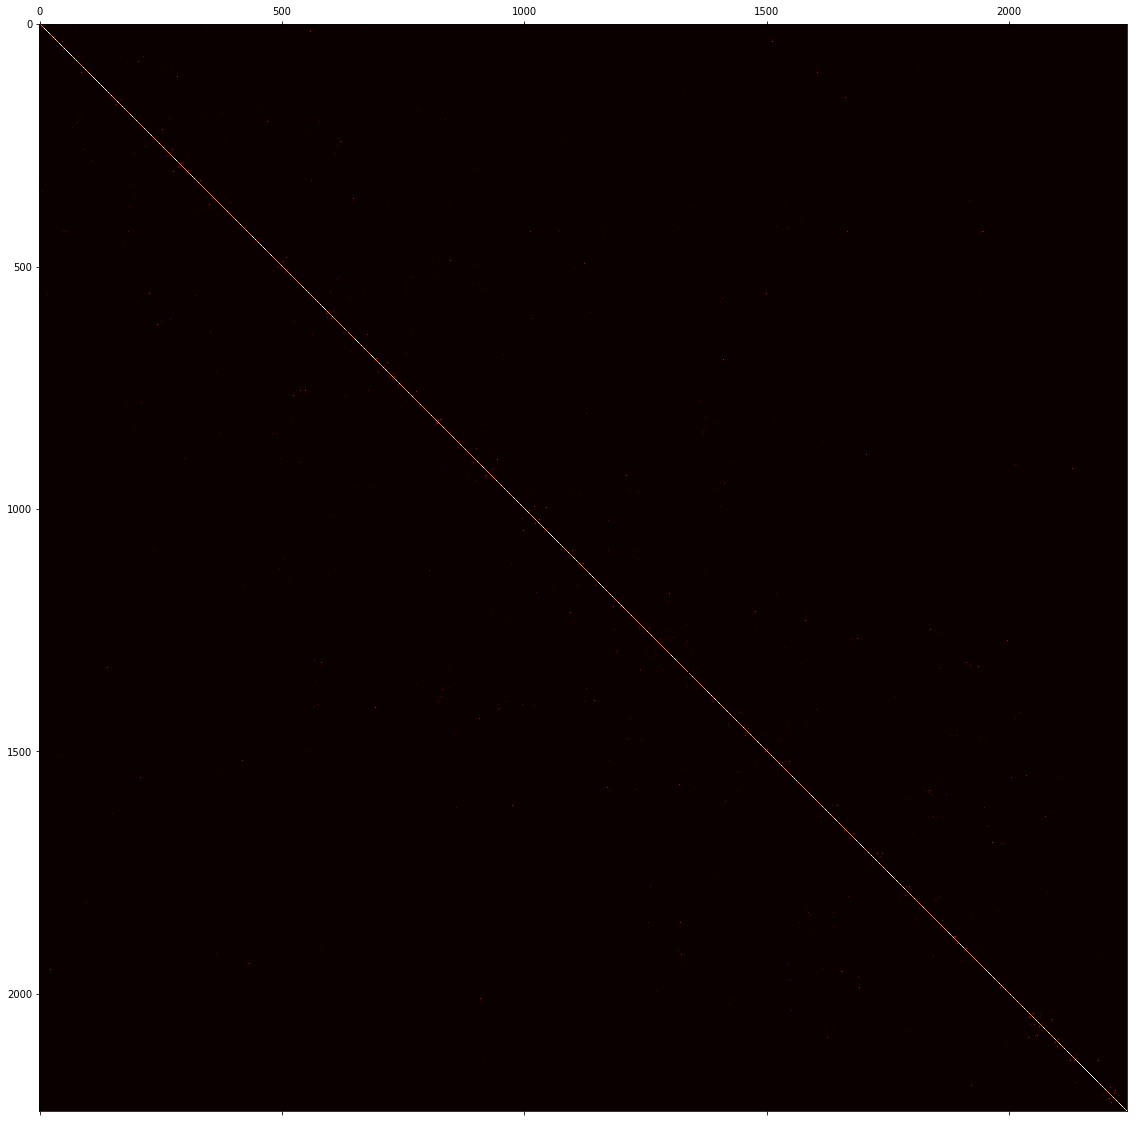

transitivity


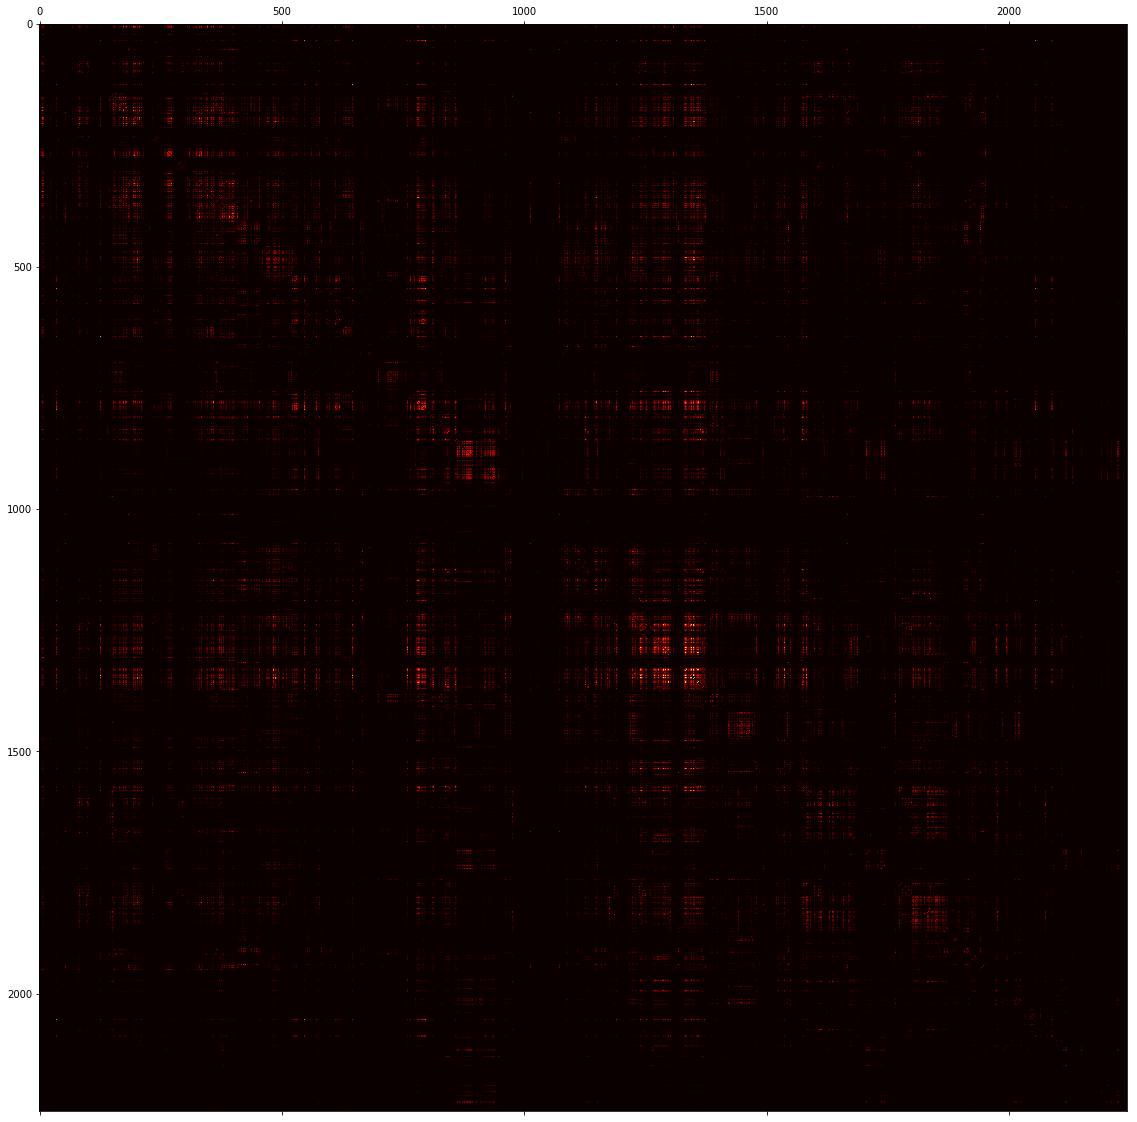

Precision max: 0.34209591474245116
Recall max: 0.6863863150392017
F1 max: 0.45661450924608826
B6


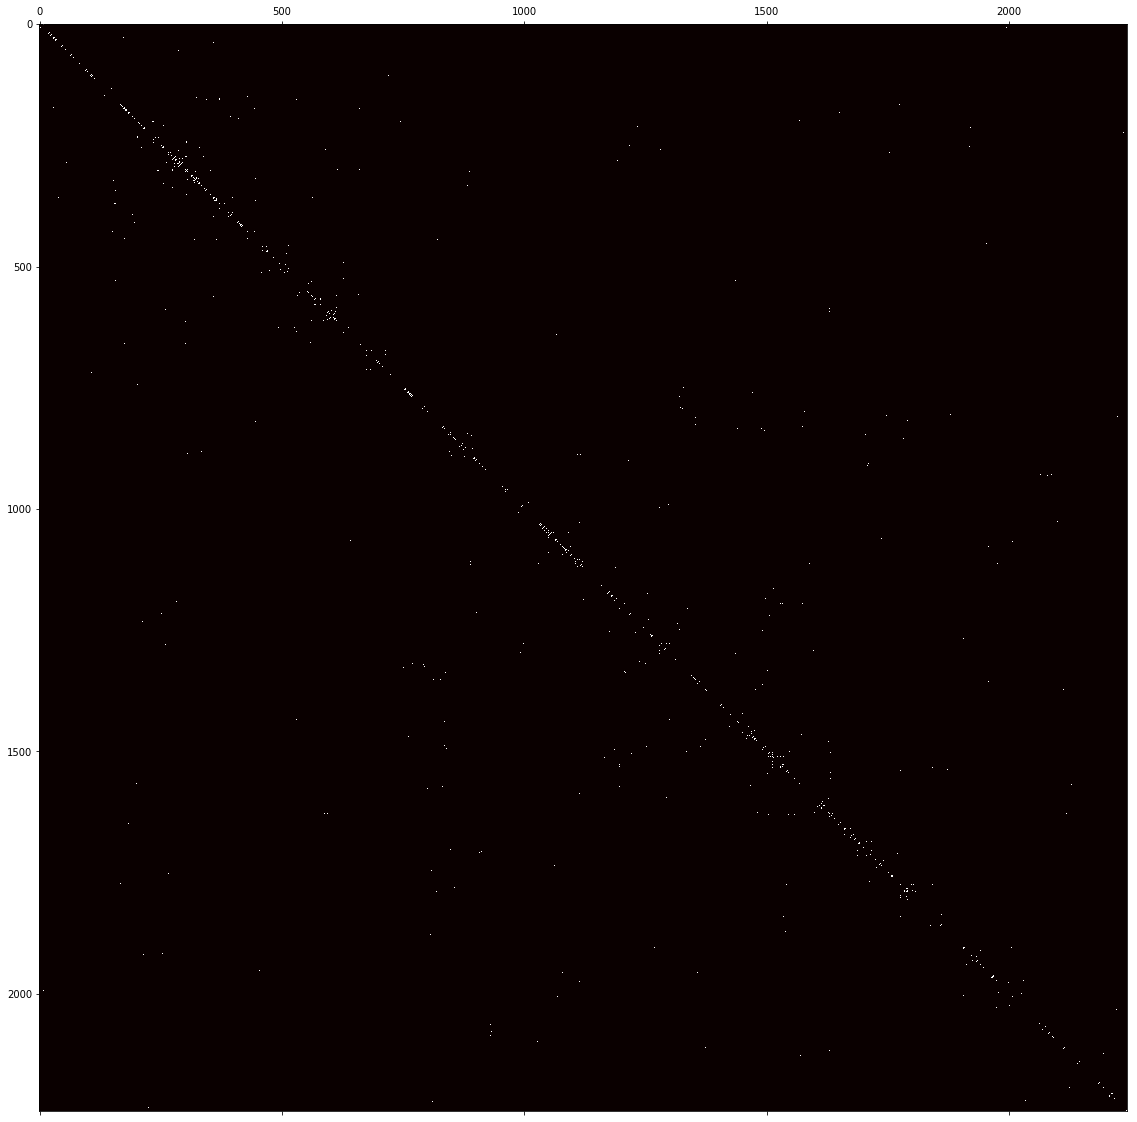

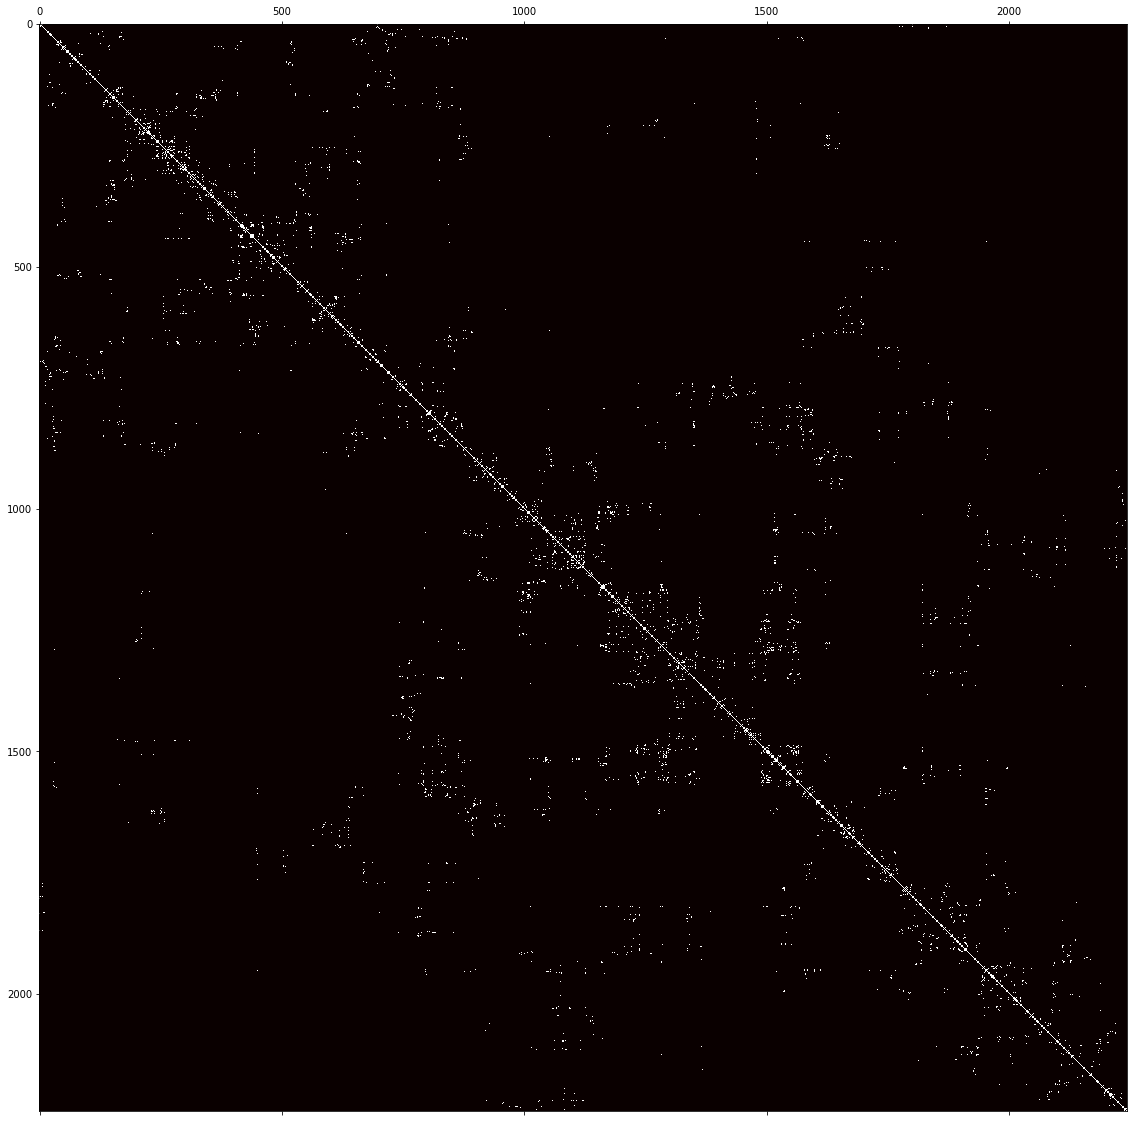

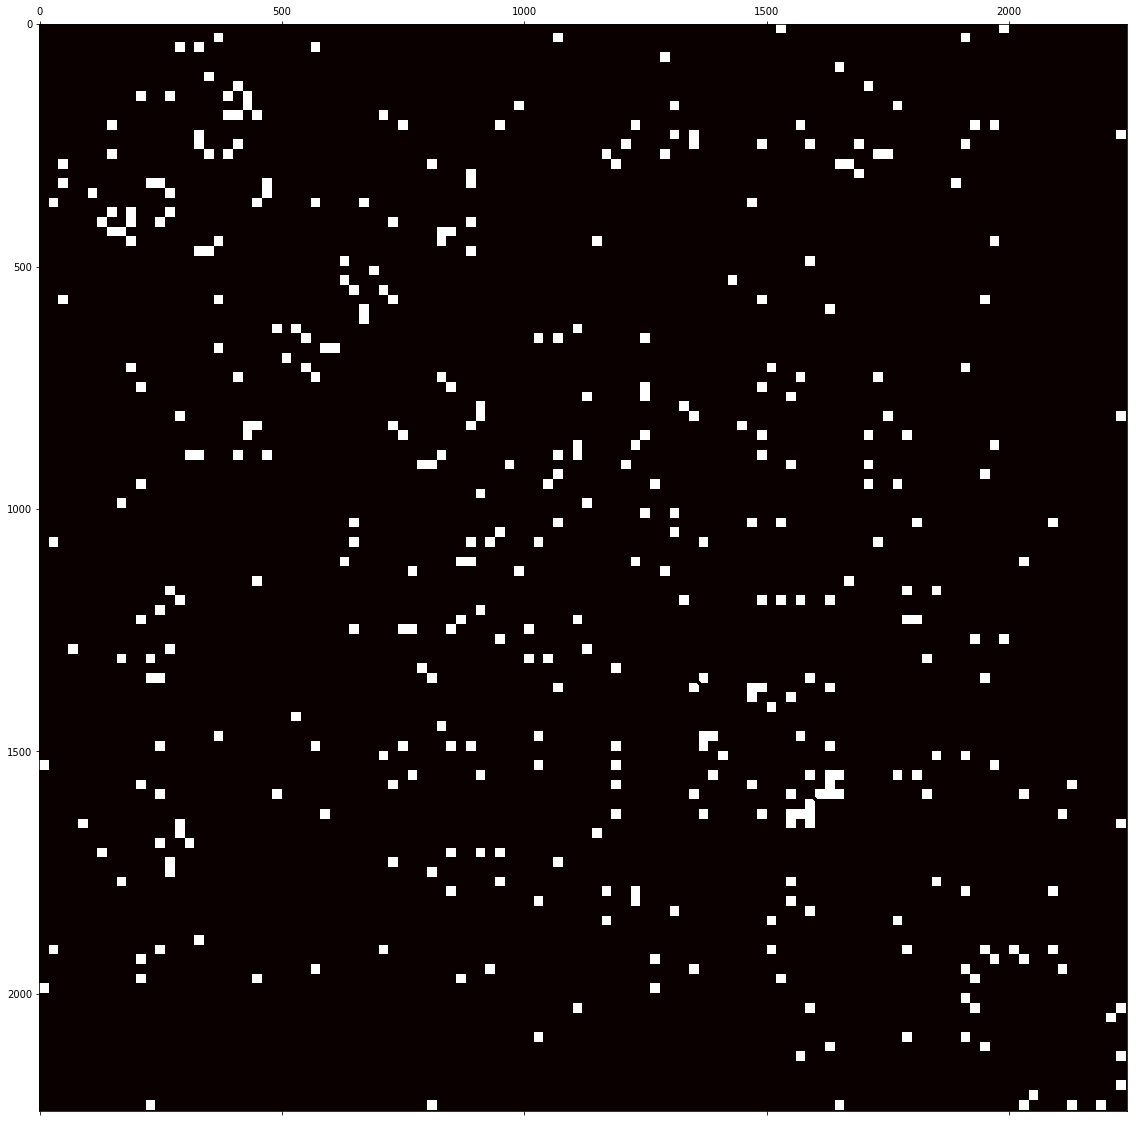

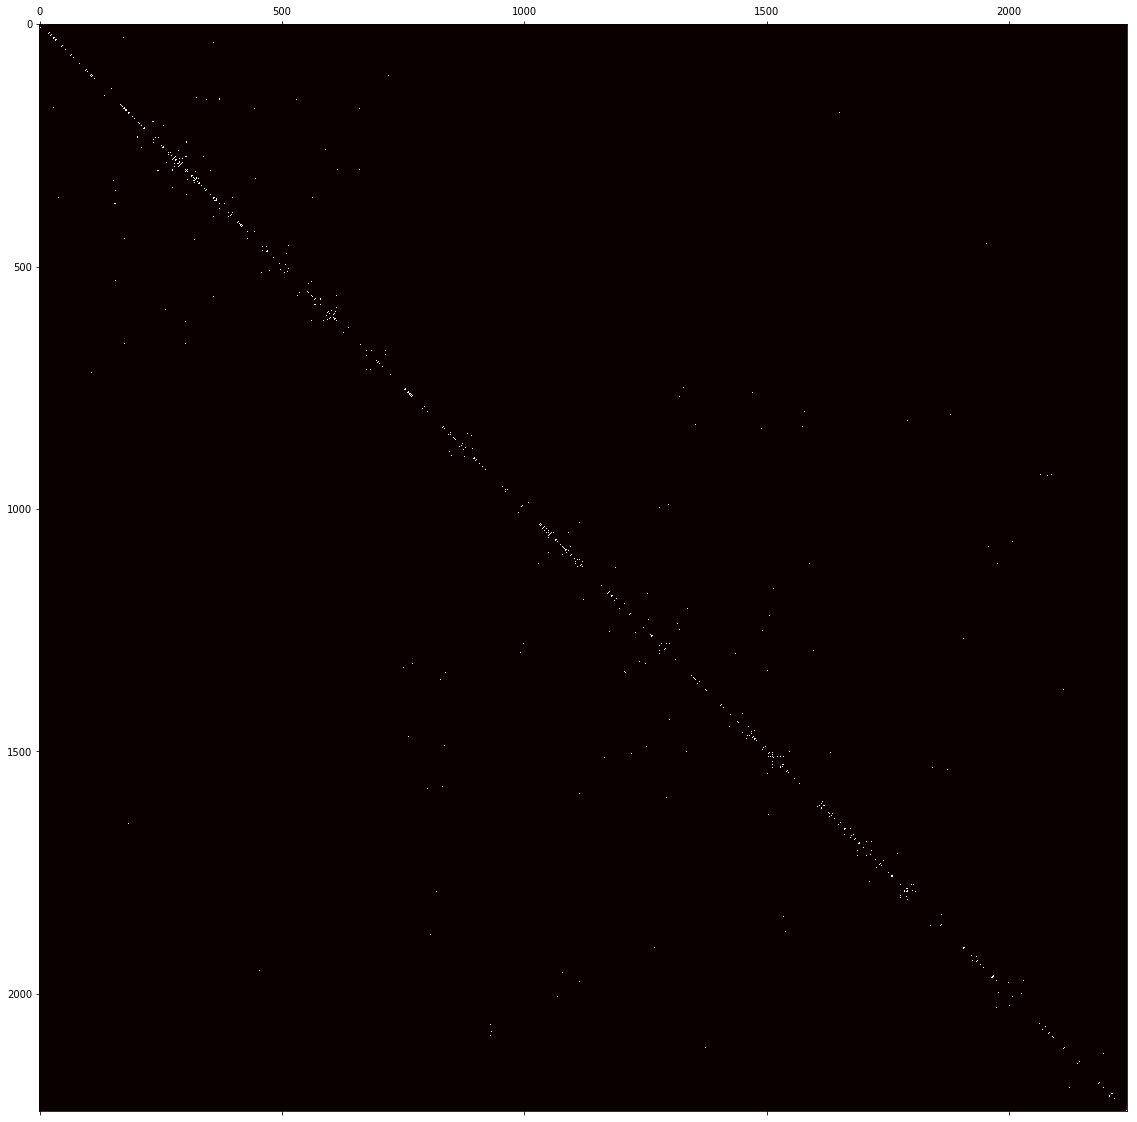

Removed 468 contacts
random walk


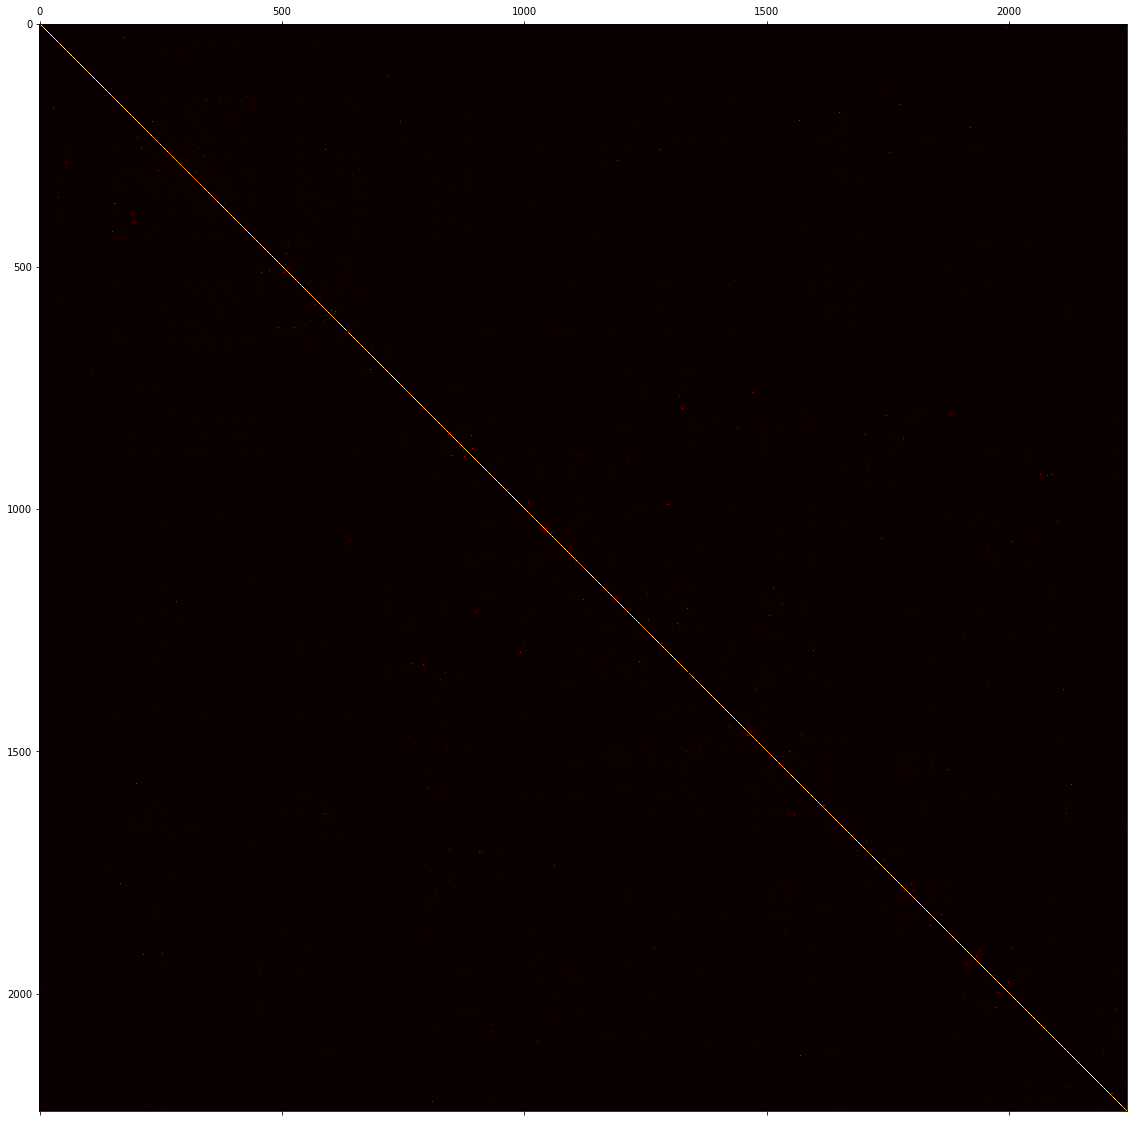

transitivity


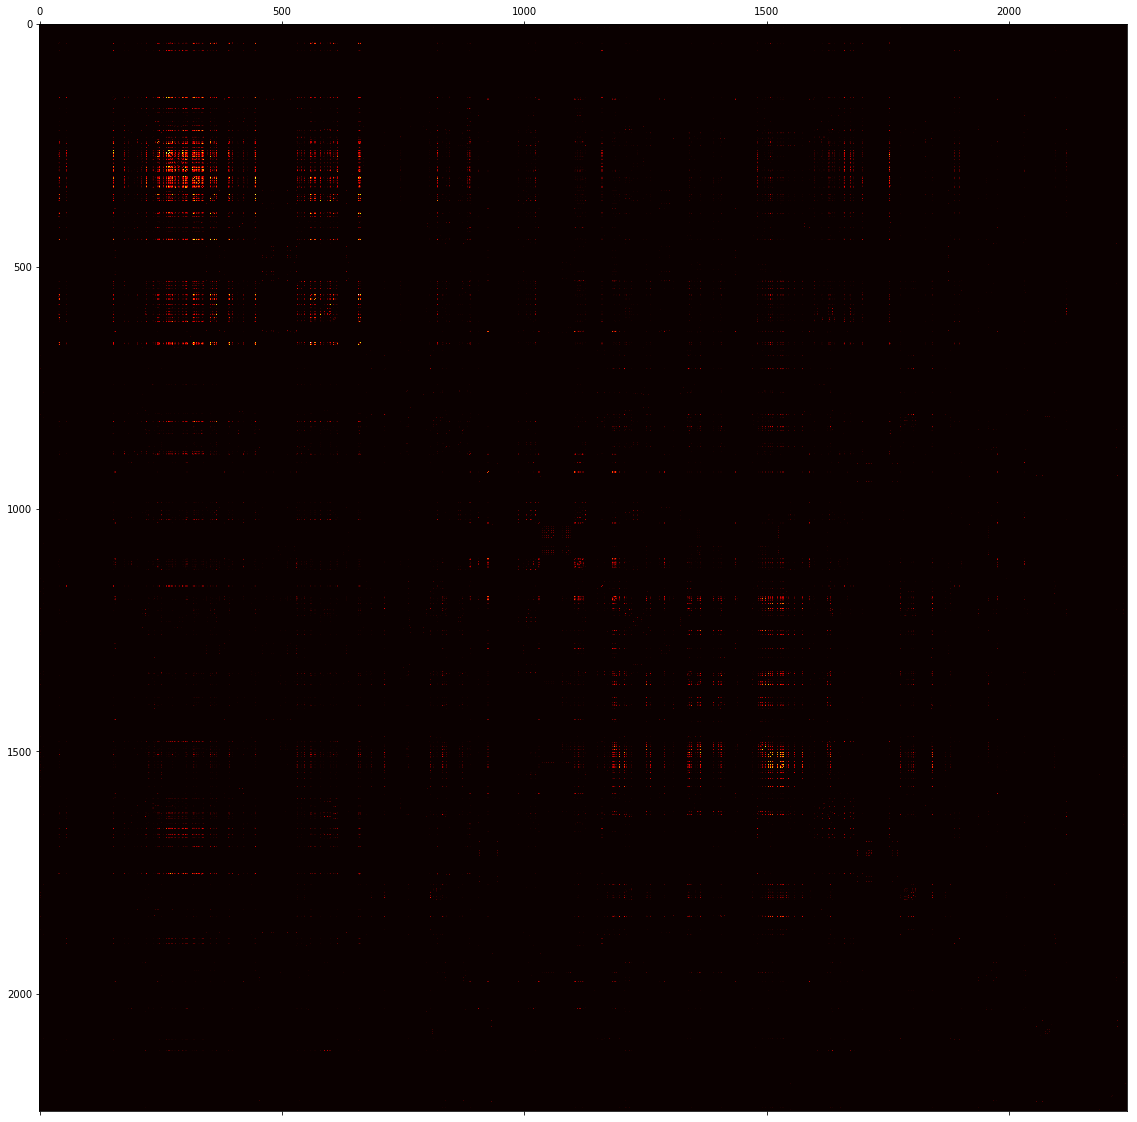

Precision max: 0.2861647615293654
Recall max: 0.6505376344086021
F1 max: 0.3974815220366822
B15


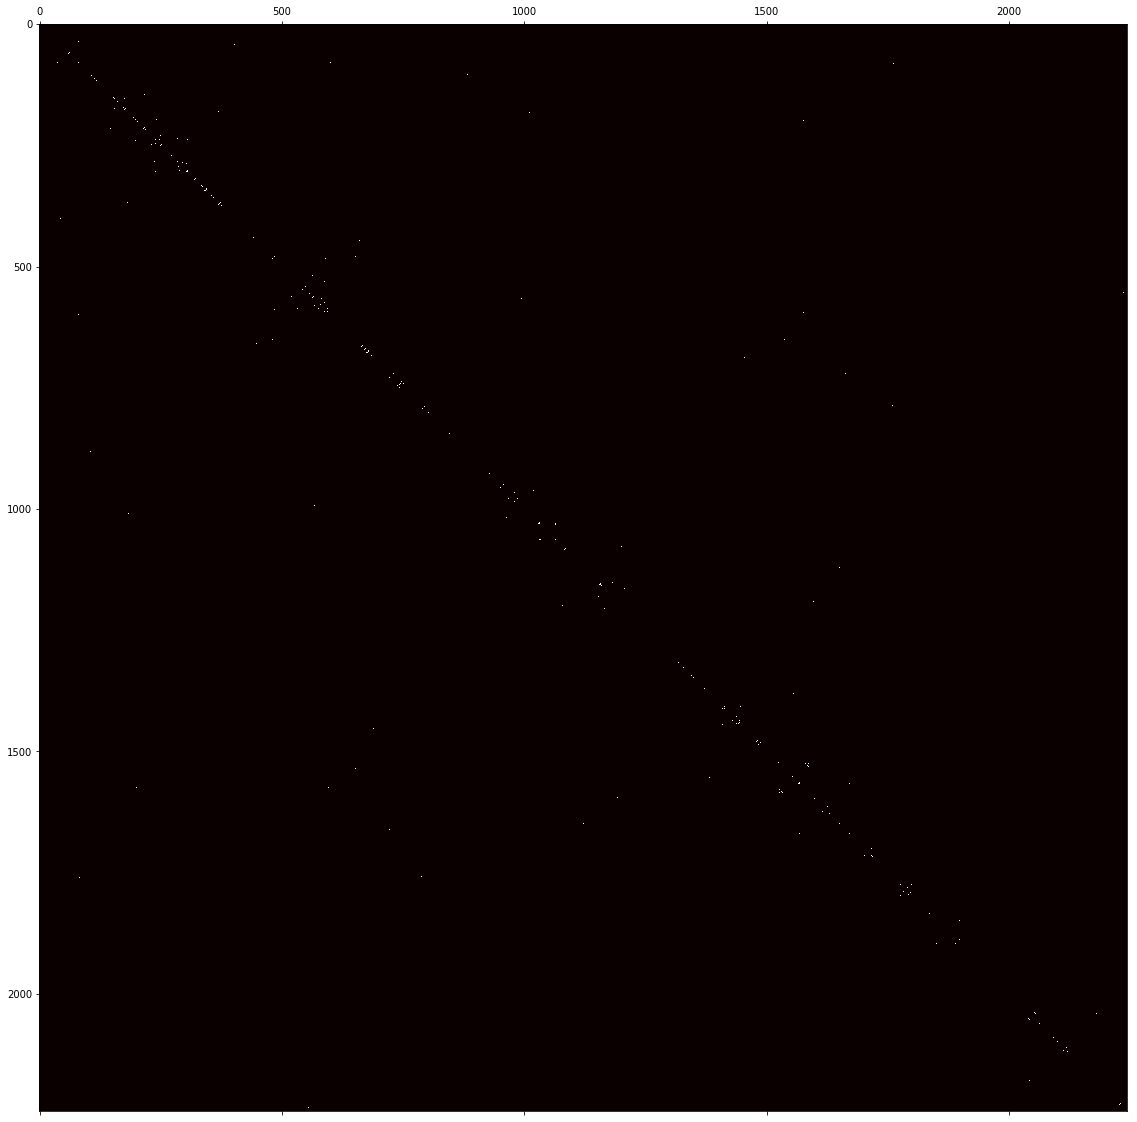

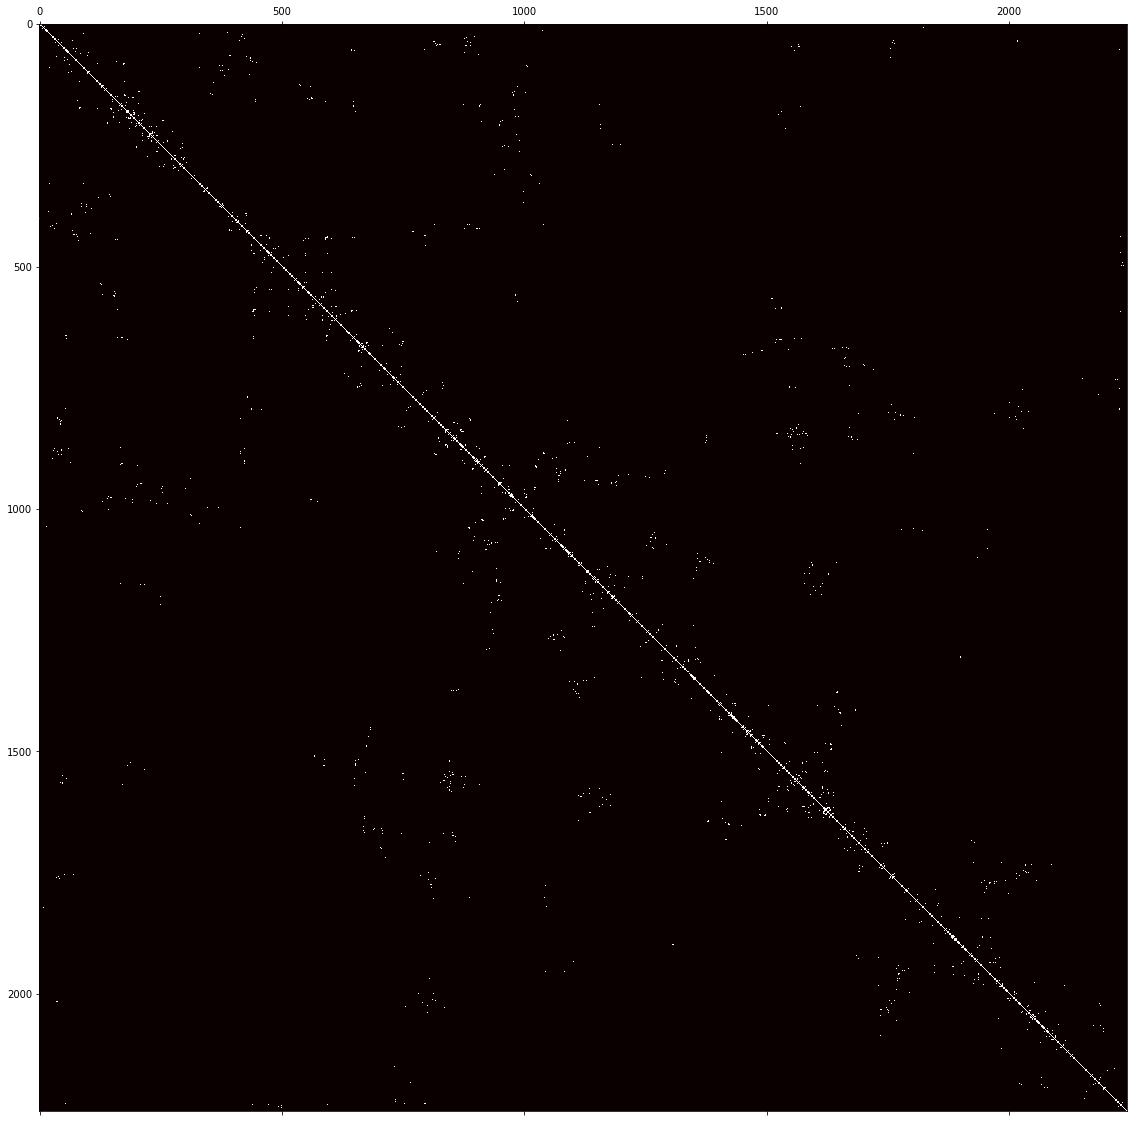

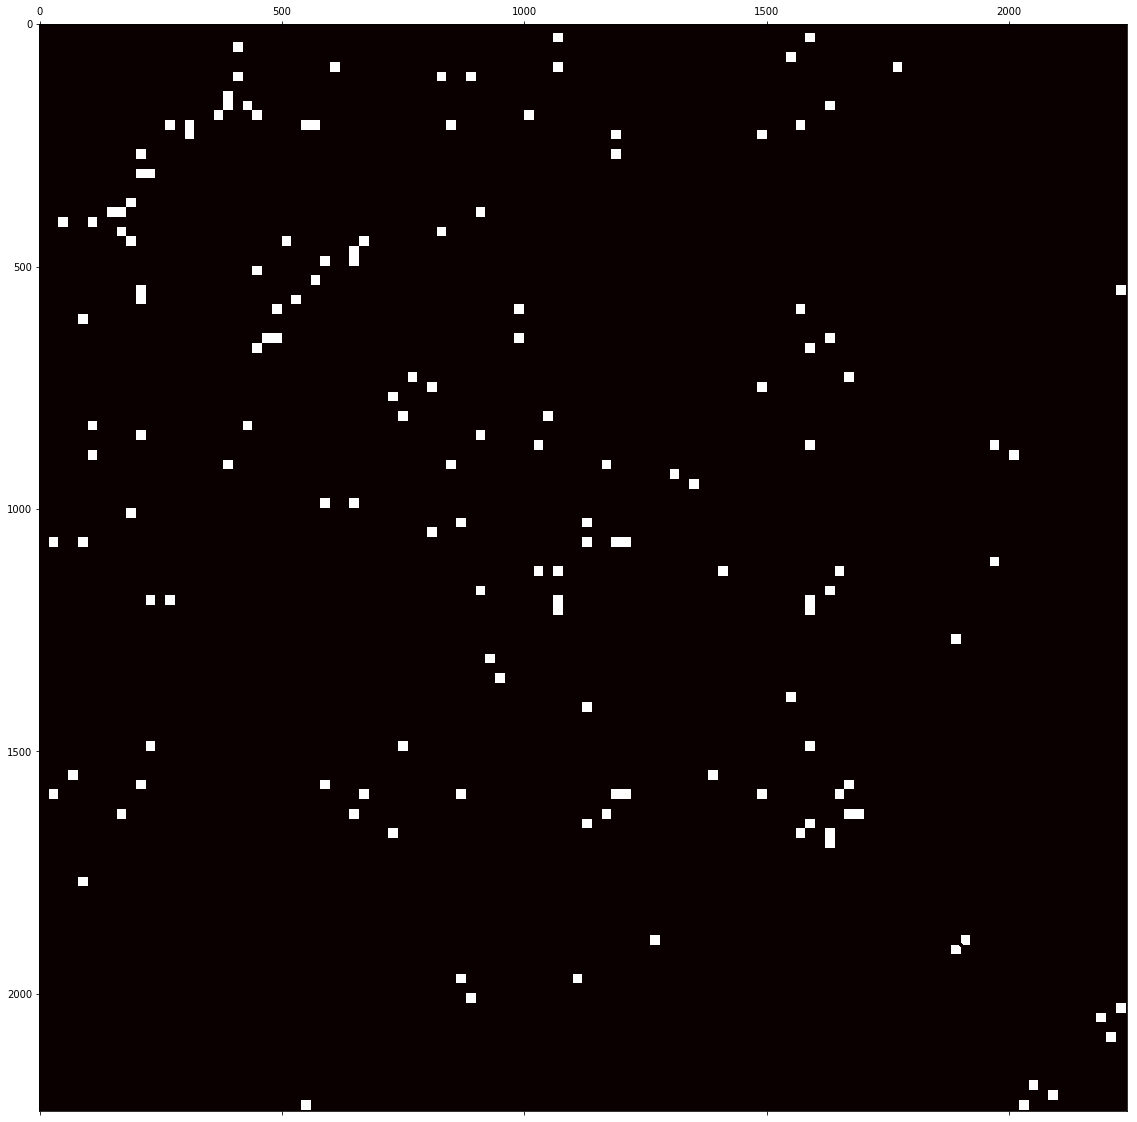

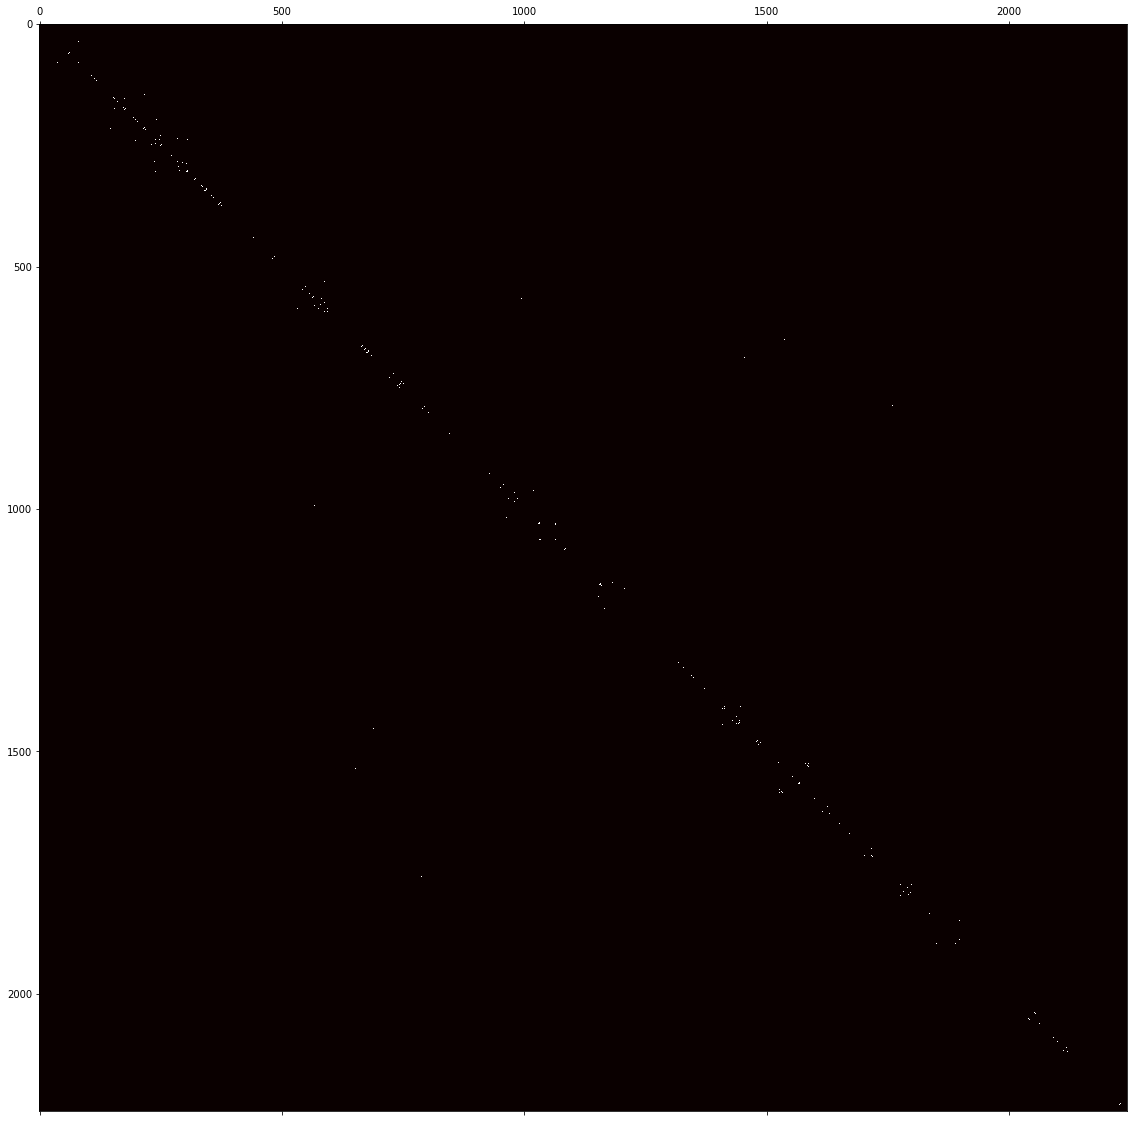

Removed 172 contacts
random walk


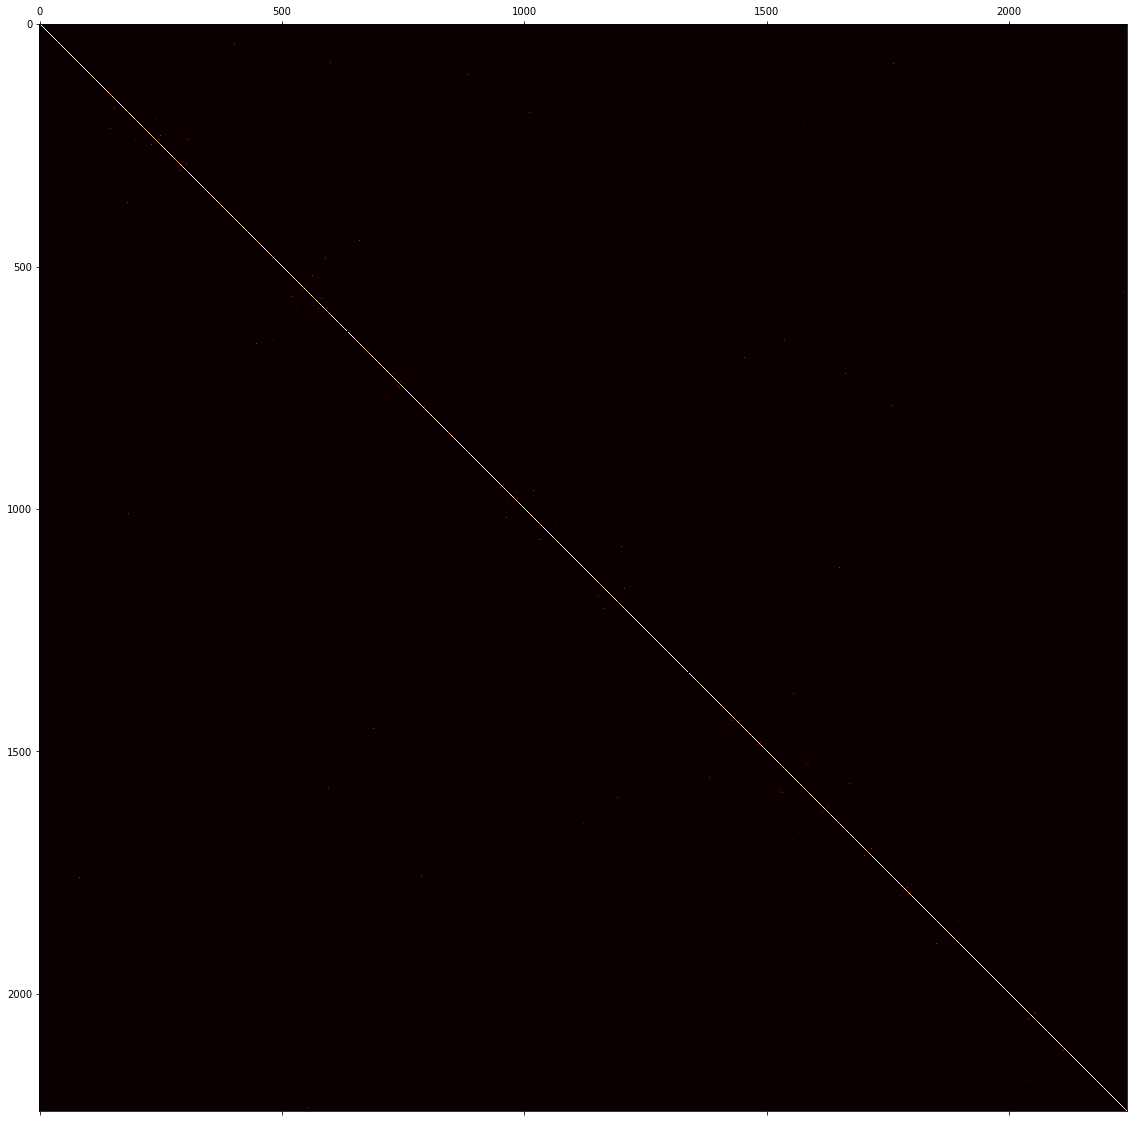

transitivity


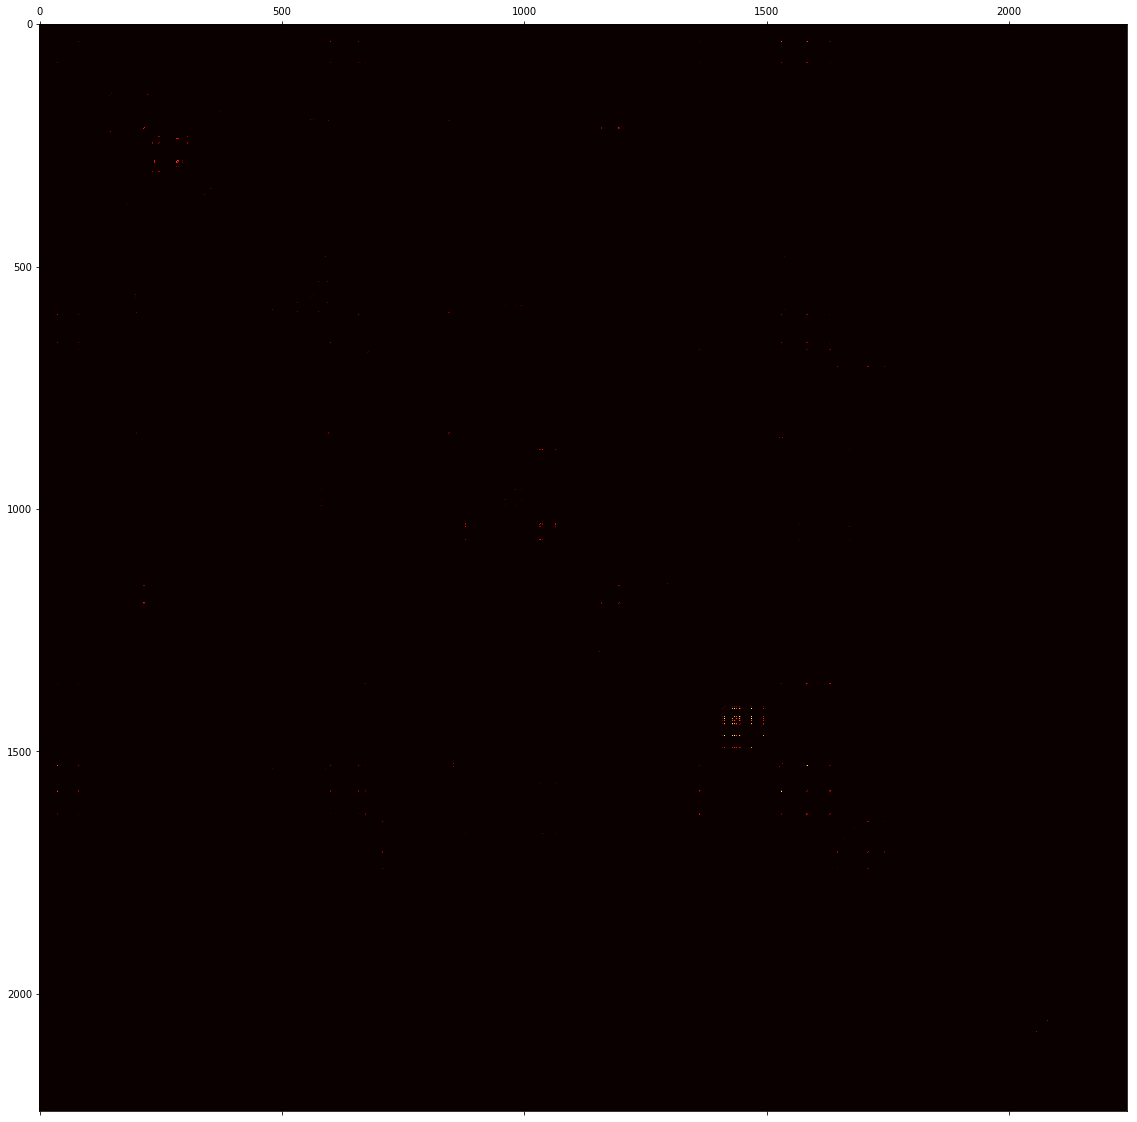

Precision max: 0.22846975088967972
Recall max: 0.6815286624203821
F1 max: 0.3422174840085288
sc21


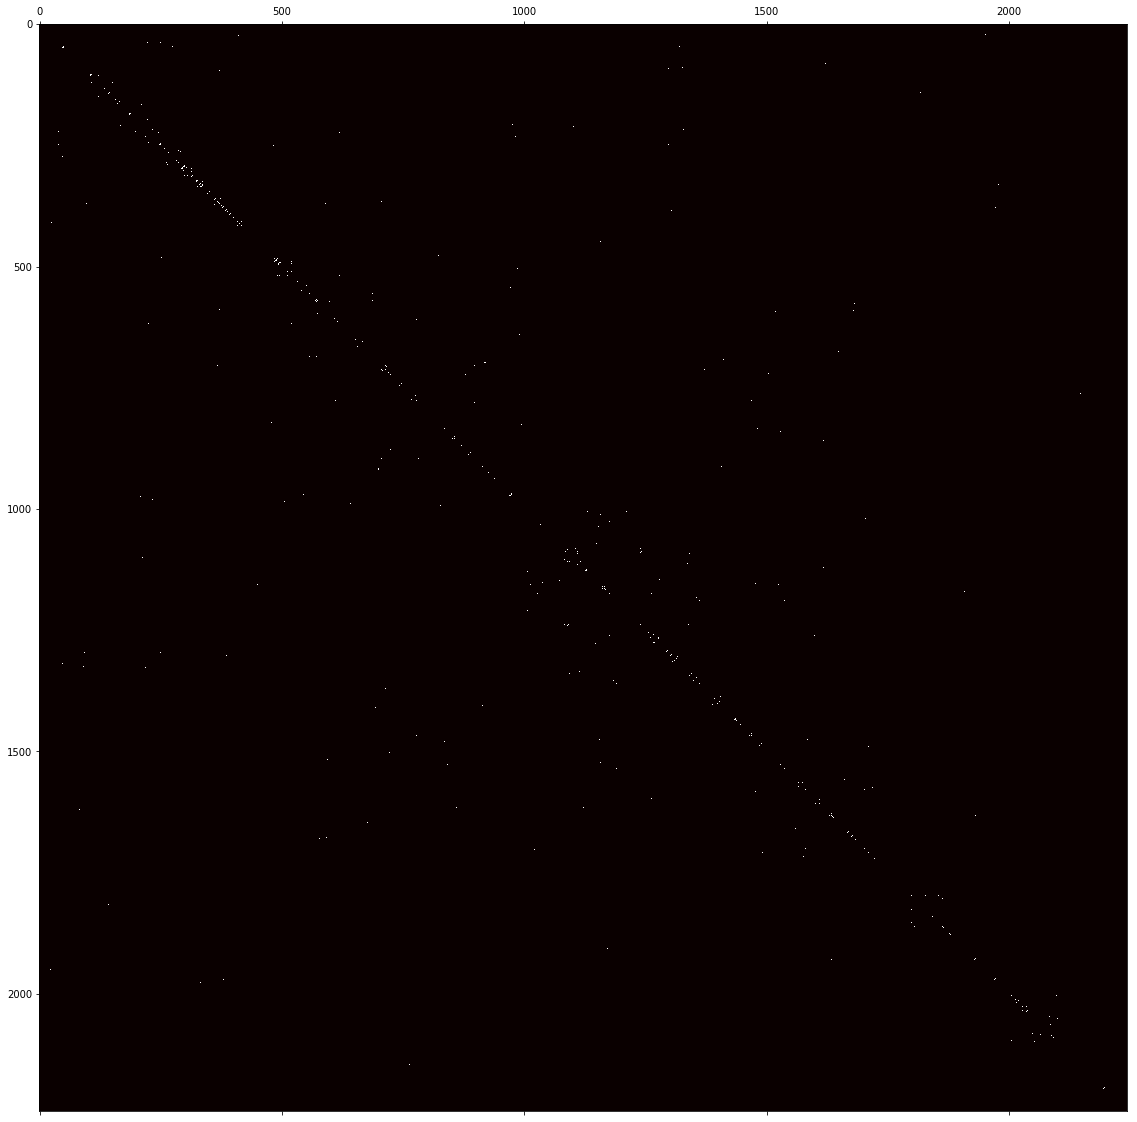

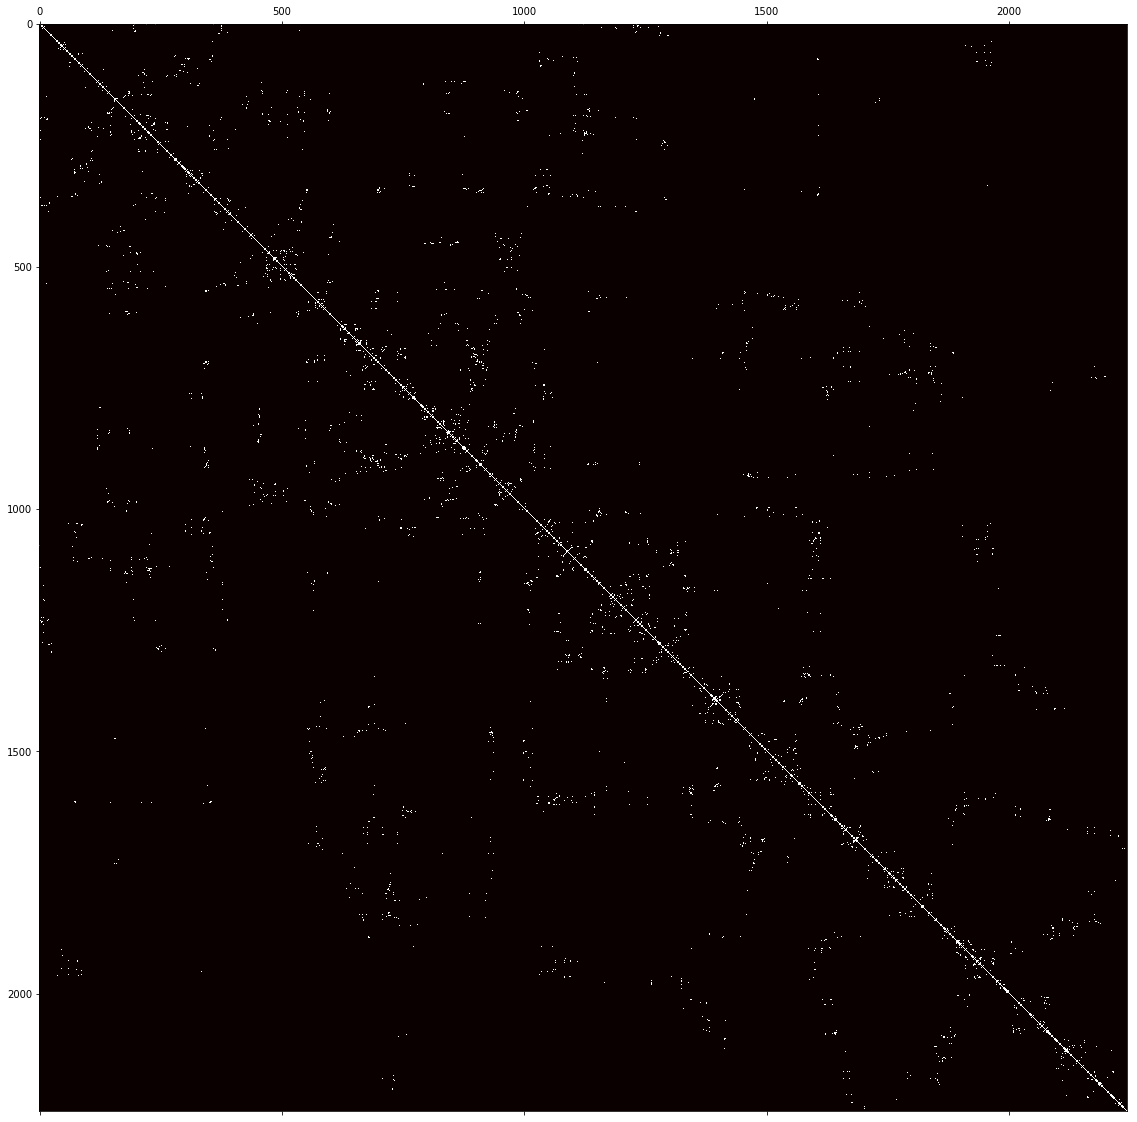

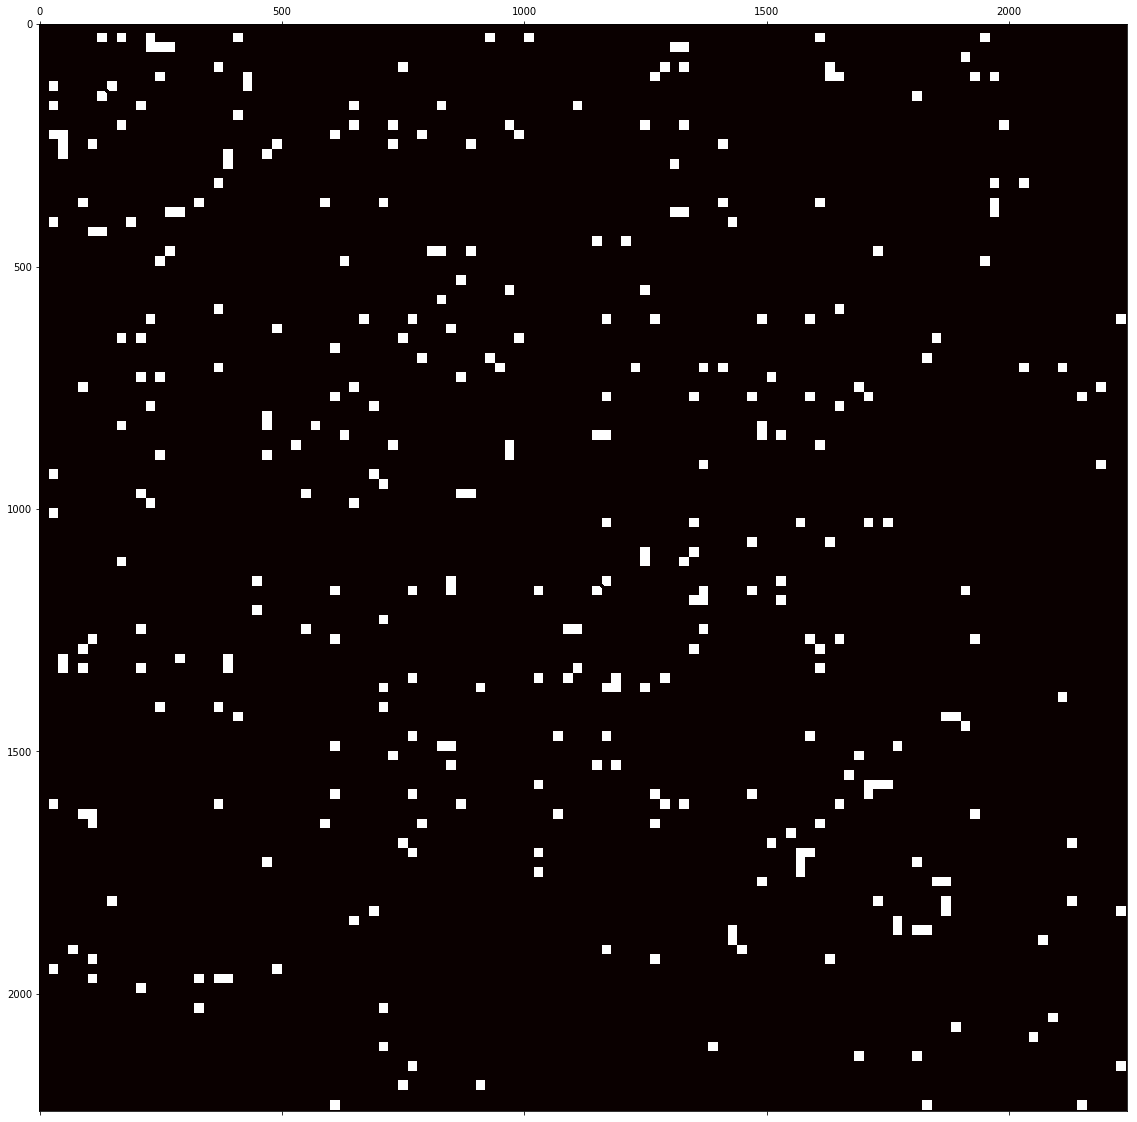

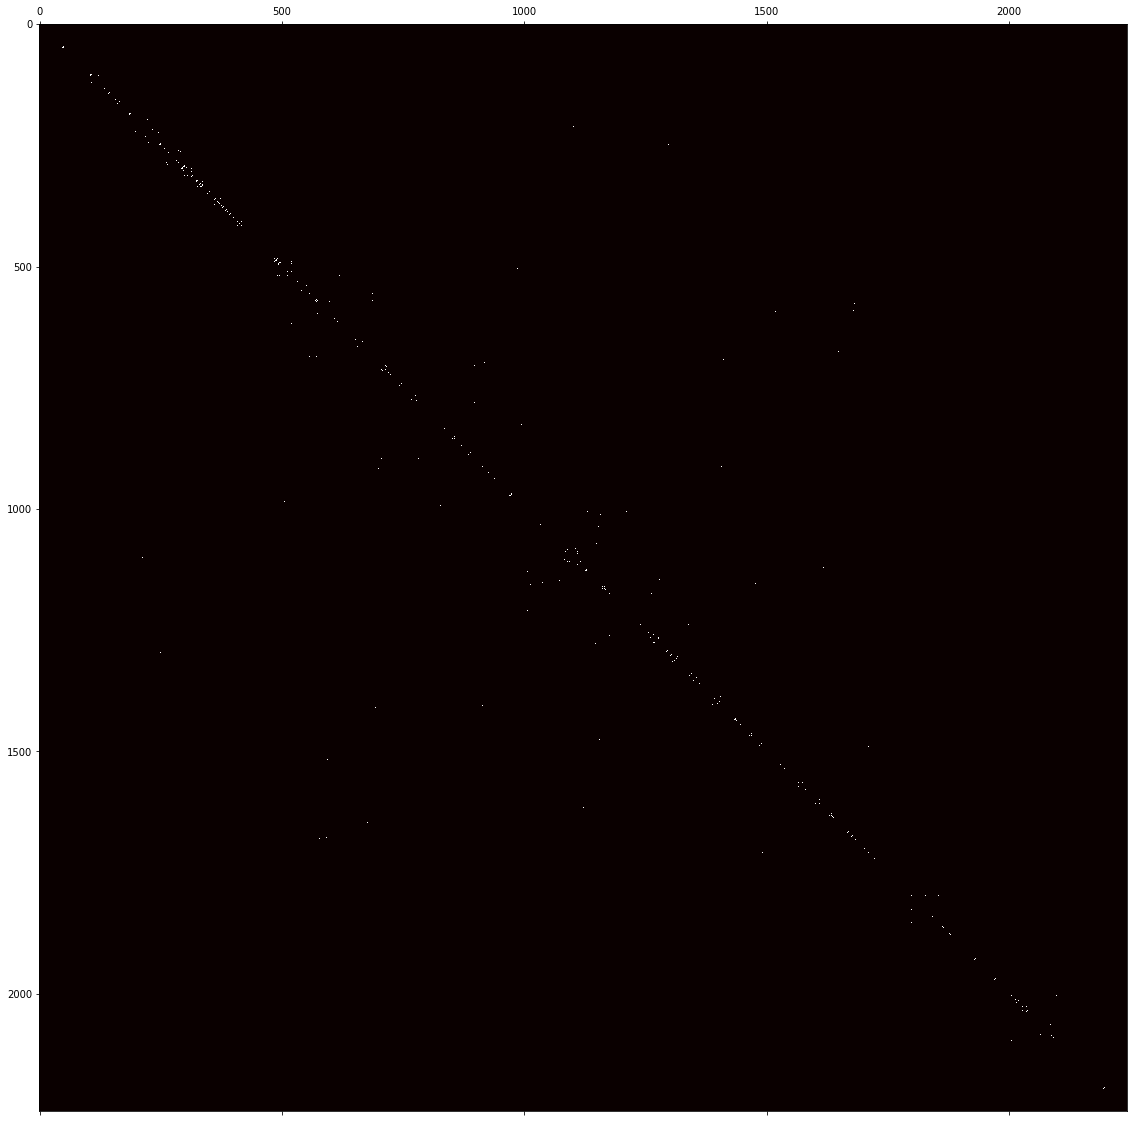

Removed 476 contacts
random walk


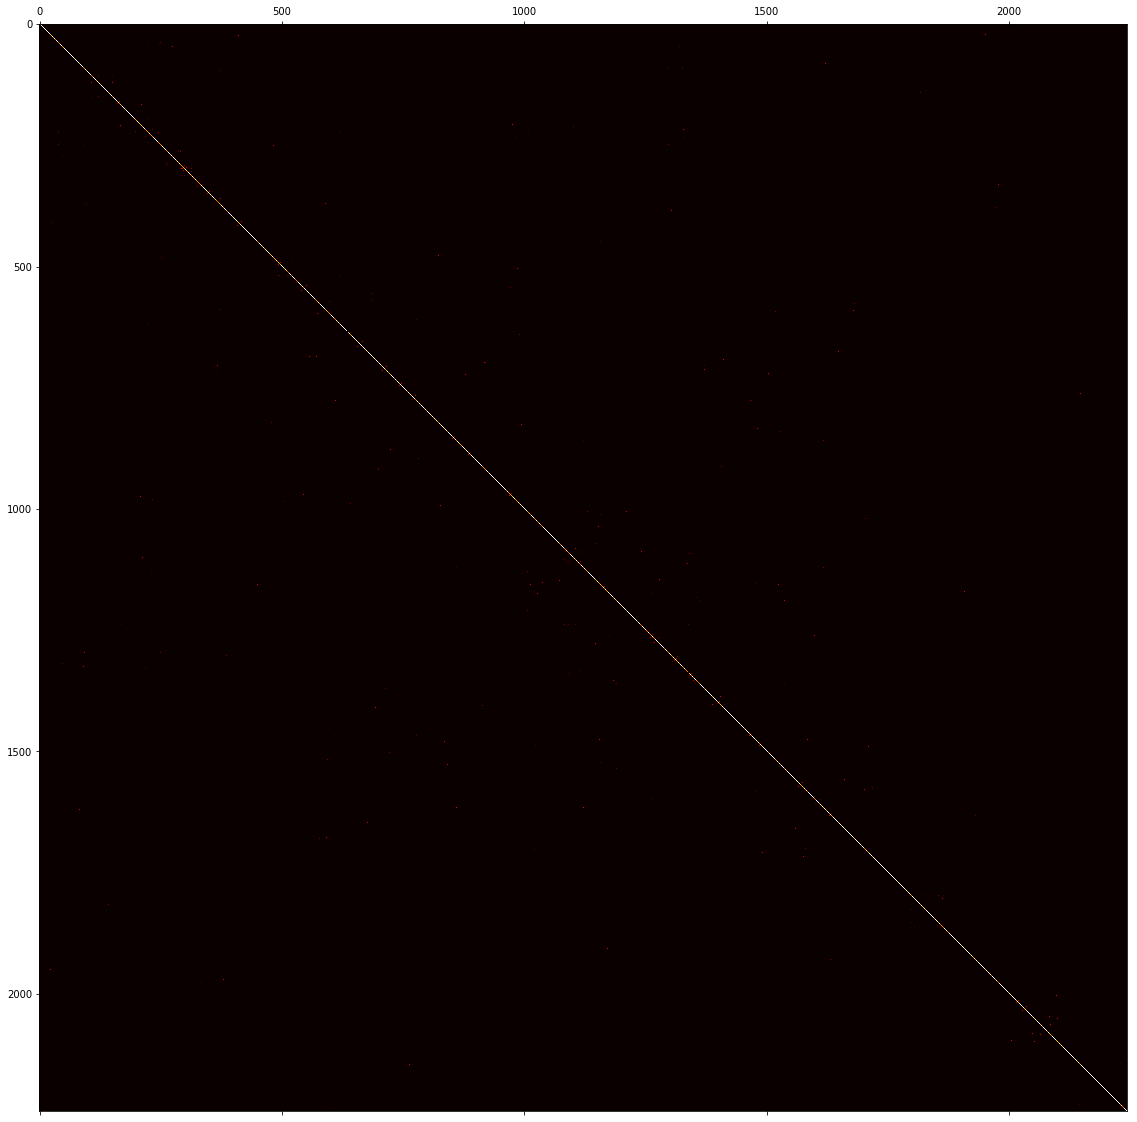

transitivity


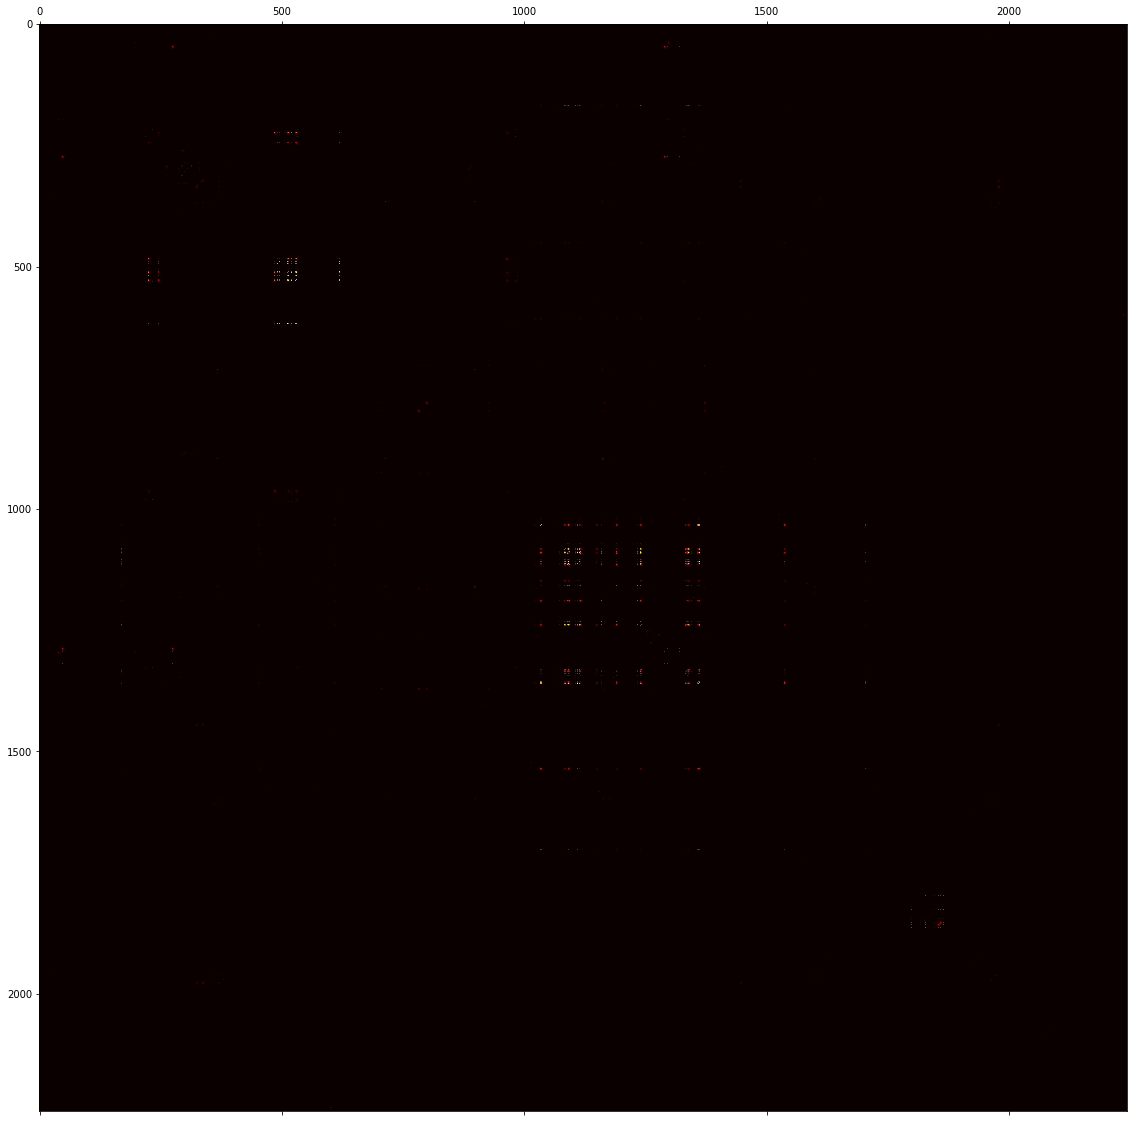

Precision max: 0.16601135867190914
Recall max: 0.5307262569832403
F1 max: 0.2529118136439268
sc29


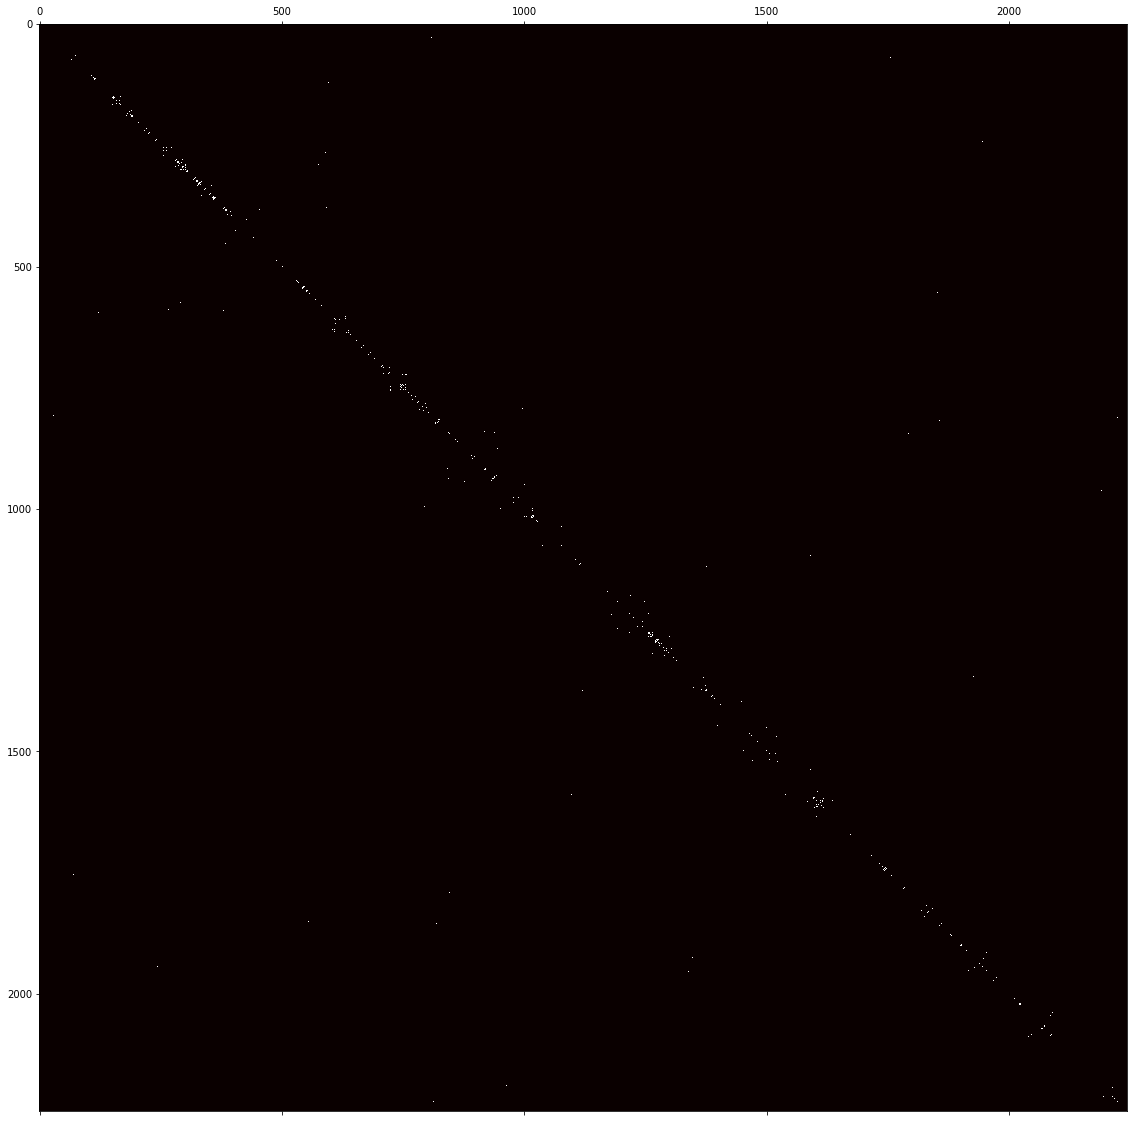

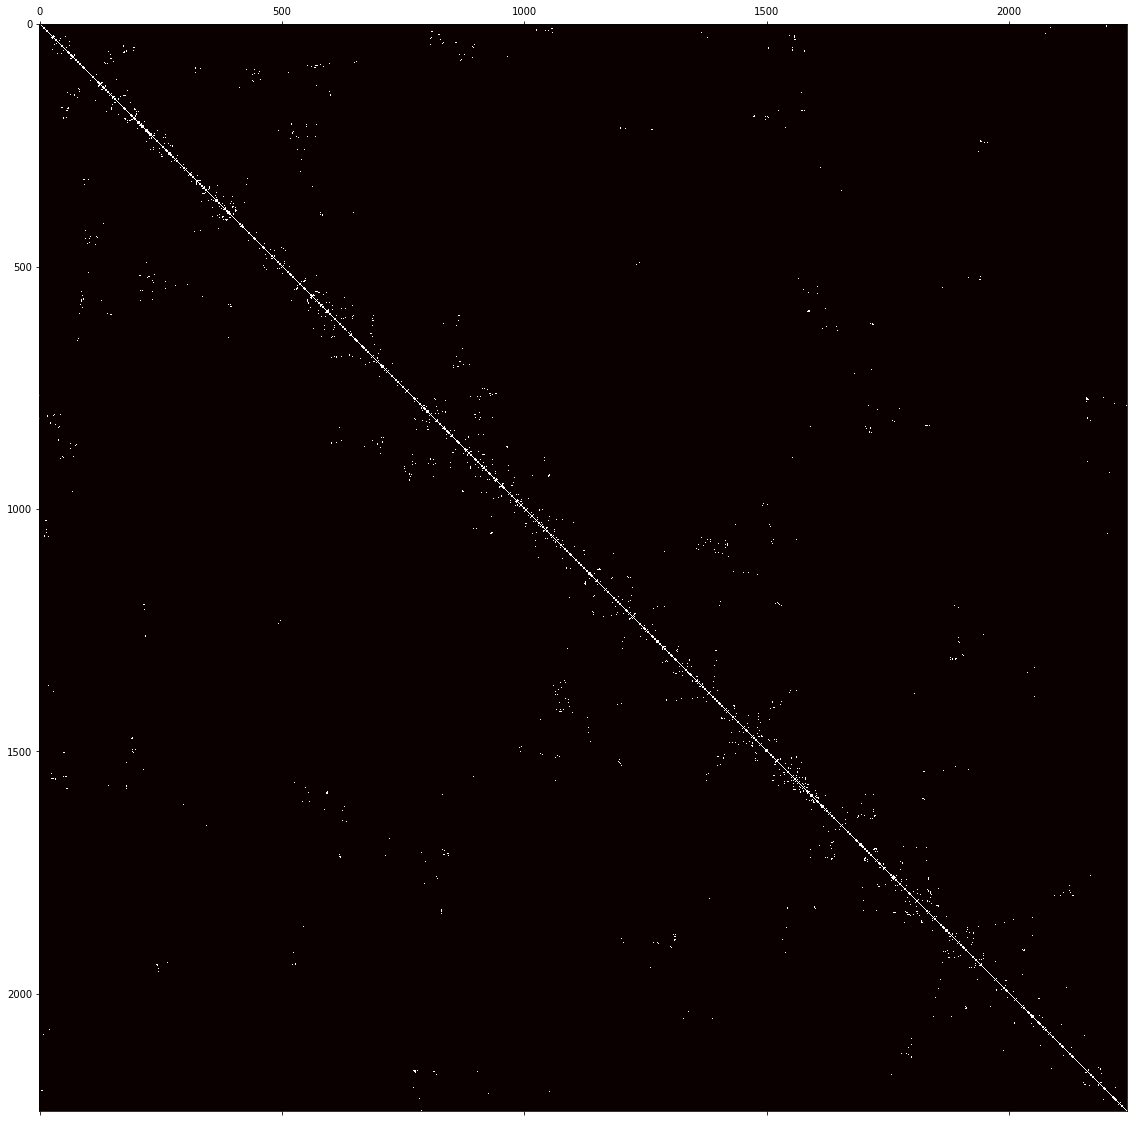

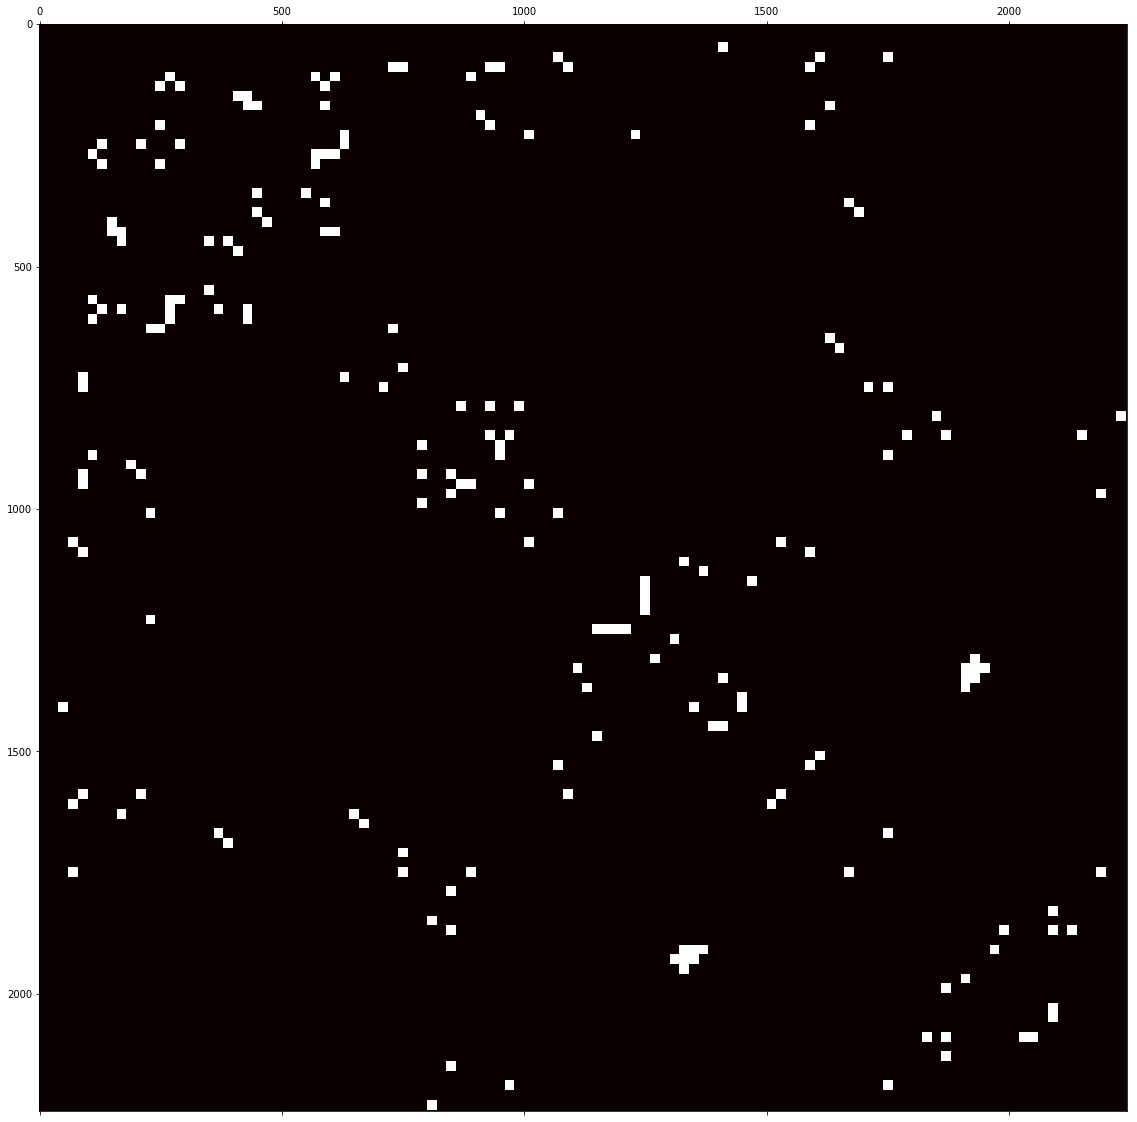

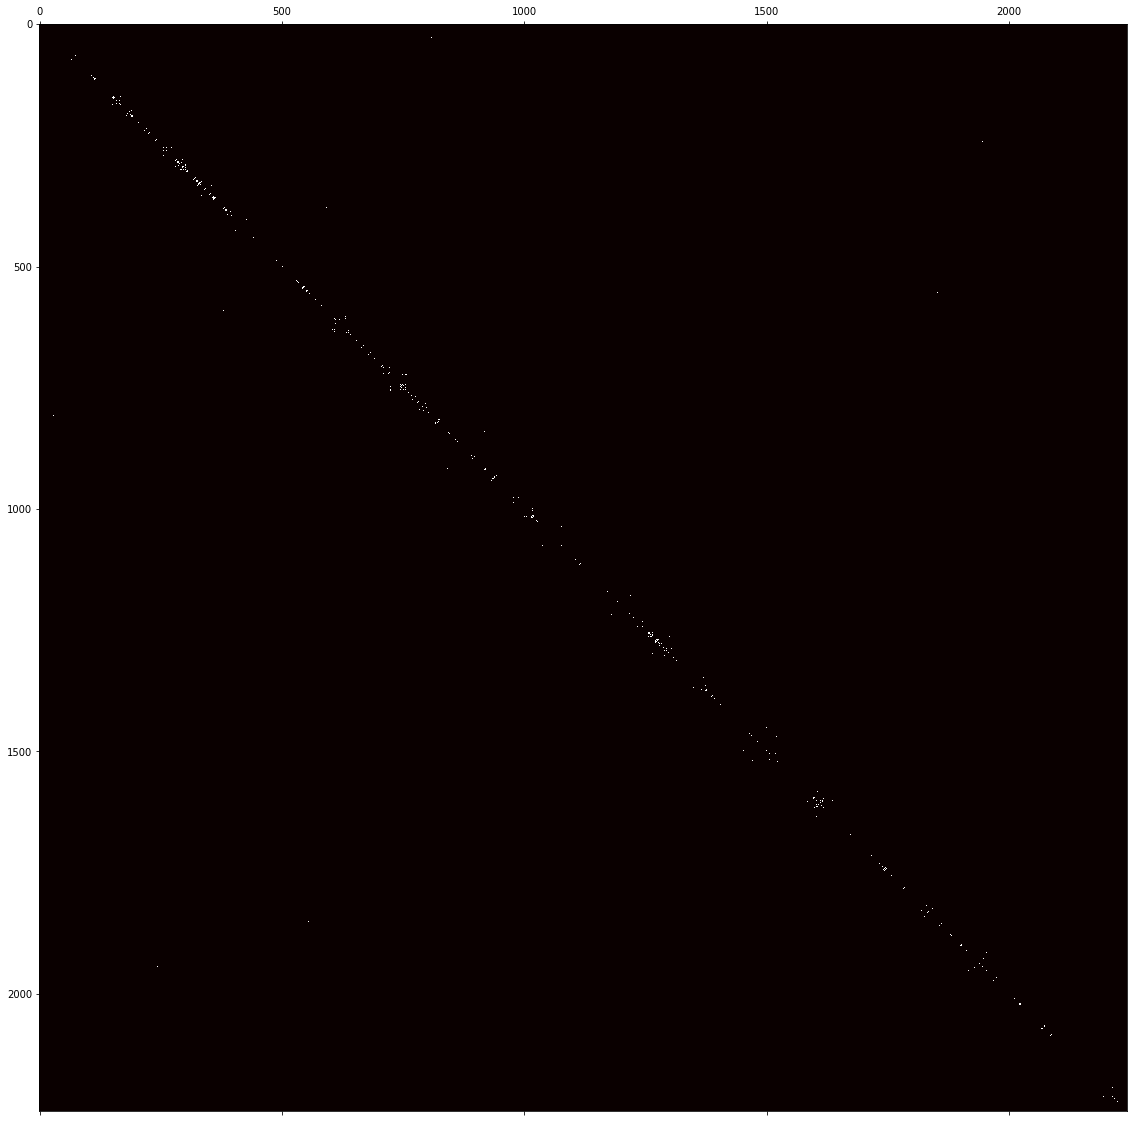

Removed 248 contacts
random walk


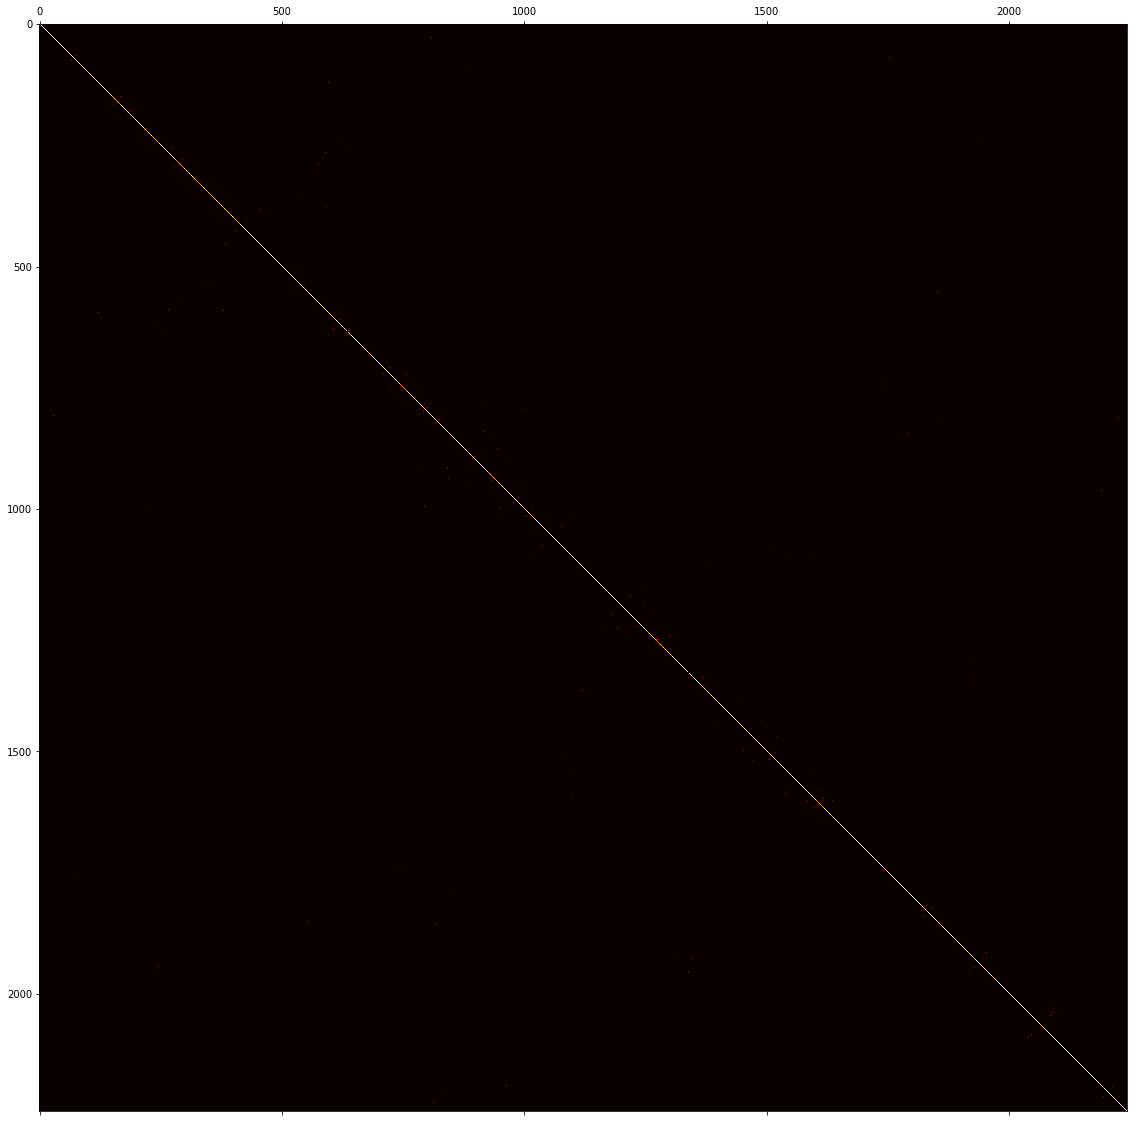

transitivity


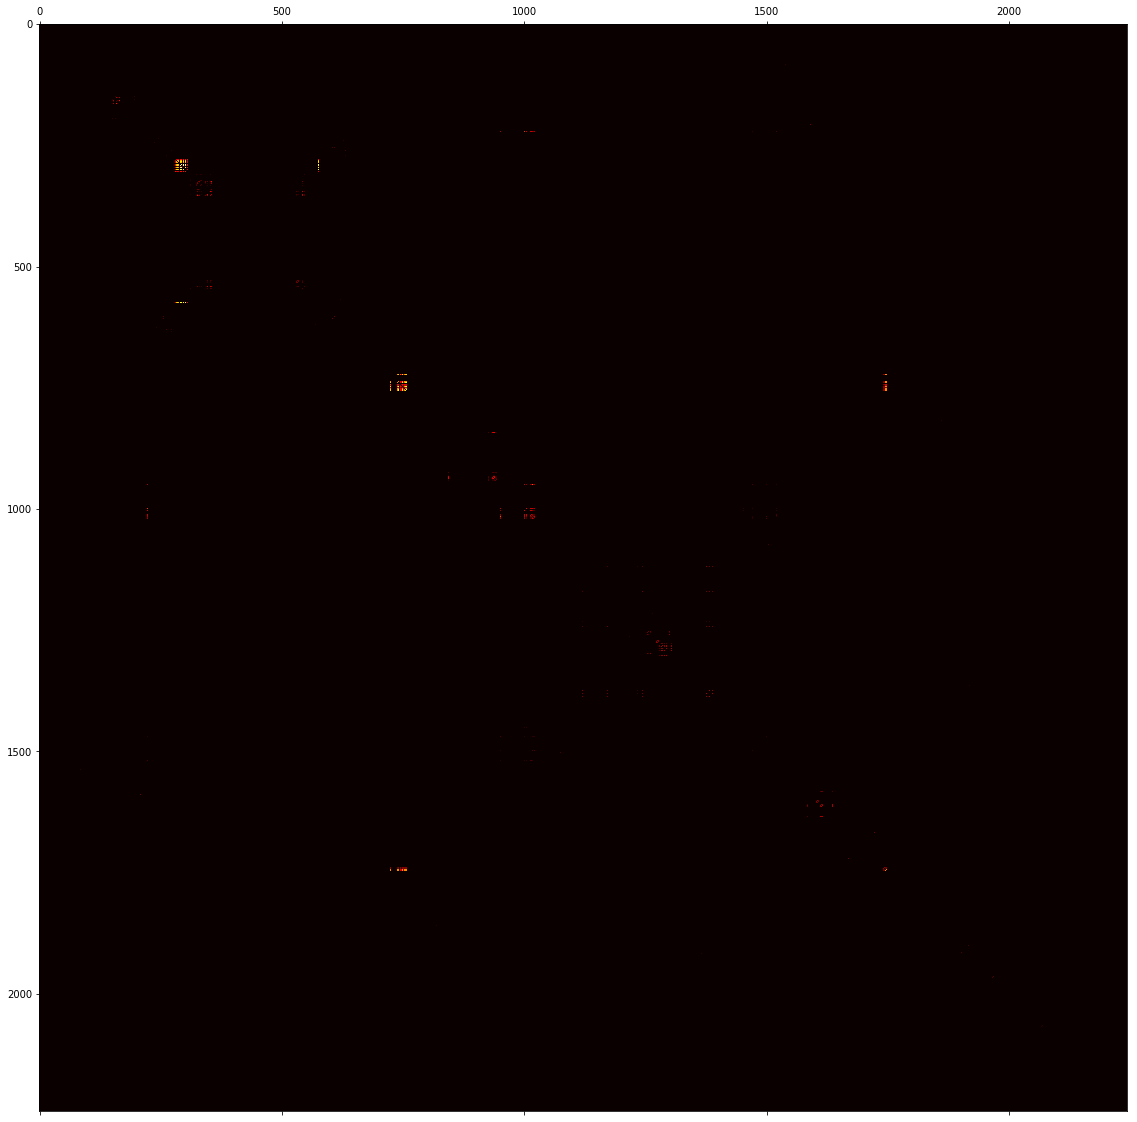

Precision max: 0.20449601160261058
Recall max: 0.5899581589958159
F1 max: 0.3037156704361874
A6


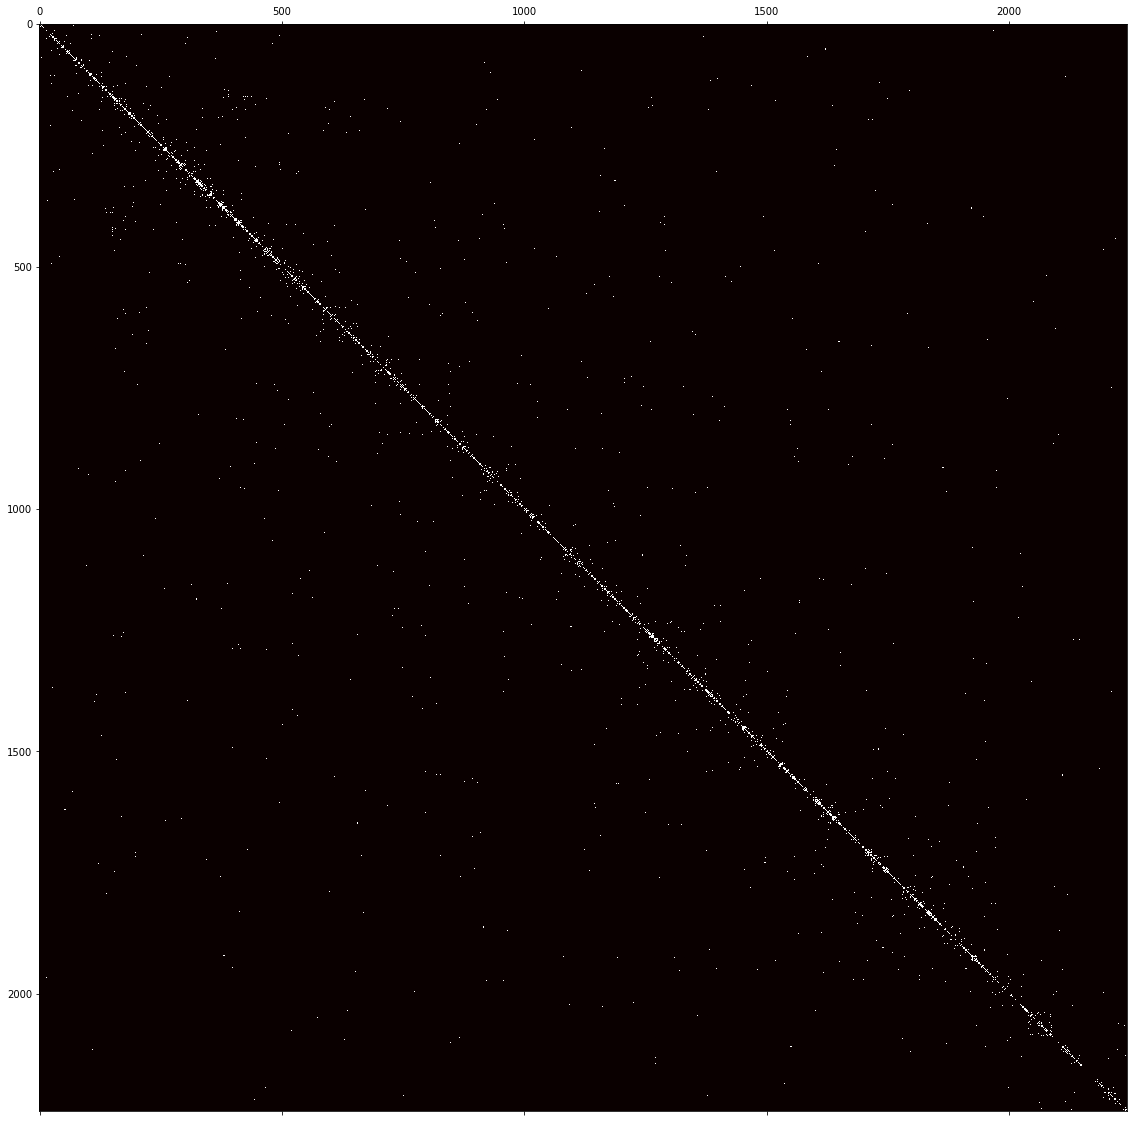

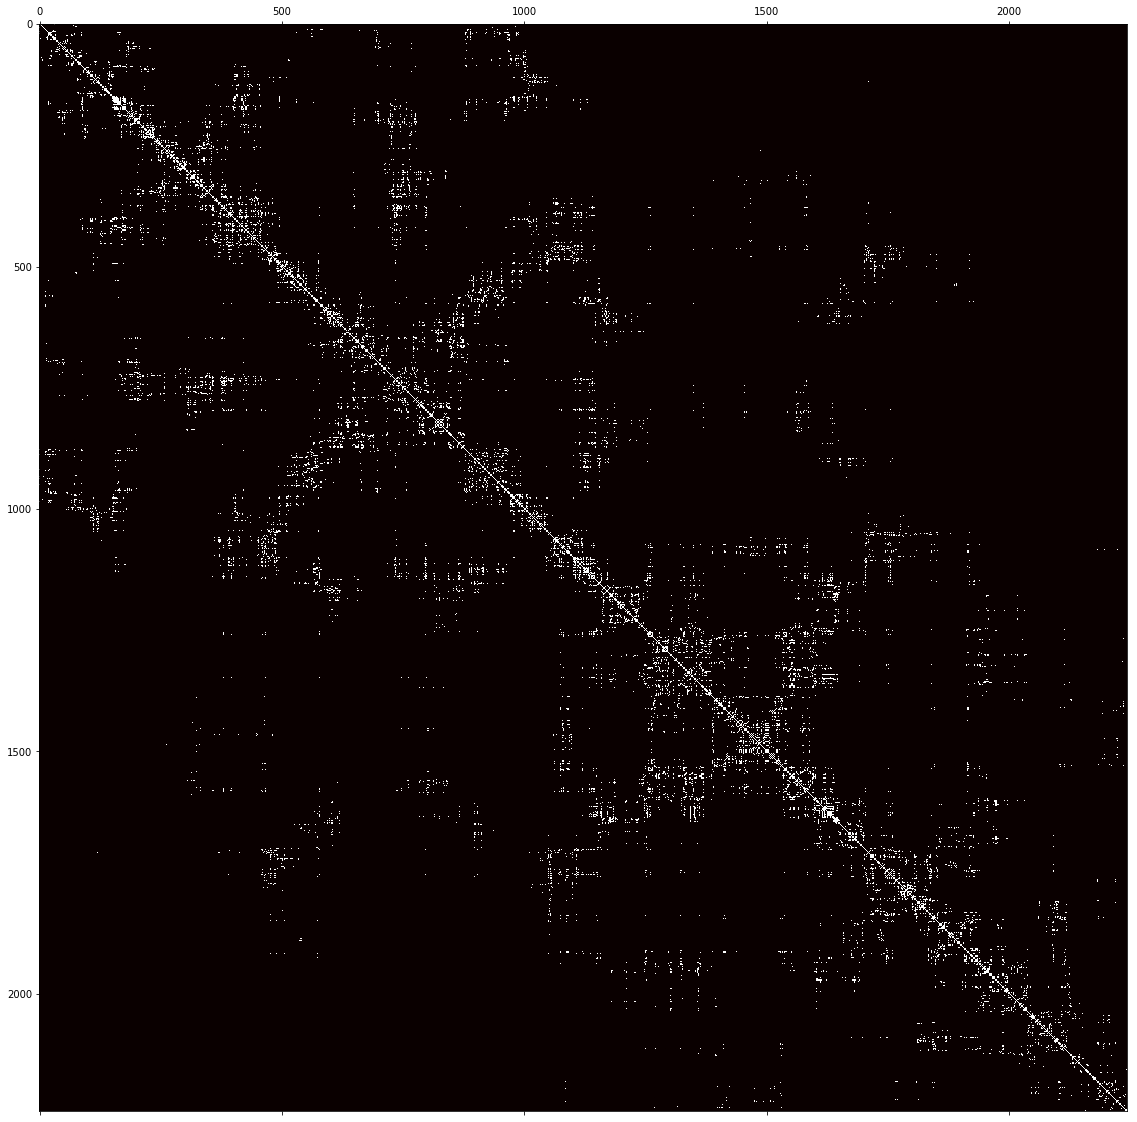

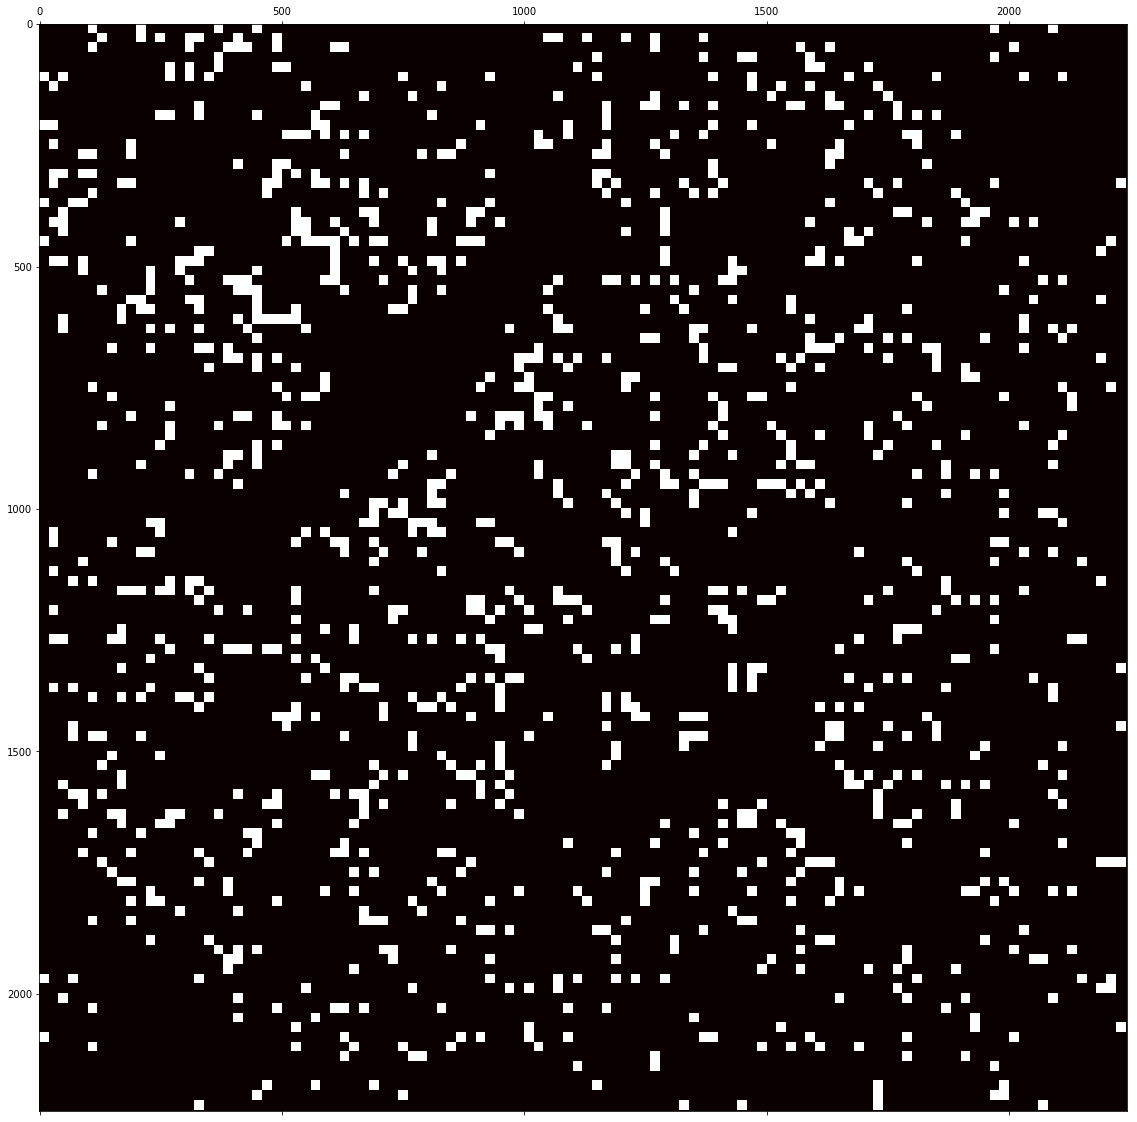

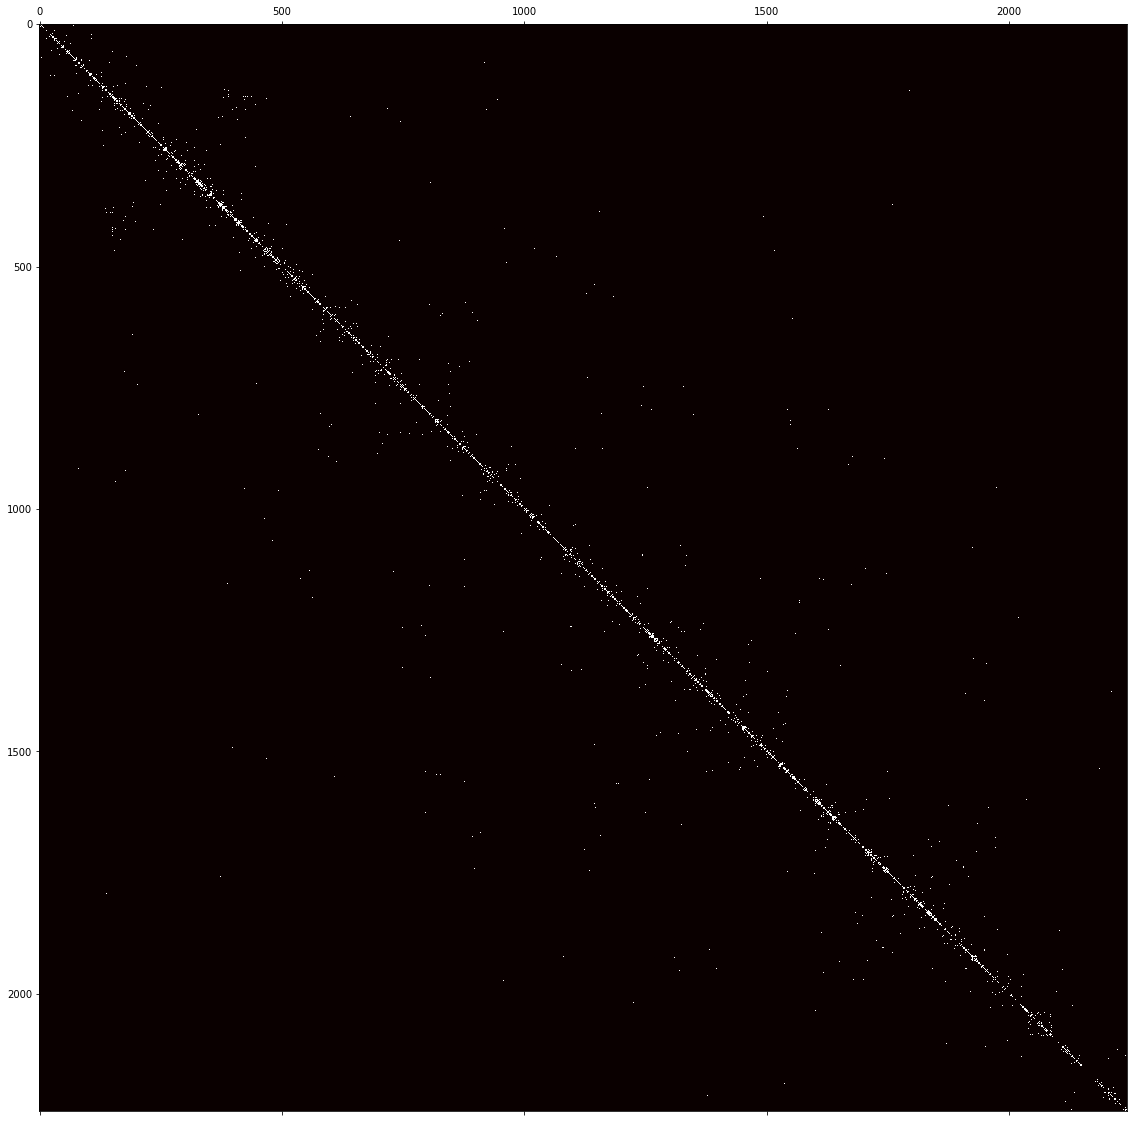

Removed 1482 contacts
random walk


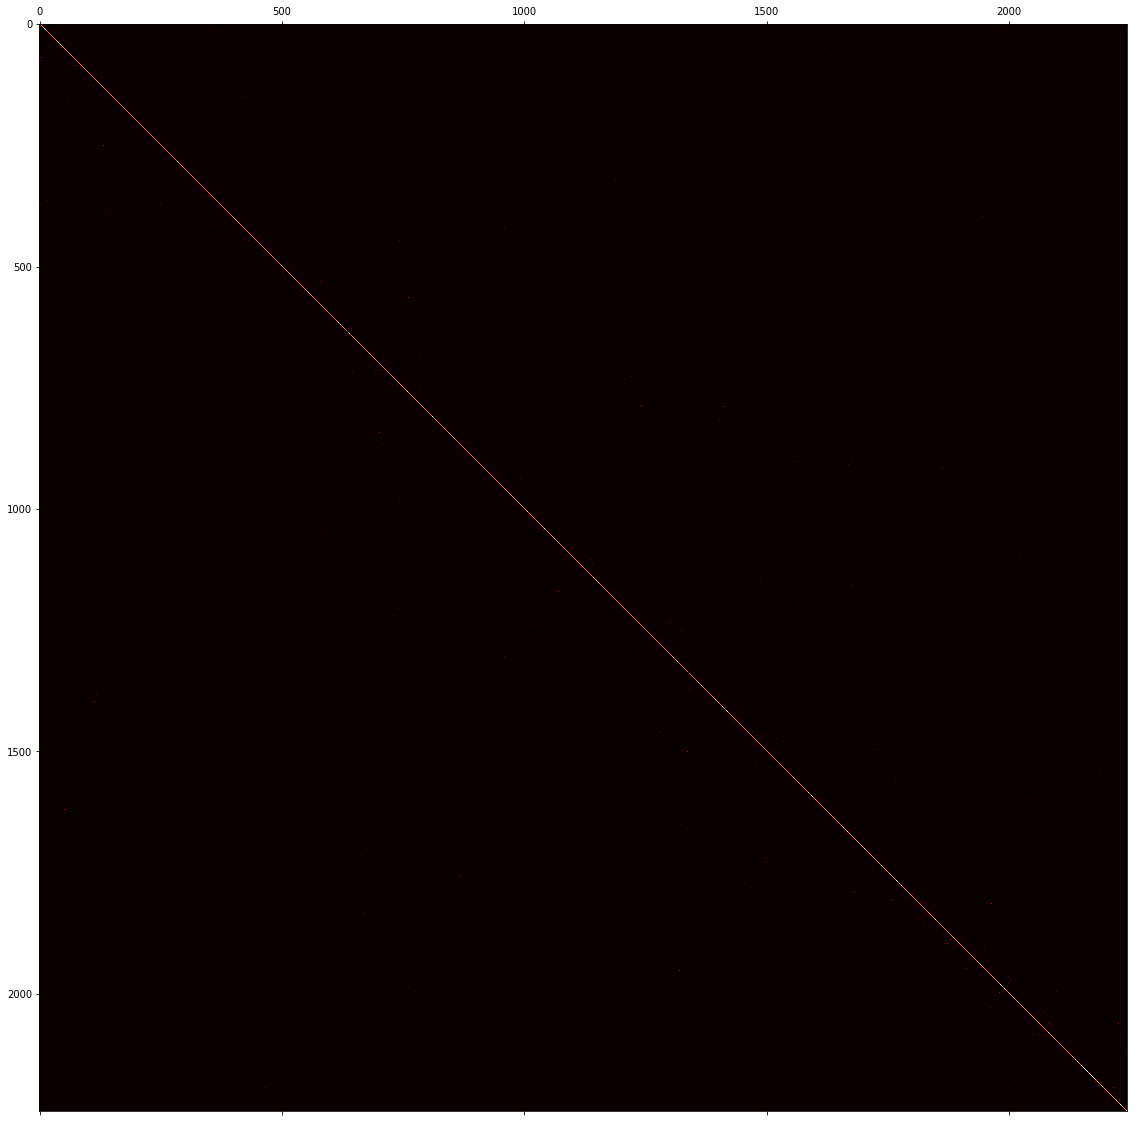

In [ ]:
for f_name in names_list:
    compare_files(f_name)

In [ ]:
5

In [11]:
5

5